In [2]:
import mne
import numpy as np
from matplotlib import pyplot as plt
from mnelab.io.writers import write_edf
import math
from scipy import stats, signal
import itertools
import pandas as pd
from datetime import datetime
import os
from visbrain.io.rw_hypno import read_hypno
import yasa
from lspopt import spectrogram_lspopt
from matplotlib.colors import Normalize
from scipy import signal
import h5py
import joblib
import lightgbm
import scipy.stats as sp_stats
import scipy.signal as sp_sig
import antropy as ant
from scipy.integrate import simps
from sklearn.preprocessing import robust_scale
import scipy.io as sio
plt.style.use('dark_background')



RuntimeError: Refusing to import PyQt5 because PySide6.QtCore is already imported.

Extracting EDF parameters from C:\Lilach\402_for_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


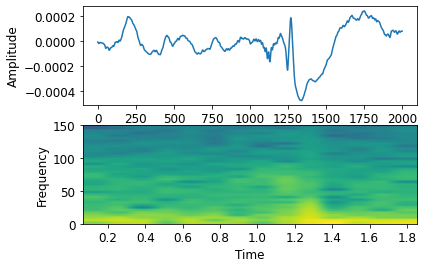

In [35]:
# get spike segment
sf = 1000
raw = mne.io.read_raw_edf('C:\\Lilach\\402_for_tag.edf')
spikes = raw.annotations
spikes_df = pd.DataFrame(spikes)
# end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
raw.crop(tmin=96, tmax=98).resample(sf)
signal_data = raw.copy().pick_channels(['RAH1']).get_data()[0]
# eye2_data = raw.copy().pick_channels(['EOG2']).get_data()[0]
# plt.plot(data)
# samplingFrequency, signalData = wavfile.read('y.wav')

# Plot the signal read from wav file
plt.subplot(211)

plt.plot(signal_data)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.subplot(212)
plt.specgram(signal_data,Fs=sf)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.ylim(0, 150)
plt.show() 

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0, 0.5, 'Log Power (dB / Hz)')

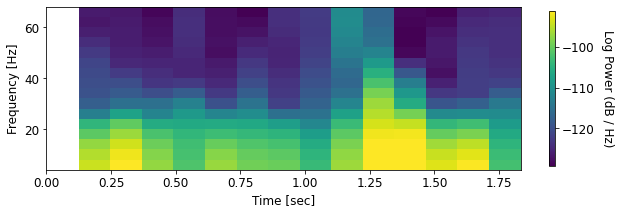

In [36]:
# yasa.plot_spectrogram(signal_data, sf, win_sec=0.5, cmap='Spectral_r')
data = signal_data
# Set default font size to 12
plt.rcParams.update({'font.size': 12})

# Calculate multi-taper spectrogram
nperseg = int(0.25 * sf)
assert data.size > 2 * nperseg, 'Data length must be at least 2 * win_sec.'
f, t, Sxx = spectrogram_lspopt(data, sf, nperseg=250, noverlap=128)
Sxx = 10 * np.log10(Sxx)  # Convert uV^2 / Hz --> dB / Hz

# Select only relevant frequencies (up to 30 Hz)
good_freqs = np.logical_and(f >= 0.1, f <= 70)
Sxx = Sxx[good_freqs, :]
f = f[good_freqs]
#     t /= 3600  # Convert t to hours

# Normalization
vmin, vmax = np.percentile(Sxx, [2.5, 97.5])
norm = Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
im = ax.pcolormesh(t, f, Sxx, norm=norm, antialiased=True)
# im = ax.pcolormesh(t, np.arange(0,41, 2), Sxx, norm=None, cmap=cmap, antialiased=True)
ax.set_xlim(0, t.max())
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')

# Add colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.95, fraction=0.1, aspect=25)
cbar.ax.set_ylabel('Log Power (dB / Hz)', rotation=270, labelpad=20)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


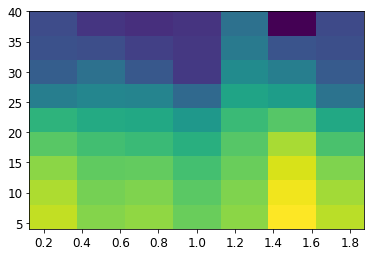

In [37]:
f, t, Sxx = spectrogram_lspopt(data, sf, nperseg=nperseg, noverlap=0)
Sxx = 10 * np.log10(Sxx)
good_freqs = np.logical_and(f >= 0.1, f <= 40)
Sxx = Sxx[good_freqs, :]
f = f[good_freqs]
plt.pcolormesh(t, f, Sxx)

In [108]:
np.arange(1,41)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

In [95]:
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet,
                                tfr_array_morlet)
freqs = np.arange(5., 100., 3.)
n_cycles = freqs / 2.
power = tfr_array_morlet(data, sfreq=sf,
                         freqs=freqs, n_cycles=n_cycles,
                         output='avg_power')
# Baseline the output
# rescale(power, epochs.times, (0., 0.1), mode='mean', copy=False)
fig, ax = plt.subplots()
x, y = centers_to_edges(data.size * 1000, freqs)
mesh = ax.pcolormesh(x, y, power[0], cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_title('TFR calculated on a numpy array')
ax.set(ylim=freqs[[0, -1]], xlabel='Time (ms)')
fig.colorbar(mesh)
plt.tight_layout()

plt.show()

ValueError: epoch_data must be of shape (n_epochs, n_chans, n_times), got (1000,)

In [ ]:
%matplotlib qt
raw = mne.io.read_raw_edf('C:\\Lilach\\402_for_tag.edf')
raw.plot(duration=30, scalings='auto')

In [ ]:
for x in raw.annotations:
    print(x)

In [ ]:
# raw.annotations.save('C:\\Lilach\\402_anot.csv')

In [3]:
# Get tags from annotations (only until the 'end' cause it's 100% covered)
raw = mne.io.read_raw_edf('C:\\Lilach\\402_for_tag.edf')

df = pd.DataFrame(raw.annotations)
i = df.loc[df['description'] == 'END'].index[0]
df = df[:i]
right = df[df['description'].str.contains('Rt')]
left = df[df['description'].str.contains('Lt')]

Extracting EDF parameters from C:\Lilach\402_for_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [ ]:
path = 'C:\\Users\\user\\PycharmProjects\\pythonProject\\results\\'
subj = '402'
right_tags = pd.read_csv(path + f'{subj}\\{subj}_tags.csv')['R'].dropna()

In [21]:
# from mnelab.io.writers import write_edf
# for subj in ['396', '398', '402', '405', '406', '415', '416']:
#     raw = mne.io.read_raw_edf(f'C:\\Lilach\\{subj}_for_tag.edf')
#     raw.load_data()
#     raw.filter(l_freq=0.1, h_freq=500)
#     raw.notch_filter((60, 120, 180, 240), method='spectrum_fit')
#     write_edf(f'C:\\Lilach\\{subj}_for_tag_filtered.edf', raw)

In [ ]:
# create files with 100 samples
channel_name = 'LAH1'
#for subj in ['396', '398', '402', '406', '415', '416']:
for subj in ['396']:
    raw = mne.io.read_raw_fif(f'C:\\UCLA\\{subj}_cz+bi_full_filtered.fif')
    sf = raw.info['sfreq']
    path = f'C:\\analysis\\{subj}\\best_thresh_detect'
    pred_file = [x for x in os.listdir(path) if '2' not in x and 'tag' not in x][0]
    spikes_df = pd.read_csv(path + '\\' + pred_file)
    stim_amp, stim_grad, stim_env = np.zeros((1, raw.n_times)), np.zeros((1, raw.n_times)), np.zeros((1, raw.n_times))
    for evt in spikes_df.sample(100).values:
        if 'amp' in evt[1]:
            stim_amp[0][evt[4]] = 1
        if 'grad' in evt[1]:
            stim_grad[0][evt[4]] = 1
        if 'env' in evt[1]:
            stim_env[0][evt[4]] = 1

    raw.pick_channels([x for x in raw.ch_names if x[0] == 'L' and '-' not in x])
    info_amp = mne.create_info(['AMP'], raw.info['sfreq'], ['stim'])
    info_grad = mne.create_info(['GRAD'], raw.info['sfreq'], ['stim'])
    info_env = mne.create_info(['ENV'], raw.info['sfreq'], ['stim'])
    amp_raw = mne.io.RawArray(stim_amp, info_amp)
    grad_raw = mne.io.RawArray(stim_grad, info_grad)
    env_raw = mne.io.RawArray(stim_env, info_env)
    raw.load_data()
    raw.add_channels([amp_raw, grad_raw, env_raw], force_update_info=True)
    raw.save(f'C:\\analysis\\{subj}\\{subj}_LAH1_100_samples.fif', overwrite=True)


In [60]:
spikes_df.sample(100)

Unnamed: 0          threshold_type  first_index  last_index  max_index  \
106          107                     env      2029731     2029747    2029740   
2577        2578                     amp     46573247    46573283   46573269   
1086        1087         ['env', 'grad']     18340520    18340597   18340565   
1384        1385                     env     22667435    22667461   22667443   
2712        2713                     env     49215548    49215569   49215554   
...          ...                     ...          ...         ...        ...   
2333        2334                    grad     41159214    41159248   41159214   
1549        1550  ['env', 'grad', 'amp']     27198741    27198813   27198782   
2013        2014         ['env', 'grad']     36156248    36156272   36156264   
953          954         ['env', 'grad']     16612243    16612395   16612374   
2711        2712         ['env', 'grad']     49192324    49192419   49192363   

       max_amp  duration  duration_sec  
106   0.000321        16        0.0080  
2577  0.001822        36        0.0180  
1086 -0.001534        77        0.0385  
1384  0.000183        26        0.0130  
2712  0.000214        21        0.0105  
...        ...       ...           ...  
2333 -0.001426        34        0.0170  
1549  0.001426        72        0.0360  
2013  0.000537        24        0.0120  
953  -0.000901       152        0.0760  
2711  0.000918        95        0.0475  

[100 rows x 8 columns]

In [68]:
len(spikes_df[spikes_df['threshold_type'].str.contains(',')])

1339

In [ ]:
for subj in ['396', '398', '402', '406', '415', '416']:
    edf = f'C:\\UCLA\\P{subj}_overnightData.edf'
    raw = mne.io.read_raw_edf(edf)
    hypno_file = edf.split('_')[0] + '_hypno.txt'

    # read hypnogram old format (1sec)
    hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)

    # make raw object into epochs (30 sec)
    dummy_events = mne.make_fixed_length_events(raw, id=1, duration=30)[:len(hypno)]

    # incorporate the scoring into the events file:
    dummy_events[:, 2] = hypno
    event_dict = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'REM': 4, 'art': -1}

    # epoch data into 30sec pieces:
    epochs = mne.Epochs(raw, events=dummy_events, event_id=event_dict, tmin=0,
                        tmax=30, baseline=(0, 0), on_missing='ignore')
    epochs.drop(epochs['REM'].selection)
    nrem_raw = mne.io.RawArray(np.concatenate(epochs.get_data(), axis=1), raw.info)
    nrem_raw.save(edf.split('_')[0] + '_NREM.fif')

In [4]:
import mne
import pandas as pd
raw = mne.io.read_raw_edf("C:\\Lilach\\402_for_tag_filtered_fix_tag.edf")
raw.load_data()
raw_bi = raw.copy().pick_channels(['LAH1', 'LAH2']).load_data()
inst, ref_data = mne.set_eeg_reference(raw_bi, ['LAH2'])
bi = mne.set_bipolar_reference(raw_bi, anode=['LAH1'], cathode=['LAH2'], ch_name='bi').get_data()
data, sf, chan = raw.get_data(), raw.info['sfreq'], raw.info['ch_names']
pd.DataFrame({'sub':data[15]-data[16], 'LAH1-LAH2':data[28], 'ref': inst.get_data()[0], 'bi': bi[0]})

Extracting EDF parameters from C:\Lilach\402_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1921999  =      0.000 ...   961.000 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1922000
    Range : 0 ... 1921999 =      0.000 ...   961.000 secs
Ready.
Added the following bipolar channels:
bi


sub     LAH1-LAH2           ref            bi
0        1.525902e-07  7.629511e-08  1.525902e-07  1.525902e-07
1        3.051804e-07  2.288853e-07  3.051804e-07  3.051804e-07
2        4.577707e-07  5.340658e-07  4.577707e-07  4.577707e-07
3        1.068132e-06  9.918364e-07  1.068132e-06  1.068132e-06
4        1.373312e-06  1.297017e-06  1.373312e-06  1.373312e-06
...               ...           ...           ...           ...
1921995  0.000000e+00  7.629511e-08  0.000000e+00  0.000000e+00
1921996  0.000000e+00  7.629511e-08  0.000000e+00  0.000000e+00
1921997  0.000000e+00  7.629511e-08  0.000000e+00  0.000000e+00
1921998  1.525902e-07  7.629511e-08  1.525902e-07  1.525902e-07
1921999  0.000000e+00  7.629511e-08  0.000000e+00  0.000000e+00

[1922000 rows x 4 columns]

In [6]:
raw = mne.io.read_raw_edf("C:\\repos\\epileptic_activity\\bug_check_402.edf")
raw.load_data()
raw_bi = raw.copy().pick_channels(['LAH1', 'LAH2']).load_data()
inst, ref_data = mne.set_eeg_reference(raw_bi, ['LAH2'])
bi = mne.set_bipolar_reference(raw_bi, anode=['LAH1'], cathode=['LAH2'], ch_name='bi').get_data()
data, sf, chan = raw.get_data(), raw.info['sfreq'], raw.info['ch_names']
pd.DataFrame({'sub':data[15]-data[16], 'LAH1-LAH2':data[28], 'ref': inst.get_data()[0], 'bi': bi[0], 'LAH1': data[15], 'LAH2': data[16]})

Extracting EDF parameters from C:\repos\epileptic_activity\bug_check_402.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 239999  =      0.000 ...   959.996 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=240000
    Range : 0 ... 239999 =      0.000 ...   959.996 secs
Ready.
Added the following bipolar channels:
bi


sub  LAH1-LAH2       ref        bi          LAH1      LAH2
0       0.000035   0.000035  0.000035  0.000035  3.135729e-05 -0.000004
1       0.000038   0.000038  0.000038  0.000038  2.769512e-05 -0.000010
2       0.000037   0.000037  0.000037  0.000037  1.548791e-05 -0.000021
3       0.000035   0.000035  0.000035  0.000035  2.975509e-06 -0.000032
4       0.000040   0.000040  0.000040  0.000040  2.288853e-07 -0.000039
...          ...        ...       ...       ...           ...       ...
239995 -0.000121  -0.000121 -0.000121 -0.000121 -1.334401e-04 -0.000012
239996 -0.000119  -0.000119 -0.000119 -0.000119 -1.329824e-04 -0.000014
239997 -0.000115  -0.000115 -0.000115 -0.000115 -1.357290e-04 -0.000020
239998 -0.000111  -0.000111 -0.000111 -0.000111 -1.432059e-04 -0.000032
239999 -0.000106  -0.000106 -0.000106 -0.000106 -1.490043e-04 -0.000043

[240000 rows x 6 columns]

In [9]:
import numpy as np
np.array_equal(bi[0], data[6]-data[7])

True

In [11]:
raw

<RawEDF | 402_for_tag_filtered_fix_tag.edf, 30 x 1922000 (961.0 s), ~439.9 MB, data loaded>

In [62]:
edf = 'C:\\Lilach\\%s_for_tag_filtered_fix_tag.edf'
sr = 1000
channels = ['RAH1', 'RA1']
epochs, epochs_random = [], []
window_size = int(sr / 4)
raw = mne.io.read_raw_edf(edf % '402')
spikes = raw.annotations
spikes_df = pd.DataFrame(spikes)
end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
spikes_df = spikes_df[spikes_df['description'].str.contains(channels[0][0] + 't')]
spikes_df = spikes_df.drop_duplicates(subset=['onset'])
complete_spikes_df = spikes_df[spikes_df['onset'] < end_onset]

# from first tags round- only some spikes here and there
random_spikes_df = spikes_df[spikes_df['onset'] > end_onset]
raw_data = raw.copy().pick_channels(channels).resample(sr).get_data()
for onset in random_spikes_df['onset']:
    epochs_random.append(raw_data[:, int(onset * sr - window_size / 2) : int (onset * sr + window_size / 2)].T)
y_windows_random = np.full(len(epochs_random), 1)

# from second tags round- complete data
raw_data = raw.crop(tmax=end_onset).pick_channels(channels).resample(sr).get_data()

for i in range(0, raw_data.shape[1], window_size):
    curr_block = raw_data[:, i: i  + window_size]
    if i + window_size < raw_data.shape[1]:
        epochs.append(curr_block.T)

y_windows = np.zeros(len(epochs))
for onset in complete_spikes_df['onset']:
    y_windows[int(onset * 1000 / window_size)] = 1

epochs = np.concatenate((epochs, epochs_random))
y_windows = np.concatenate((y_windows, y_windows_random))

Extracting EDF parameters from C:\Lilach\402_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [65]:
epochs.shape

(924, 250, 2)

In [ ]:
# deep preprocess
edf = '%s_for_tag_filtered_fix_tag.edf'
sr = 1000
channels = ['RAH1', 'RA1']
epochs, epochs_random = [], []
window_size = int(sr / 4)
raw = mne.io.read_raw_edf(edf % '402')
spikes = raw.annotations
spikes_df = pd.DataFrame(spikes)
end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
spikes_df = spikes_df[spikes_df['description'].str.contains(channels[0][0] + 't')]
spikes_df = spikes_df.drop_duplicates(subset=['onset'])
complete_spikes_df = spikes_df[spikes_df['onset'] < end_onset]

# from first tags round- only some spikes here and there
random_spikes_df = spikes_df[spikes_df['onset'] > end_onset]
raw_data = raw.copy().pick_channels(channels).resample(sr).get_data()
for onset in random_spikes_df['onset']:
    epochs_random.append(raw_data[:, int(onset * sr - window_size / 2) : int (onset * sr + window_size / 2)].T)
y_windows_random = np.full(len(epochs_random), 1)

# from second tags round- complete data
raw_data = raw.crop(tmax=end_onset).pick_channels(channels).resample(sr).get_data()

for i in range(0, raw_data.shape[1], window_size):
    curr_block = raw_data[:, i: i  + window_size]
    if i + window_size < raw_data.shape[1]:
        epochs.append(curr_block.T)

y_windows = np.zeros(len(epochs))
for onset in complete_spikes_df['onset']:
    y_windows[int(onset * 1000 / window_size)] = 1

epochs = np.concatenate((epochs, epochs_random))
y_windows = np.concatenate((y_windows, y_windows_random))

In [2]:
import h5py
import glob

# mat = scipy.io.loadmat()
subj = '486'
first_stim_sec = 3891
counter = '3'
# maya_path = 'C:\\Maya\\p486\\MACRO\\CSC2.mat'
# firas_path = f'C:\\Matlab\\D0{subj}_raw_v73_{counter}.mat'
mne_raw = None
subj_files_list = glob.glob(f'C:\\Maya\\p{subj}\\MACRO\\*')
for curr_file in subj_files_list:
    try:
        f = h5py.File(curr_file, 'r')
        data = f.get('data')
        data = np.array(data)
        # ch_names = mne.io.read_raw_edf('C:\\Matlab\\D037_04_02_21b.edf').info['ch_names']
        # ch_names = pd.read_csv(f'C:\\Matlab\\D{subj}_chans.csv', header=None)
        # ch_names = [x.replace('\'', '') for x in ch_names.iloc[:, 0].tolist()]
        # ch_names = [x for x in range(10)]
        ch_name_array = np.array([x for x in f['LocalHeader/origName']], dtype='uint16')
        ch_name = ''
        for x in ch_name_array:
            ch_name += chr(x[0])
        # sfreq = int(np.array(f.get('hdr/Fs'))[0][0])
        sfreq = np.array(f['LocalHeader/samplingRate'])[0][0]
        info = mne.create_info(ch_names=[ch_name], sfreq=sfreq)
        if mne_raw is None:
            mne_raw = mne.io.RawArray(data.T, info)
        else:
            mne_raw.add_channels([mne.io.RawArray(data.T, info)])
    except:
        print('error with' + curr_file)
        pass
# mne_raw.plot()
# scalp_chans = ['Pz', 'Fz', 'Cz']
# depth_chans = ['RH 01', 'RH 02', 'RA 01', 'ROF 01', 'RAC 02', 'LOF 01']
# mne_raw.pick_channels(scalp_chans + depth_chans)

# # zero phase prevent delay
# mne_raw.filter(l_freq=0.1, h_freq=250, picks=depth_chans, phase='zero-double')
# mne_raw.notch_filter((50, 100, 150, 200), picks=scalp_chans + depth_chans, method='spectrum_fit', phase='zero-double')
# mne_raw.filter(l_freq=0.1, h_freq=40, picks=scalp_chans, phase='zero-double')
# rotem_write_edf(mne_raw, f'P{subj}_full_filtered_{counter}.edf')

# mne_raw.load_data()
# save night
# mne_raw.save(f'C:\\Maya\\p{subj}\\P{subj}.fif')
# rotem_write_edf(mne_raw, f'C:\\Maya\\p{subj}\\P{subj}.edf')
# save for tag

Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
error withC:\Maya\p486\MACRO\CSC100.mat
error withC:\Maya\p486\MACRO\CSC101.mat
error withC:\Maya\p486\MACRO\CSC102.mat
error withC:\Maya\p486\MACRO\CSC103.mat
error withC:\Maya\p486\MACRO\CSC104.mat
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Rea

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=26051185
    Range : 0 ... 26051184 =      0.000 ... 26051.184 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_ti

In [3]:
mne_raw.reorder_channels(sorted(mne_raw.ch_names))


In [7]:
raw_debug = mne_raw.copy()

In [8]:
raw_debug.crop(tmin=first_stim_sec - 10, tmax=first_stim_sec + 180)


TypeError: expected str, bytes or os.PathLike object, not NoneType

<RawArray | 93 x 190001 (190.0 s), ~134.9 MB, data loaded>

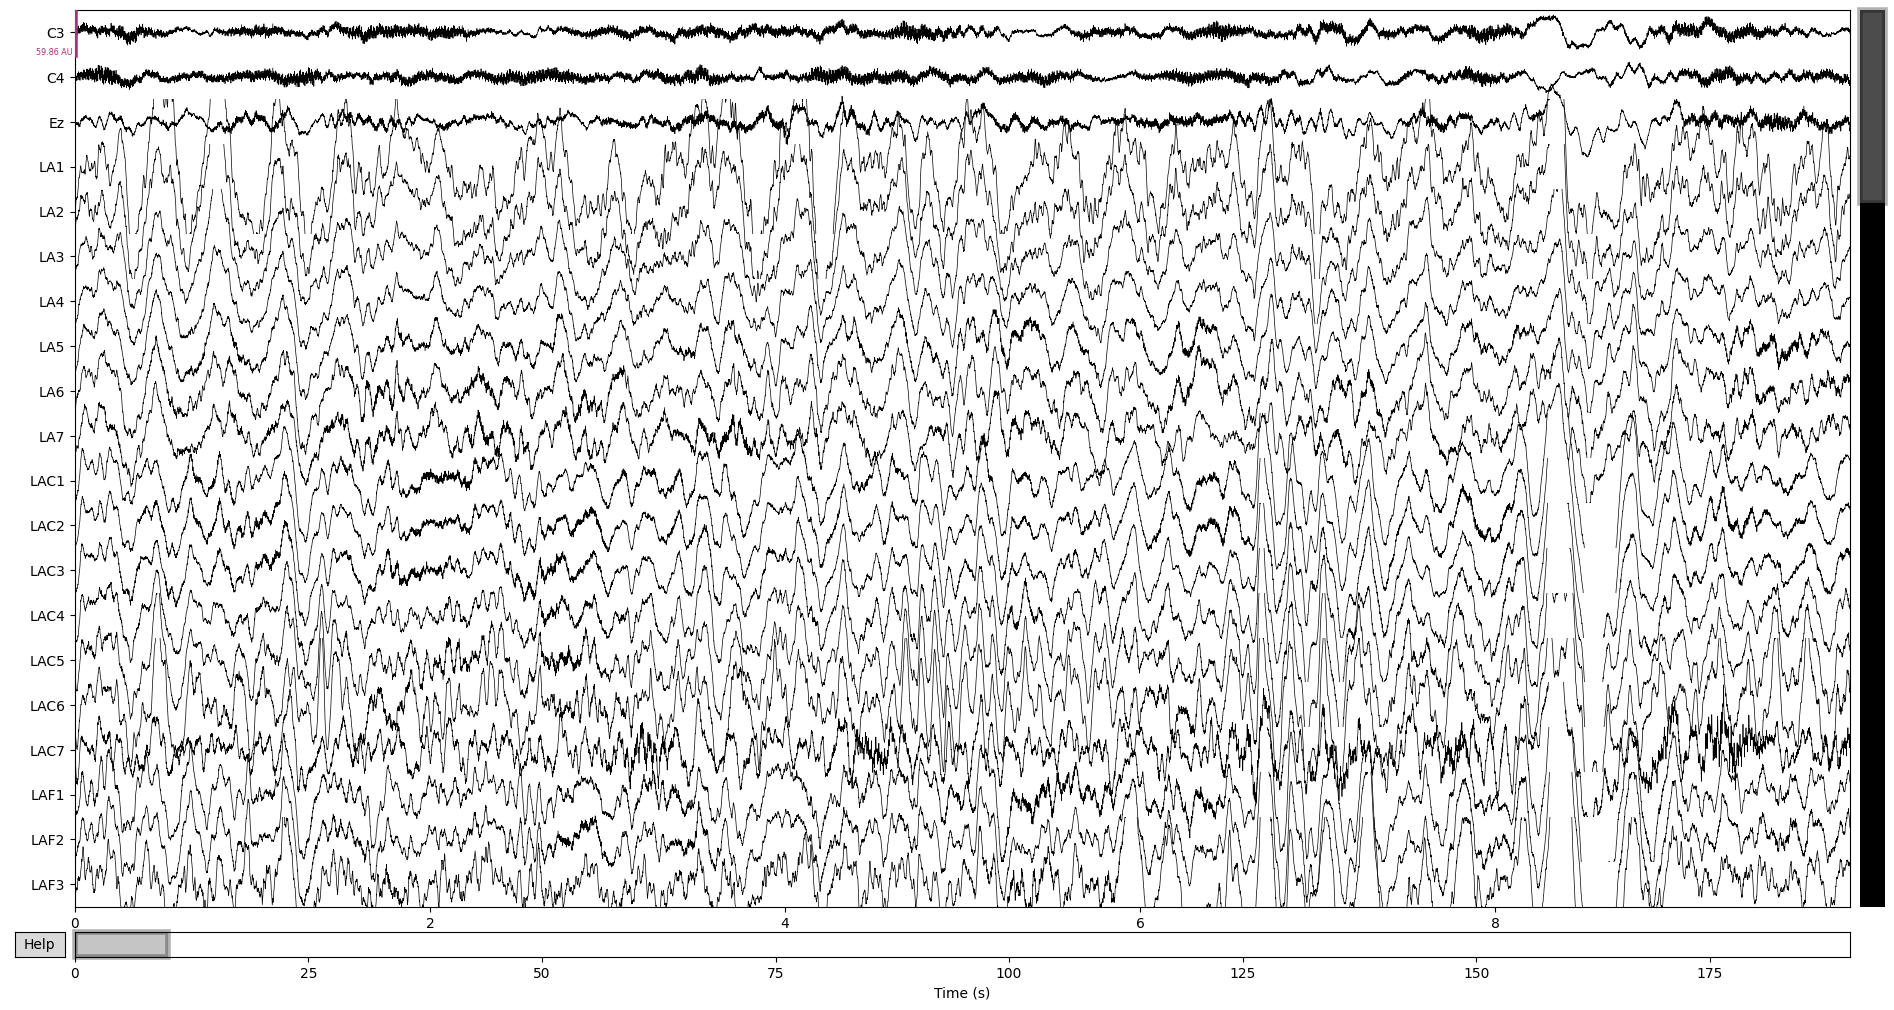

Channels marked as bad: none


In [9]:
%matplotlib qt
raw_debug.plot()

In [10]:
chan_data = raw_debug.pick_channels(['LEC7']).get_data()

In [ ]:
plt.plot(chan_data)

In [1]:
chan_data

NameError: name 'chan_data' is not defined

In [25]:
curr_file = 'C:\\Maya\\p485\\MACRO\\CSC1.mat'
# curr_file = 'C:\Maya\p486\MACRO\CSC52.mat'
f = h5py.File(curr_file, 'r')
data = f.get('data')
data = np.array(data)
p85 = data.T[0]

In [26]:
np.array(f['LocalHeader/samplingRate'])[0][0]

1000.0

In [11]:
data.T.shape

(1, 26051185)

In [15]:
lec7 = data.T[0]

In [27]:
np.min(p85)

nan

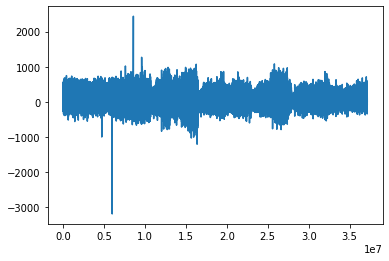

In [28]:
plt.plot(p85)

In [30]:
np.argwhere(np.isnan(p85)).shape


(55889, 1)

In [31]:
p85[np.isnan(p85)] = 0

In [32]:
np.argwhere(np.isnan(p85))


array([], shape=(0, 1), dtype=int64)

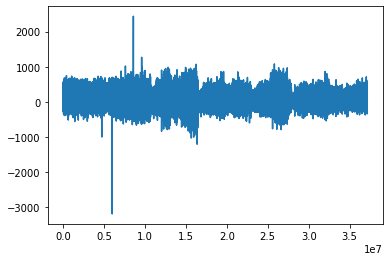

In [33]:
plt.plot(p85)

In [55]:
# counting spikes rates for thesis
edf = 'C:\\Lilach\\%s_for_tag_filtered_fix_tag.edf'
subj = '416'
sr = 1000
channels = ['RAH1', 'RA1']
epochs, epochs_random = [], []
window_size = int(sr / 4)
raw = mne.io.read_raw_edf(edf % subj)
spikes = raw.annotations
spikes_df = pd.DataFrame(spikes)
end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
# spikes_df = spikes_df[spikes_df['description'].str.contains(channels[0][0] + 't')]
# spikes_df = spikes_df.drop_duplicates(subset=['onset'])
complete_spikes_df = spikes_df[spikes_df['onset'] < end_onset]
#
# # from first tags round- only some spikes here and there
random_spikes_df = spikes_df[spikes_df['onset'] > end_onset]
# raw_data = raw.copy().pick_channels(channels).resample(sr).get_data()
# for onset in random_spikes_df['onset']:
#     epochs_random.append(raw_data[:, int(onset * sr - window_size / 2) : int (onset * sr + window_size / 2)].T)
# y_windows_random = np.full(len(epochs_random), 1)
#
# # from second tags round- complete data
# raw_data = raw.crop(tmax=end_onset).pick_channels(channels).resample(sr).get_data()
#
# for i in range(0, raw_data.shape[1], window_size):
#     curr_block = raw_data[:, i: i  + window_size]
#     if i + window_size < raw_data.shape[1]:
#         epochs.append(curr_block.T)
#
# y_windows = np.zeros(len(epochs))
# for onset in complete_spikes_df['onset']:
#     y_windows[int(onset * 1000 / window_size)] = 1

Extracting EDF parameters from C:\Lilach\416_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [56]:
spikes_df

onset  duration description                 orig_time
0     2.0000       0.0    Lt spike 2009-07-22 23:38:30+00:00
1     3.7512       0.0    Lt spike 2009-07-22 23:38:30+00:00
2     5.0870       0.0    Lt spike 2009-07-22 23:38:30+00:00
3     7.7952       0.0    Lt spike 2009-07-22 23:38:30+00:00
4     7.8684       0.0    Rt spike 2009-07-22 23:38:30+00:00
..       ...       ...         ...                       ...
66  403.4695       0.0    Rt spike 2009-07-22 23:38:30+00:00
67  496.9863       0.0    Lt spike 2009-07-22 23:38:30+00:00
68  500.7375       0.0    Lt spike 2009-07-22 23:38:30+00:00
69  936.7786       0.0    Rt spike 2009-07-22 23:38:30+00:00
70  958.3908       0.0    Rt spike 2009-07-22 23:38:30+00:00

[71 rows x 4 columns]

In [57]:
complete_spikes_df

onset  duration description                 orig_time
0     2.0000       0.0    Lt spike 2009-07-22 23:38:30+00:00
1     3.7512       0.0    Lt spike 2009-07-22 23:38:30+00:00
2     5.0870       0.0    Lt spike 2009-07-22 23:38:30+00:00
3     7.7952       0.0    Lt spike 2009-07-22 23:38:30+00:00
4     7.8684       0.0    Rt spike 2009-07-22 23:38:30+00:00
..       ...       ...         ...                       ...
58  183.5830       0.0    Rt spike 2009-07-22 23:38:30+00:00
59  193.3000       0.0    Lt spike 2009-07-22 23:38:30+00:00
60  194.2692       0.0    Rt spike 2009-07-22 23:38:30+00:00
61  195.9000       0.0    Rt spike 2009-07-22 23:38:30+00:00
62  200.1164       0.0    Lt spike 2009-07-22 23:38:30+00:00

[63 rows x 4 columns]

In [61]:
complete_spikes_df[complete_spikes_df['description'].str.contains('Rt')]

onset  duration description                 orig_time
4     7.8684       0.0    Rt spike 2009-07-22 23:38:30+00:00
5     9.4970       0.0    Rt spike 2009-07-22 23:38:30+00:00
7    10.1648       0.0    Rt spike 2009-07-22 23:38:30+00:00
8    11.5555       0.0    Rt spike 2009-07-22 23:38:30+00:00
10   12.4522       0.0    Rt spike 2009-07-22 23:38:30+00:00
15   19.1292       0.0    Rt spike 2009-07-22 23:38:30+00:00
16   20.1896       0.0    Rt spike 2009-07-22 23:38:30+00:00
18   22.1932       0.0    Rt spike 2009-07-22 23:38:30+00:00
22   25.4420       0.0    Rt spike 2009-07-22 23:38:30+00:00
23   25.4613       0.0    Rt spike 2009-07-22 23:38:30+00:00
24   27.0075       0.0    Rt spike 2009-07-22 23:38:30+00:00
26   27.9855       0.0    Rt spike 2009-07-22 23:38:30+00:00
27   28.0157       0.0    Rt spike 2009-07-22 23:38:30+00:00
29   28.9123       0.0    Rt spike 2009-07-22 23:38:30+00:00
31   31.6013       0.0    Rt spike 2009-07-22 23:38:30+00:00
32   62.6131       0.0    Rt spike 2009-07-22 23:38:30+00:00
33   63.8647       0.0    Rt spike 2009-07-22 23:38:30+00:00
35   64.7724       0.0    Rt spike 2009-07-22 23:38:30+00:00
36   67.5738       0.0    Rt spike 2009-07-22 23:38:30+00:00
38   97.7138       0.0    Rt spike 2009-07-22 23:38:30+00:00
39   99.6626       0.0    Rt spike 2009-07-22 23:38:30+00:00
40  102.0441       0.0    Rt spike 2009-07-22 23:38:30+00:00
42  119.6735       0.0    Rt spike 2009-07-22 23:38:30+00:00
43  122.2435       0.0    Rt spike 2009-07-22 23:38:30+00:00
44  127.0000       0.0    Rt spike 2009-07-22 23:38:30+00:00
46  143.0221       0.0    Rt spike 2009-07-22 23:38:30+00:00
47  150.3688       0.0    Rt spike 2009-07-22 23:38:30+00:00
49  154.9160       0.0    Rt spike 2009-07-22 23:38:30+00:00
51  167.4173       0.0    Rt spike 2009-07-22 23:38:30+00:00
52  170.4091       0.0    Rt spike 2009-07-22 23:38:30+00:00
54  171.6534       0.0    Rt spike 2009-07-22 23:38:30+00:00
55  179.6131       0.0    Rt spike 2009-07-22 23:38:30+00:00
56  180.9123       0.0    Rt spike 2009-07-22 23:38:30+00:00
57  182.9343       0.0    Rt spike 2009-07-22 23:38:30+00:00
58  183.5830       0.0    Rt spike 2009-07-22 23:38:30+00:00
60  194.2692       0.0    Rt spike 2009-07-22 23:38:30+00:00
61  195.9000       0.0    Rt spike 2009-07-22 23:38:30+00:00

In [1]:
from visbrain.io.rw_hypno import (read_hypno, oversample_hypno)

subj = '415'
hypno_file = 'D:\\UCLA\\P%s_hypno.txt' % subj
hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)
hypno

Hypnogram successfully loaded (D:\UCLA\P415_hypno.txt)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [9]:
54*60

3240

In [3]:
sf_hypno

1.0

In [6]:
new_hypno, x = read_hypno('C:\\Users\\user\\PycharmProjects\\pythonProject\\hypno_415.csv')

TypeError: object of type 'NoneType' has no len()

In [19]:
hypno_df

Stage          Time
1    Wake   3247.447998
2      N1   4059.312012
3      N2   4630.624023
4      N3   4660.691895
5      N2   4901.244141
..    ...           ...
179    N1  26580.992188
180    N2  26731.339844
181    N1  26821.544922
182    N2  27603.339844
183    N1  27843.996094

[183 rows x 2 columns]

In [16]:

spikes_df

3032
0      6366
1      6803
2      8111
3     13401
4     13620
..      ...
814  109688
815  109819
816  109825
817  111201
818  111221

[819 rows x 1 columns]

In [7]:
# For thesis- spikes per stage
subj = '416'
filename = f'C:\\Users\\user\\PycharmProjects\\pythonProject\\hypno_{subj}.csv'
hypno_df = pd.read_csv(filename, delim_whitespace=True, header=None, names=['Stage', 'Time']).drop([0])
spikes_df = pd.read_csv(f'thesis_depth_lgbm_{subj}.csv')
spike_per_stage = {'Wake': 0, 'N1': 0, 'N2': 0, 'N3': 0, 'REM': 0}
for spike in spikes_df.values:
    spike_sec = spike[0] * 250 / 1000
    if len(hypno_df[hypno_df['Time'] < spike_sec]) == 0:
        spike_per_stage['Wake'] += 1
    else:
        stage_index = len(hypno_df[hypno_df['Time']< spike_sec])
        stage = hypno_df.iloc[stage_index]['Stage']
        spike_per_stage[stage] += 1
spike_per_stage

{'Wake': 382, 'N1': 2081, 'N2': 1196, 'N3': 545, 'REM': 15}

In [44]:
spike_sec

4059.75

In [46]:
len(hypno_df[hypno_df['Time']< spike_sec])

2

In [54]:
hypno_df.iloc[2]['Stage']

'N2'

In [4]:
random_mtrics = joblib.load('depth_shuffle.pkl')

In [6]:
precision_random = [x['precision'] for x in random_mtrics]
# recall_random = [x['recall'] for x in random_mtrics]
accuracy_random = [x['accuracy'] for x in random_mtrics]
f_random = [x['f_score'] for x in random_mtrics]

(0.0, 1.0)

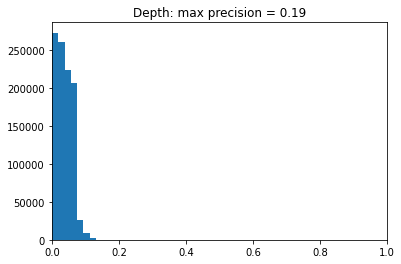

In [7]:
plt.hist(precision_random)
precision_max = '{0:.2f}'.format(max(precision_random))
plt.title('Depth: max precision = {}'.format(precision_max))
plt.xlim(0, 1)

Text(0.040209128985507235, 246443.715, 'Mean: 0.04')

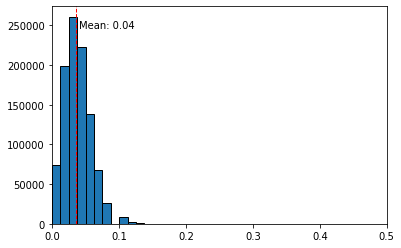

In [25]:
x = np.array(precision_random)
plt.hist(precision_random, bins=15, edgecolor="black")
plt.xlim(0, 0.5)
plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))

Text(0.5, 0, 'Precision')

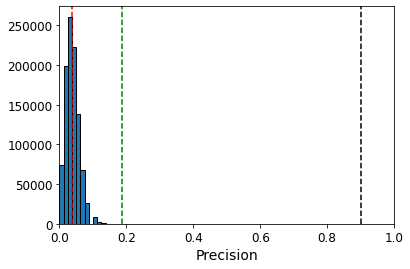

In [52]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'medium'})
x = np.array(precision_random)
plt.hist(precision_random, bins=15, edgecolor="black")
plt.xlim(0, 1)
plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(x.max(), color='green', linestyle='dashed', linewidth=1.5)
plt.axvline(0.9, color='black', linestyle='dashed', linewidth=1.5)
plt.xlabel('Precision', fontsize=14)

Text(0.7536231884057971, 191678.44499999998, 'classifier: 90.00%')

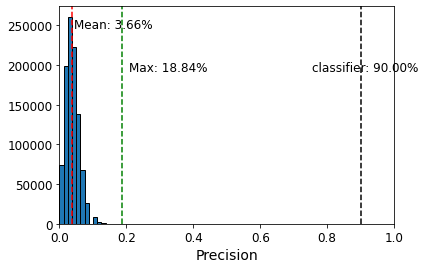

In [51]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'medium'})
x = np.array(precision_random)
plt.hist(precision_random, bins=15, edgecolor="black")
plt.xlim(0, 1)
plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(x.max(), color='green', linestyle='dashed', linewidth=1.5)
plt.axvline(0.9, color='black', linestyle='dashed', linewidth=1.5)
plt.xlabel('Precision', fontsize=14)

# min_ylim, max_ylim = plt.ylim()
# plt.text(x.mean()*1.2, max_ylim*0.9, 'Mean: {:.2f}%'.format(x.mean() * 100))
# plt.text(x.max()*1.1, max_ylim*0.7, 'Max: {:.2f}%'.format(x.max() * 100))
# plt.text(x.max()*4, max_ylim*0.7, 'classifier: {:.2f}%'.format(90))

In [23]:
model = joblib.load('rf_fast.pkl')
imp_rf = pd.DataFrame(pd.read_csv('features_fast.csv').columns[1:])
imp_rf['imp'] = model.feature_importances_
imp_rf = imp_rf.sort_values(by=['imp'], ascending=False)
imp_rf.head(15)

0       imp
11                     abspow  0.066153
55             AH1-AH2_abspow  0.055727
27           abspow_cmin_norm  0.050486
70   AH1-AH2_abspow_cmin_norm  0.047265
44                AH1-AH2_std  0.045735
56      AH1-AH2_std_cmin_norm  0.044956
0                         std  0.026831
72      AH1-AH2_std_pmin_norm  0.023710
12              std_cmin_norm  0.023088
42           abspow_pmin_norm  0.020901
112           A1_bf_cmin_norm  0.019569
114       A1_abspow_cmin_norm  0.019131
113           A1_gf_cmin_norm  0.018285
60    AH1-AH2_hcomp_cmin_norm  0.015586
25               bf_cmin_norm  0.015276

<BarContainer object of 15 artists>

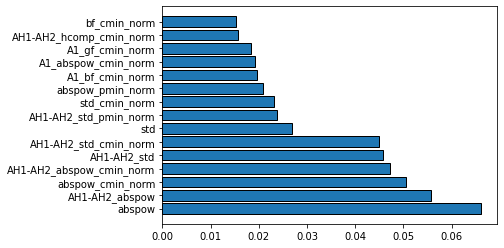

In [24]:
plt.barh(imp_rf.head(15).iloc[:, 0], imp_rf.head(15).iloc[:, 1], edgecolor="black")

In [25]:
model = joblib.load('lgbm_fast.pkl')
imp = pd.DataFrame(pd.read_csv('features_fast.csv').columns[1:])
imp['imp'] = model.feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(15)

0  imp
12             std_cmin_norm   89
0                        std   75
60   AH1-AH2_hcomp_cmin_norm   74
3                       kurt   65
17           hcomp_cmin_norm   62
55            AH1-AH2_abspow   60
47              AH1-AH2_kurt   54
72     AH1-AH2_std_pmin_norm   47
27          abspow_cmin_norm   46
46              AH1-AH2_skew   46
113          A1_gf_cmin_norm   46
31            kurt_pmin_norm   46
11                    abspow   43
2                       skew   42
29             std_pmin_norm   41

<BarContainer object of 15 artists>

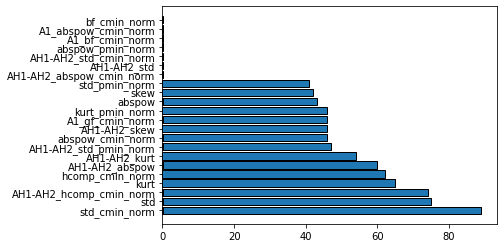

In [29]:
plt.barh(imp.head(15).iloc[:, 0], imp.head(15).iloc[:, 1], edgecolor="black")
plt.barh(imp_rf.head(15).iloc[:, 0], imp_rf.head(15).iloc[:, 1], edgecolor="black")

In [7]:
model_lgbm = joblib.load('thesis_scalp_lgbm.pkl')
imp = pd.DataFrame(model_lgbm.feature_name_)
imp['imp'] = model_lgbm.feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(15)

0  imp
66                 gf_2   76
105      gf_pmin_norm_2   73
28         bf_cmin_norm   61
11                   gf   58
10                   bf   58
39      hcomp_pmin_norm   57
59              hcomp_2   57
9                    sf   57
72    hcomp_cmin_norm_2   56
56               skew_2   54
67      std_cmin_norm_2   53
83       bf_cmin_norm_2   52
65                 bf_2   45
4                 hcomp   45
85   abspow_cmin_norm_2   44

In [9]:
model_rf = joblib.load('thesis_scalp_rf.pkl')
imp = pd.DataFrame(model_lgbm.feature_name_)
imp['imp'] = model_rf.feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(15)

0       imp
76      fast_cmin_norm_2  0.013413
56                skew_2  0.012090
65                  bf_2  0.012027
85    abspow_cmin_norm_2  0.011617
59               hcomp_2  0.011527
82        sf_cmin_norm_2  0.011520
83        bf_cmin_norm_2  0.011331
28          bf_cmin_norm  0.011170
87   higuchi_cmin_norm_2  0.010908
27          sf_cmin_norm  0.010904
72     hcomp_cmin_norm_2  0.010734
1                   skew  0.010638
64                  sf_2  0.010558
67       std_cmin_norm_2  0.010390
106   abspow_pmin_norm_2  0.010367

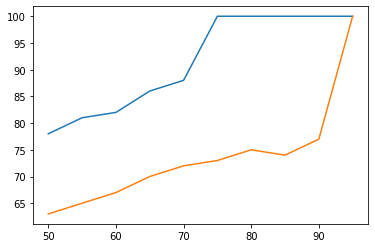

In [8]:
x_ticks = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
y_rf = [78, 81 ,82 ,86, 88 ,100 ,100 , 100, 100, 100]
y_lgbm = [63, 65, 67, 70, 72, 73, 75, 74, 77, 100]
plt.plot(x_ticks, y_rf)
plt.plot(x_ticks, y_lgbm)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


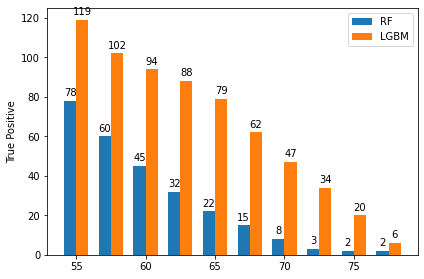

In [27]:
labels = x_ticks
tp_rf = [78, 60, 45, 32, 22, 15, 8, 3, 2, 2]
tp_lgbm = [119, 102, 94, 88, 79, 62, 47, 34, 20, 6]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, tp_rf, width, label='RF')
rects2 = ax.bar(x + width/2, tp_lgbm, width, label='LGBM')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('True Positive')
ax.set_xticklabels(labels)
# ax.set_xticks(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
# ax.plot(x_ticks, y_rf)
# ax.plot(x_ticks, y_lgbm)

fig.tight_layout()

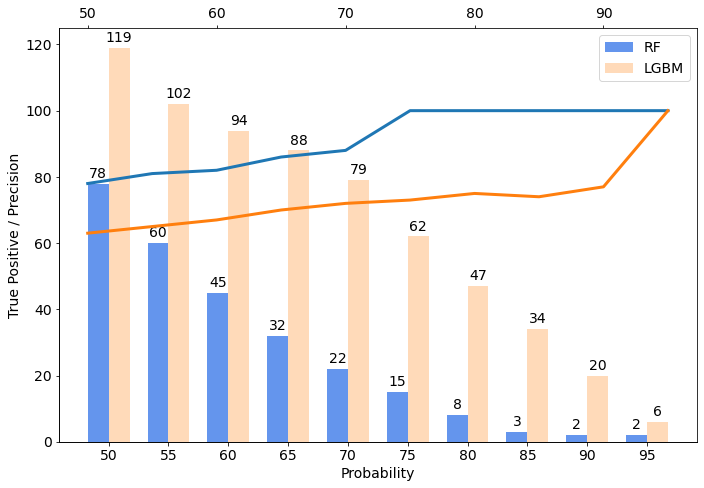

In [65]:
plt.rcParams.update({'font.size': 14, 'font.weight': 'medium'})
labels = x_ticks
tp_rf = [78, 60, 45, 32, 22, 15, 8, 3, 2, 2]
tp_lgbm = [119, 102, 94, 88, 79, 62, 47, 34, 20, 6]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, tp_rf, width, label='RF', color='cornflowerblue')
rects2 = ax.bar(x + width/2, tp_lgbm, width, label='LGBM', color='peachpuff')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('True Positive / Precision')
ax.set_xlabel('Probability')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
# ax.set_xticks(labels)
ax.legend()

ax2 = ax.twiny()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax2.plot(x_ticks, y_rf, linewidth=3)
ax2.plot(x_ticks, y_lgbm, linewidth=3)
# ax2.spines.right.set_visible(False)
# ax2.spines.top.set_visible(False)

fig.tight_layout()

In [17]:
labels

[50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [55]:
subj = '415'
hypno_file = 'D:\\UCLA\\P%s_hypno.txt' % subj
raw = mne.io.read_raw_edf('C:\\UCLA\\P%s_full_filtered.edf' % subj)
png_file_name = subj + '_C3_sbold.png'
raw = raw.pick_channels(['C3'])  # pick electrode for spectrogram
separate_NREM_power_spectrum = True  # set false if you want to see N2 and N3 together as NREM

Extracting EDF parameters from C:\UCLA\P415_full_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Hypnogram successfully loaded (D:\UCLA\P415_hypno.txt)
28-Sep-22 15:24:55 | INFO | Hypnogram successfully loaded (D:\UCLA\P415_hypno.txt)


Not setting metadata
926 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 926 events and 60001 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


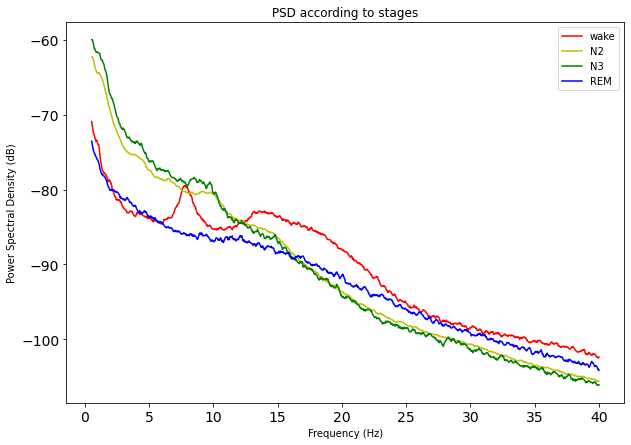

In [59]:
# read hypnogram old format (1sec)
hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)

# make raw object into epochs:
epoch_length = 30  # in seconds
event_id = 1  # This is used to identify the events.
dummy_events = mne.make_fixed_length_events(raw, id=event_id, duration=epoch_length)[:len(hypno)]
dummy_events[:, 2] = hypno  # HERE I TRIMMED THE END OF HYPNOGRAM BECAUSE OF THE DISCREPANCY
event_dict = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'REM': 4, 'art': -1}

# epoch data into 30sec pieces:
epochs = mne.Epochs(raw, events=dummy_events, event_id=event_dict, tmin=0,
                    tmax=30, baseline=(0, 0), on_missing='ignore')

data_out = raw.get_data()
# hypno_up = oversample_hypno(hypno, data_out.shape[1])

stage_spect_trls = [None] * len(event_dict)
stage_spect_avg = [None] * len(event_dict)
stage_spect_std = [None] * len(event_dict)
if separate_NREM_power_spectrum:
    stages_dict = {'W': 0, 'N2': 2, 'N3': 3, 'REM': 4}
else:
    stages_dict = {'W': 0, 'N2': 2, 'REM': 4}

epochs.load_data()
for ind, stage in enumerate(stages_dict):
    if epochs[stage].__len__() > 0:  # if not empty
        if separate_NREM_power_spectrum or stage != 'N2':
            psds, freqs = mne.time_frequency.psd_multitaper(epochs[stage], fmin=0.5, fmax=40, n_jobs=1)
        else:
            psds2, freqs2 = mne.time_frequency.psd_multitaper(epochs[stage], fmin=0.5, fmax=40, n_jobs=1)
            psds3, freqs3 = mne.time_frequency.psd_multitaper(epochs['N3'], fmin=0.5, fmax=40, n_jobs=1)
            psds = np.concatenate((psds2, psds3), axis=0)

        stage_spect_trls[ind] = psds

        psds_mean = psds.mean(0).mean(0)
        psd_db = 10. * np.log10(psds_mean)

        stage_spect_avg[ind] = psd_db

        psds_std = psds.mean(0).std(0)
        stage_spect_std[ind] = psds_std


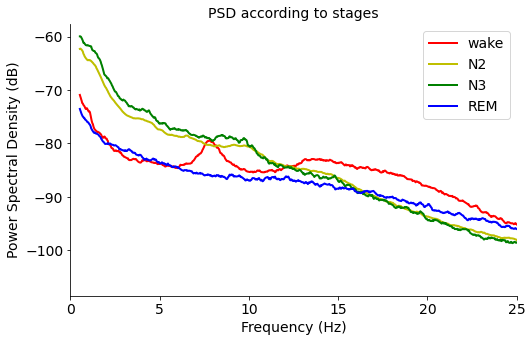

In [63]:
# plotting spectral figures:
stage_color = 'rygbk'
# stages_dict = {key: value for key, value in event_dict.items() if value >= 0}
# stages_dict = {'W': 0, 'N2': 2, 'REM': 4}
# ax2 = spectrogram_fig.add_subplot(gs[2, 0], aspect=0.8)
fig, ax = plt.subplots(figsize=(8, 5))
for i, stage in enumerate(stages_dict):  # runs on stages
    if stage_spect_avg[i] is not None:
        ax.plot(freqs, stage_spect_avg[i], color=stage_color[i], label=stage, linewidth=2)
        plt.fill_between(freqs, stage_spect_avg[i] - stage_spect_std[i], stage_spect_avg[i] + stage_spect_std[i],
                         color=stage_color[i], alpha=.2)


ax.set_title('PSD according to stages', fontsize='14')
ax.set_ylabel('Power Spectral Density (dB)', fontsize='14')
ax.set_xlabel('Frequency (Hz)', fontsize='14')
ax.legend(['wake', 'N2', 'N3', 'REM'] if separate_NREM_power_spectrum else ['wake', 'NREM', 'REM'],
           prop={'size': 14}, loc='upper right')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlim([0, 25])
plt.show()

Extracting EDF parameters from D:\Firas\D044\P44_full_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Opening raw-browser...


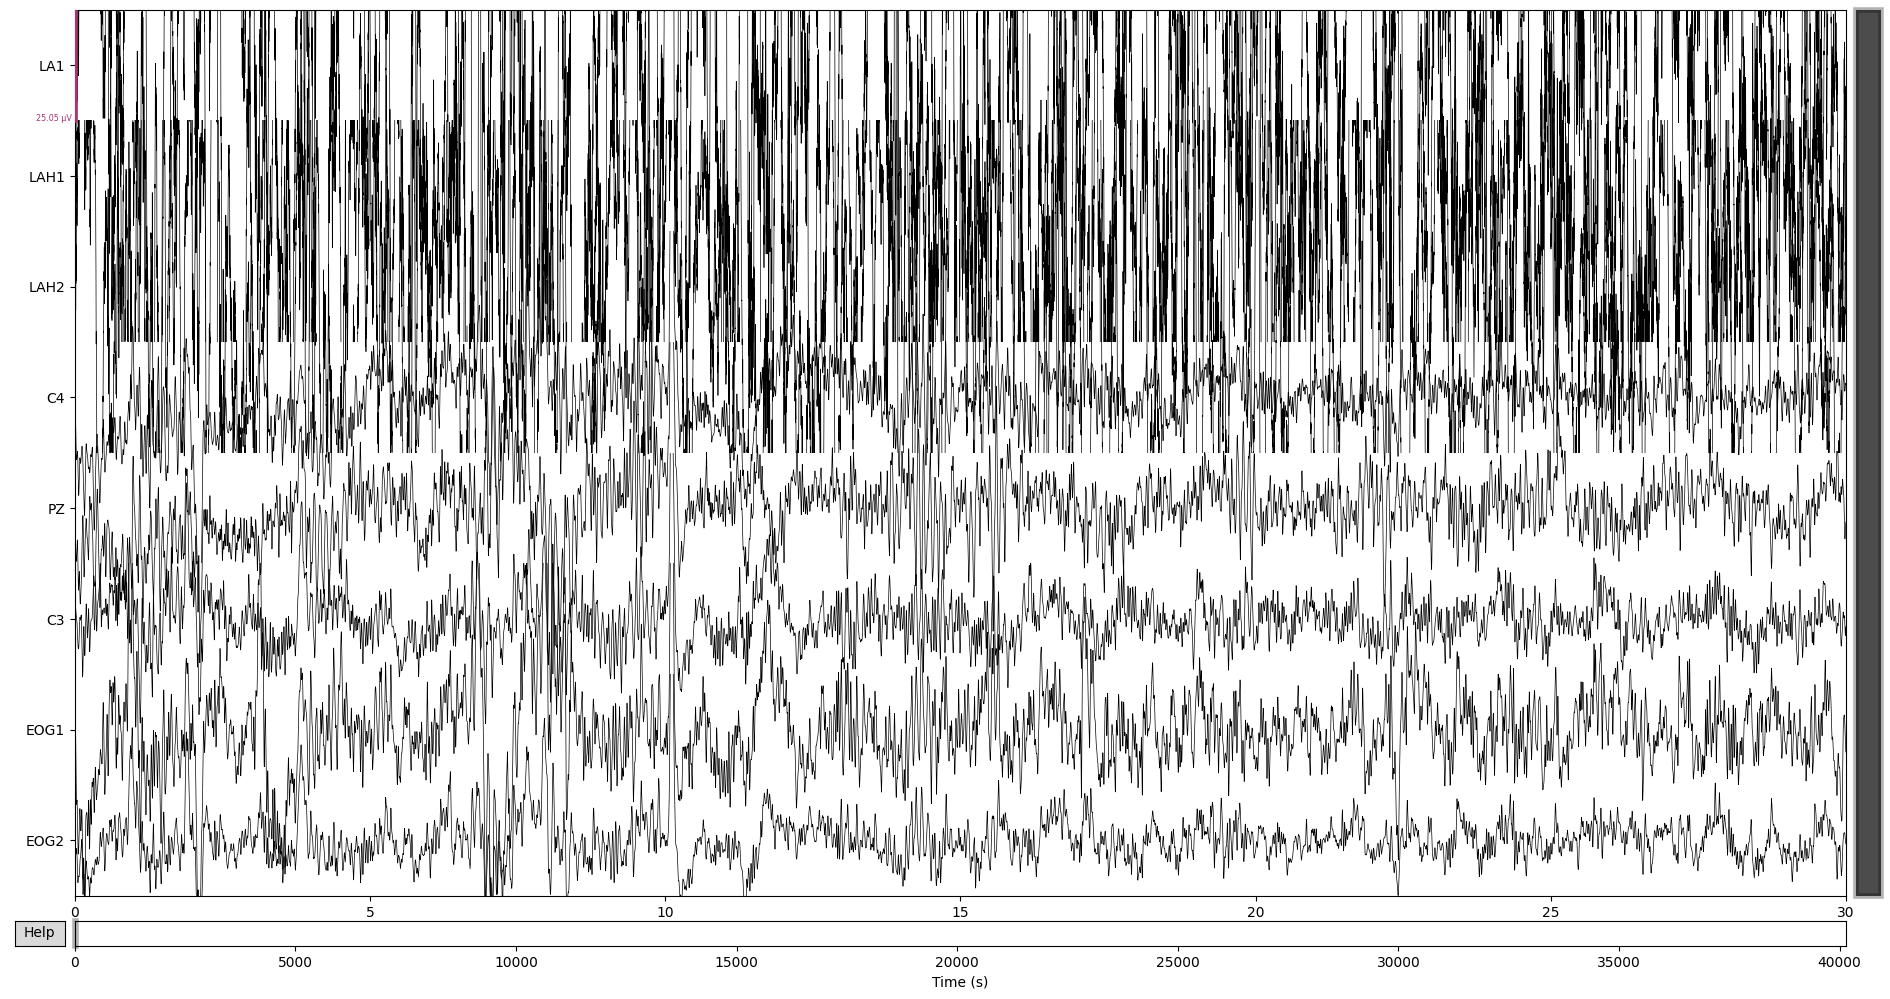

In [5]:
%matplotlib qt

subj= '44'
raw = mne.io.read_raw_edf(f'D:\\Firas\\D0{subj}\\P{subj}_full_filtered.edf')
raw.plot(duration=30, scalings='auto')

In [6]:
ah = raw.pick_channels(['LAH1']).get_data()[0]
ah

array([-6.01941863e-08,  1.82242069e-06,  2.33586111e-06, ...,
        3.36274195e-06,  1.65127388e-06,  2.82099428e-07])

In [22]:
ah_base = mne.baseline.rescale(ah, raw.times, (-1,1), copy=True)
ah_base

Applying baseline correction (mode: mean)


array([-5.80655528e-05, -5.61829380e-05, -5.56694976e-05, ...,
       -5.46426167e-05, -5.63540848e-05, -5.77232592e-05])

In [23]:
plt.plot(ah[:1500])
plt.plot(ah_base[:1500])

In [24]:
plt.plot(ah)
plt.plot(ah_base)

In [30]:
subj= '402'
path = 'C:\\Users\\user\\PycharmProjects\\pythonProject\\%s_clean.edf'
raw = mne.io.read_raw_edf(path % subj)
ah_402 = raw.pick_channels(['LAH1']).get_data()[0]
ah_base_402 = mne.baseline.rescale(ah_402, raw.times, (None,None), copy=True)
plt.plot(ah_402)
plt.plot(ah_base_402)

Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\402_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Applying baseline correction (mode: zscore)


In [29]:
ah_402.mean()

-4.937402651695879e-07

In [28]:
ah_base_402.mean()

-2.0405297993343658e-22

In [32]:
import glob
subjects = ['485', '486', '487', '488', '489', '496', '497']
frontal_stim = ['485', '486', '487', '488', '497', '498', '499', '505', '515', '541', '544', '545']
temporal_stim = ['489', '490', '496', '538']
for subj in subjects:
    subj_files_list = glob.glob(f'C:\\repos\\epileptic_activity\\results\\{subj}*rates*')
    rates_per_chan = {'channel': [], 'n_spikes': []}
    for i, curr_file in enumerate(subj_files_list):
        ch_name = curr_file.split(f'{subj}_')[1].split('_rates')[0]
        chan_rates = pd.read_csv(curr_file, index_col=0)
        rates_per_chan['channel'].append(ch_name)
        rates_per_chan['n_spikes'].append(chan_rates['n_spikes'].sum())

    df = pd.DataFrame(rates_per_chan)
    df.to_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_chan_sum.csv')
    top_10 = df.sort_values(by='n_spikes', ascending=False).iloc[:10, :]['channel'].tolist()
    blocks = []
    for chan in top_10:
        chan_rates = pd.read_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_{chan}_rates.csv', index_col=0)
        y_axis = [chan_rates['rate'][0],  # the previous stop baseline
                  chan_rates['rate_1_20%'][1],
                  chan_rates['rate_2_20%'][1],
                  chan_rates['rate_3_20%'][1],
                  chan_rates['rate_4_20%'][1],
                  chan_rates['rate_5_20%'][1]]
        blocks.append(y_axis)

    avg_df = pd.DataFrame(blocks, columns=['0', '1', '2', '3', '4', '5'])
    means = [avg_df[str(i)].mean() for i in range(0, 6)]
    stds = [avg_df[str(i)].std() for i in range(0, 6)]
    plt.errorbar(list(range(0, 6)), means, yerr=stds, capsize=5, fmt='-o', label='avg', color='black')
    plt.title(f'{subj} - top 10')
    plt.xlabel('Time point')
    plt.ylabel('Spikes per minute')
    plt.savefig(f'C:\\repos\\epileptic_activity\\results\\{subj}_top_10.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [ ]:
# calc rate per chan and plot top ten
import glob
subjects = ['485', '486', '487', '488', '489', '496', '497']
frontal_stim = ['485', '486', '487', '488', '497', '498', '499', '505', '515', '541', '544', '545']
temporal_stim = ['489', '490', '496', '538']
for subj in subjects:
    subj_files_list = glob.glob(f'C:\\repos\\epileptic_activity\\results\\{subj}*rates*')
    rates_per_chan = {'channel': [], 'baseline': [], 'sum': []}
    for i, curr_file in enumerate(subj_files_list):
        ch_name = curr_file.split(f'{subj}_')[1].split('_rates')[0]
        chan_rates = pd.read_csv(curr_file, index_col=0)
        rates_per_chan['channel'].append(ch_name)
        rates_per_chan['baseline'].append(chan_rates['rate'][0])
        rates_per_chan['sum'].append(chan_rates['n_spikes'].sum())

    df = pd.DataFrame(rates_per_chan)
    df.to_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_chan_sum.csv')
    top_10 = df.sort_values(by='baseline', ascending=False).iloc[:10, :]['channel'].tolist()
    blocks = []
    for chan in top_10:
        chan_rates = pd.read_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_{chan}_rates.csv', index_col=0)
        y_axis = [chan_rates['rate'][0],  # the previous stop baseline
                  chan_rates['rate_1_20%'][1],
                  chan_rates['rate_2_20%'][1],
                  chan_rates['rate_3_20%'][1],
                  chan_rates['rate_4_20%'][1],
                  chan_rates['rate_5_20%'][1]]
        blocks.append(y_axis)

    avg_df = pd.DataFrame(blocks, columns=['0', '1', '2', '3', '4', '5'])
    means = [avg_df[str(i)].mean() for i in range(0, 6)]
    stds = [avg_df[str(i)].std() for i in range(0, 6)]
    plt.errorbar(list(range(0, 6)), means, yerr=stds, capsize=5, fmt='-o', label='avg', color='black')
    plt.title(f'{subj} - top 10')
    plt.xlabel('Time point')
    plt.ylabel('Spikes per minute')
    plt.savefig(f'C:\\repos\\epileptic_activity\\results\\{subj}_top_10.png')
    plt.clf()

In [36]:
chan_rates['rate'][0]

18.133313185207573

In [37]:
frontal_stim = ['485', '486', '487', '488', '497', '498', '499', '505', '515', '541', '544', '545']
for subj in subjects:
    # subj_files_list = glob.glob(f'C:\\repos\\epileptic_activity\\results\\{subj}*rates*')
    # rates_per_chan = {'channel': [], 'baseline': [], 'sum': []}
    # for i, curr_file in enumerate(subj_files_list):
    #     ch_name = curr_file.split(f'{subj}_')[1].split('_rates')[0]
    #     chan_rates = pd.read_csv(curr_file, index_col=0)
    #     rates_per_chan['channel'].append(ch_name)
    #     rates_per_chan['baseline'].append(chan_rates['rate'][0])
    #     rates_per_chan['sum'].append(chan_rates['n_spikes'].sum())
    #
    # df = pd.DataFrame(rates_per_chan)
    df = pd.read_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_chan_sum.csv')
    frontal_chans = df[df['channel'].str.contains('F')].tolist()
    blocks = []
    for chan in top_10:
        chan_rates = pd.read_csv(f'C:\\repos\\epileptic_activity\\results\\{subj}_{chan}_rates.csv', index_col=0)
        y_axis = [chan_rates['rate'][0],  # the previous stop baseline
                  chan_rates['rate_1_20%'][1],
                  chan_rates['rate_2_20%'][1],
                  chan_rates['rate_3_20%'][1],
                  chan_rates['rate_4_20%'][1],
                  chan_rates['rate_5_20%'][1]]
        blocks.append(y_axis)

    avg_df = pd.DataFrame(blocks, columns=['0', '1', '2', '3', '4', '5'])
    means = [avg_df[str(i)].mean() for i in range(0, 6)]
    stds = [avg_df[str(i)].std() for i in range(0, 6)]
    plt.errorbar(list(range(0, 6)), means, yerr=stds, capsize=5, fmt='-o', label='avg', color='black')
    plt.title(f'{subj} - top 10')
    plt.xlabel('Time point')
    plt.ylabel('Spikes per minute')
    plt.savefig(f'C:\\repos\\epileptic_activity\\results\\{subj}_top_10.png')
    plt.clf()

{'channel': ['LA1',
  'LA2',
  'LA3',
  'LA4',
  'LA5',
  'LA6',
  'LAH1',
  'LAH2',
  'LAH3',
  'LAH4',
  'LAH5',
  'LAH6',
  'LAH7',
  'LEC1',
  'LEC2',
  'LEC3',
  'LEC4',
  'LEC5',
  'LEC6',
  'LEC7',
  'LOF1',
  'LOF2',
  'LOF3',
  'LOF4',
  'LOF5',
  'LOF6',
  'LOF7',
  'LPHG1',
  'LPHG2',
  'LPHG3',
  'LPHG4',
  'LPHG5',
  'LPHG6',
  'LPHG7',
  'RA1',
  'RA2',
  'RA3',
  'RA4',
  'RA5',
  'RA6',
  'REC1',
  'REC2',
  'REC3',
  'REC4',
  'REC5',
  'REC6',
  'RMH1',
  'RMH2',
  'RMH3',
  'RMH4',
  'RMH5',
  'RMH6',
  'RMH7',
  'ROF1',
  'ROF2',
  'ROF3',
  'ROF4',
  'ROF5',
  'ROF6',
  'ROF7',
  'RPHG1',
  'RPHG2',
  'RPHG3',
  'RPHG4',
  'RPHG5',
  'RPHG6',
  'RPHG7'],
 'n_spikes': [634.0,
  838.0,
  288.0,
  334.0,
  171.0,
  81.0,
  4075.0,
  2993.0,
  1964.0,
  396.0,
  95.0,
  128.0,
  196.0,
  2804.0,
  1999.0,
  2599.0,
  877.0,
  131.0,
  67.0,
  112.0,
  97.0,
  107.0,
  116.0,
  199.0,
  215.0,
  162.0,
  261.0,
  2447.0,
  2852.0,
  3529.0,
  1025.0,
  237.0,
  337.0,
 

In [44]:
frontal_stim = ['485', '486', '487', '488', '497', '498', '499', '505', '515', '541', '544', '545']
df = pd.read_csv(f'C:\\repos\\epileptic_activity\\results\\{frontal_stim[3]}_chan_sum.csv')
df[~df['channel'].str.contains('F')]['channel'].tolist()

['C3',
 'LA1',
 'LA2',
 'LA3',
 'LA4',
 'LA5',
 'LA6',
 'LA7',
 'LPHG1',
 'LPHG2',
 'LPHG3',
 'LPHG4',
 'LPHG5',
 'LPHG6',
 'LPHG7',
 'RA1',
 'RA2',
 'RA3',
 'RA4',
 'RA5',
 'RA6',
 'REC1',
 'REC2',
 'REC3',
 'REC4',
 'REC5',
 'REC6',
 'REC7',
 'RPHG1',
 'RPHG2',
 'RPHG3',
 'RPHG4',
 'RPHG5',
 'RPHG6',
 'RPHG7',
 'RPP1',
 'RPP2',
 'RPP3',
 'RPP4',
 'RPP5',
 'RPP6',
 'RPP7',
 'RPS1',
 'RPS2',
 'RPS3',
 'RPS4',
 'RPS5',
 'RPS6',
 'RPS7',
 'RPT1',
 'RPT2',
 'RPT3',
 'RPT4',
 'RPT5',
 'RPT6']

In [1]:
from PIL import ImageFont, ImageDraw, Image
new_img_list= ['RAH', 'LAH']
new_img = Image.new("L", (1, len(new_img_list)), "white")
new_img.putdata(new_img_list)
new_img.save('out.tif')

In [2]:
import PIL, math
from PIL import ImageFont, ImageDraw, Image

text='RAH1, RAH2'

# Font and colour (best to use fixed-width font)
fnt="lucon.ttf"
textcol=(255,255,255)

# Create image of required dimensions
W,H=1000,1000
im=Image.new("RGB",(W,H))
draw=ImageDraw.Draw(im)

# Search for  font size which will fill image with text
nlett=len(text)
nx,ny=0,0
fsize=int(1.5*H)
while nx*ny<nlett:
    fsize=fsize-1
    font=ImageFont.truetype(fnt, fsize)
    # Just get size of one letter
    # In fixed-width fonts, all characters are the same size
    wint,hint = font.getsize("T")
    ny=math.floor(float(H)/float(hint))
    nx=math.floor(float(W)/float(wint))

dx=W-(nx*wint)
dy=H-(ny*hint)

# Pad out text so it is centred
x0=int(math.floor(float(dx)/2))
y0=int(math.floor(float(dy)/2))

# Draw text onto image
posx,posy=x0,y0
for letter in text:
    if(posx+wint)>W:
        posx=x0
        posy+=hint
    draw.text(xy=(posx,posy),text=letter,fill=textcol,font=font)
    posx+=wint

im.save("Text.png")
im.show()

In [27]:
import mne
edf_path = 'D:\\Maya\\p%s\\P%s_fixed.edf'
subj = '496'
raw = mne.io.read_raw_edf(edf_path % (subj, subj))

Extracting EDF parameters from D:\Maya\p496\P496_fixed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [28]:
import pyprep
for_bad_channels = mne.pick_channels_regexp(raw.ch_names,'RTOP*')
print(for_bad_channels)
for_bad_raw = raw.pick_channels(raw.ch_names[30:61])
prep = pyprep.NoisyChannels(for_bad_raw)
# bad = ransac.find_bad_by_ransac(subj_raw.get_data(), sr, subj_raw.ch_names, [], [])
# Fit prep
# prep_params = {
#     "ref_chs": "eeg",
#     "reref_chs": "eeg",
#     "line_freqs": np.arange(60, sr / 2, 60),
# }
#
# prep = PrepPipeline(subj_raw.copy(), prep_params, mne.channels.make_standard_montage("standard_1005"))
# prep.fit()

[54, 55, 56, 57, 58, 59, 60, 61]
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:   24.3s finished


In [30]:
# prep.find_all_bads()
prep.get_bads()

['RMH6', 'RSO5']

In [20]:
raw.ch_names[for_bad_channels[0]: for_bad_channels[:-1]]

TypeError: slice indices must be integers or None or have an __index__ method

In [8]:
mne.pick_types(raw.info, eeg=True)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

Effective window size : 2.048 (s)


C:\Users\user\AppData\Local\Temp/ipykernel_15548/2852001142.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  subj_raw.plot_psd()


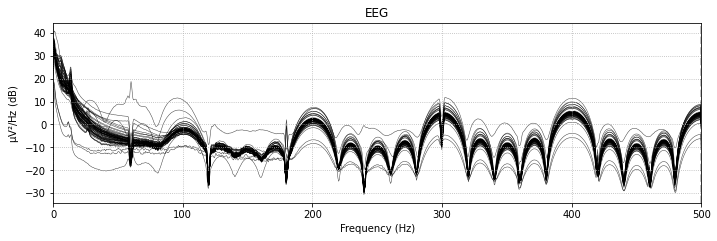

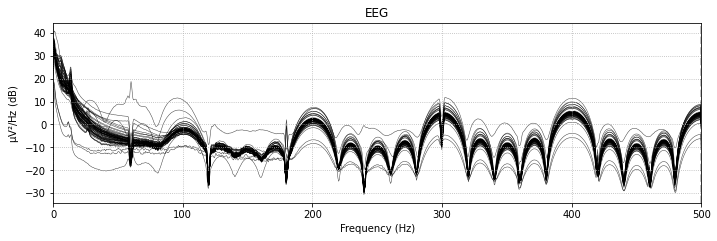

In [10]:
raw.plot_psd()

In [2]:
psd = raw.compute_psd()

Effective window size : 0.256 (s)


In [3]:
psd

<Power Spectrum (from Raw, welch method) | 70 channels × 129 freqs, 0.0-500.0 Hz>

In [4]:
psd[:2]

array([[4.91388454e-13, 3.86889271e-12, 1.34803007e-12, 8.33436585e-13,
        3.31447518e-13, 1.18163977e-13, 8.79232264e-14, 6.50626052e-14,
        5.69453326e-14, 5.58457155e-14, 5.43120789e-14, 5.47886230e-14,
        5.69734658e-14, 5.79976767e-14, 5.86558669e-14, 4.94435559e-14,
        5.49268893e-14, 6.02590863e-14, 5.99398892e-14, 5.82227163e-14,
        5.57791548e-14, 5.48002983e-14, 5.76839752e-14, 7.22064347e-14,
        9.23953180e-14, 1.11477984e-13, 1.15227790e-13, 1.02494811e-13,
        8.24009325e-14, 6.07889059e-14, 3.84799100e-14, 2.76862026e-14,
        4.19071055e-14, 4.59663054e-14, 4.14774440e-14, 3.71131533e-14,
        3.23076465e-14, 3.12557097e-14, 3.36136542e-14, 3.24006465e-14,
        2.77011985e-14, 2.55761894e-14, 2.82673266e-14, 3.01280823e-14,
        3.16217859e-14, 5.13356525e-14, 1.77022810e-13, 7.30788709e-14,
        6.24618623e-14, 1.17492766e-13, 1.80507991e-13, 2.19934722e-13,
        2.15296048e-13, 1.66773609e-13, 9.90729532e-14, 4.323352

C:\Users\user\AppData\Local\Temp/ipykernel_24792/561091968.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


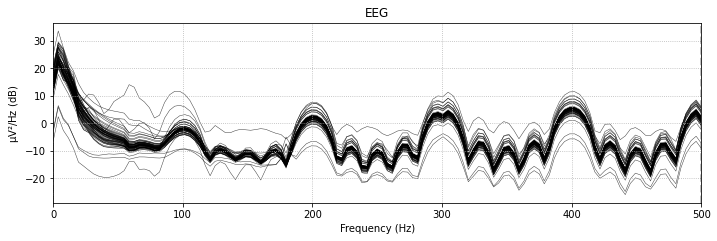

In [5]:
psd.plot()

In [6]:
'cC3'.upper()

'CC3'

Extracting EDF parameters from D:\Maya\p545\P545_fixed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\user\AppData\Local\Temp/ipykernel_29332/1122570662.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin=1, fmax=130)
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


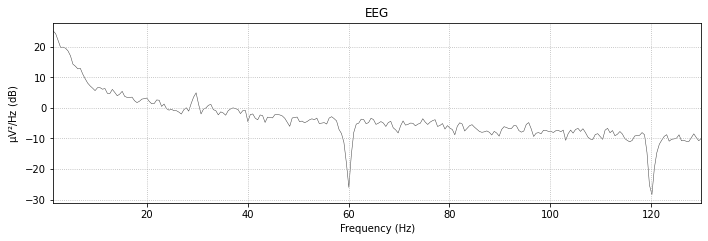

In [3]:
edf_path = 'D:\\Maya\\p%s\\P%s_fixed.edf'
subj = '545'
timing = [2, 14, 20, 24]
channels = ['ROF2']
raw = mne.io.read_raw_edf(edf_path % (subj, subj)).pick_channels(channels).crop(tmax=60)
raw.plot_psd(fmin=1, fmax=130)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.001 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.001 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.001 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.001 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\user\AppData\Local\Temp/ipykernel_29332/2936231884.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.copy().crop(tmin=i, tmax=i+2).plot_psd(fmin=1, fmax=120)
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\user\AppData\Local\Temp/ipykernel_29332/2936231884.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.copy().crop(tmin=i, tmax=i+2).plot_psd(fmin=1, fmax=120)
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\user\AppData\Local\Temp/ipykernel_29332/2936231884.py:2: Runtim

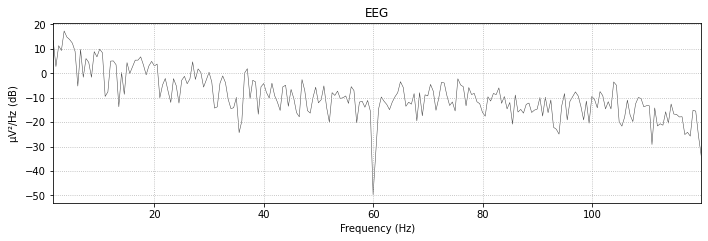

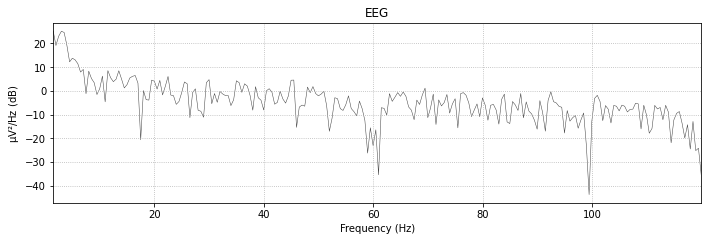

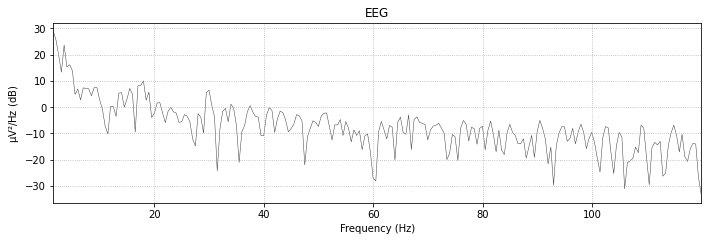

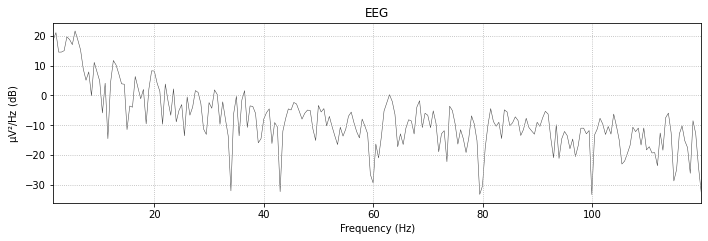

In [30]:
for i in timing:
    raw.copy().crop(tmin=i, tmax=i+2).plot_psd(fmin=1, fmax=120)

In [19]:
# for i in timing:
#     x = raw.copy().crop(tmin=i, tmax=i+2).compute_psd(fmin=1, fmax=120)
# x.get_data()
plt.plot(np.reshape(x.get_data()[0], (1,16)))

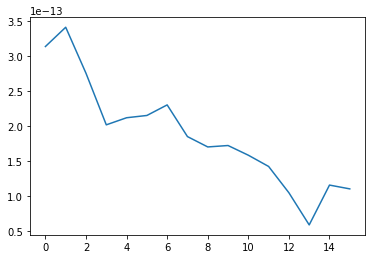

In [23]:
%matplotlib inline
y=list(x.get_data()[0])
y
plt.plot(y)

In [27]:
x = raw.copy().crop(tmin=2, tmax=4).compute_psd(fmin=1, fmax=120)
x

Effective window size : 0.256 (s)


<Power Spectrum (from Raw, welch method) | 1 channels × 30 freqs, 3.9-117.2 Hz>

Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\user\AppData\Local\Temp/ipykernel_29332/3092415589.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  x.plot()
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


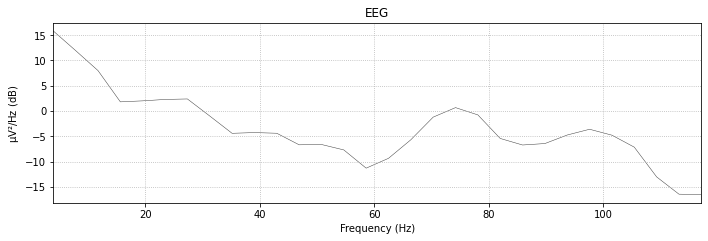

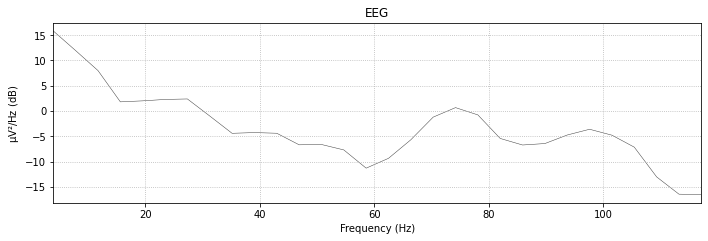

In [28]:
x.plot()

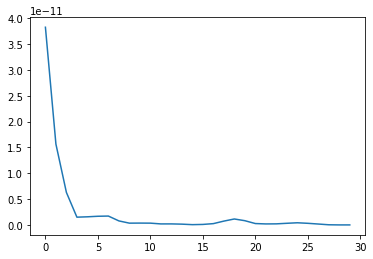

In [29]:
plt.plot(x.get_data()[0])

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.001 (s)


C:\Users\user\AppData\Local\Temp/ipykernel_2340/1018545699.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw2.plot_psd(fmin=70, fmax=130)
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


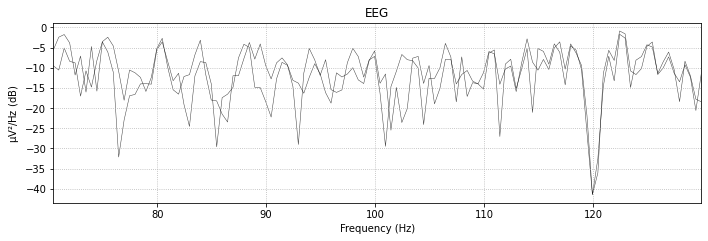

In [48]:
raw2 = raw.copy().crop(tmin=44, tmax=46)
raw2.plot_psd(fmin=70, fmax=130)


Effective window size : 0.256 (s)


C:\Users\user\AppData\Local\Temp/ipykernel_2340/1332143451.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw2.compute_psd(fmin=70, fmax=130).plot()
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


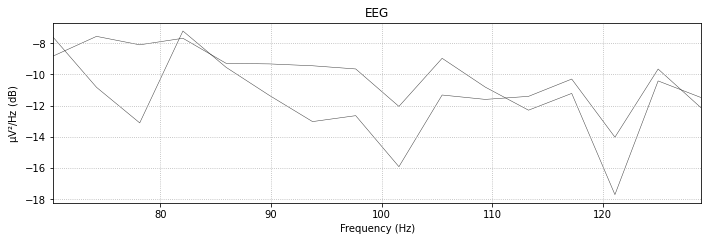

In [46]:
raw2.compute_psd(fmin=70, fmax=130).plot()

In [41]:
raw2.compute_psd(fmin=70, fmax=130).get_data()

Effective window size : 0.256 (s)


array([[4.50310441e-13, 4.34893504e-13, 2.04109464e-13, 1.57188594e-13,
        2.82274143e-13, 3.53506305e-13, 2.93835584e-13, 1.36342428e-13,
        2.55001776e-13, 3.54132551e-13, 1.94319834e-13, 1.09335336e-13,
        9.25238703e-14, 1.00654387e-13, 1.72447084e-13, 4.66068942e-14],
       [4.50035464e-13, 4.85028728e-13, 2.33116132e-13, 1.47711444e-13,
        2.62752372e-13, 2.89576735e-13, 2.83626724e-13, 1.41918379e-13,
        2.80213806e-13, 3.57633481e-13, 1.94160175e-13, 9.02674238e-14,
        7.34324287e-14, 1.24209982e-13, 1.86070154e-13, 4.83289979e-14]])

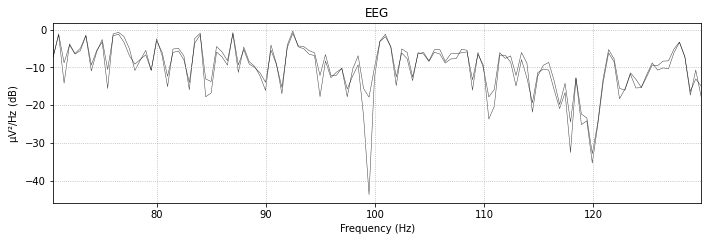

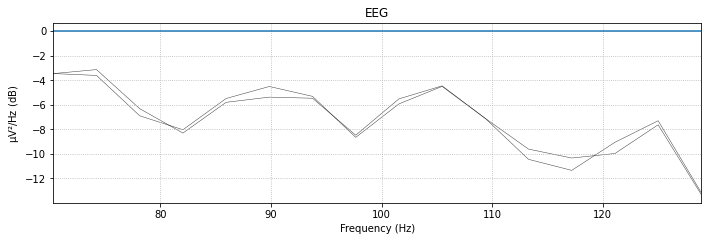

In [42]:
f, Pxx_den = signal.welch(raw2.get_data()[0], 1000, nperseg=256)
plt.plot(f, Pxx_den)
plt.show()

In [8]:
csv_file = 'D:\samples_47.csv'

In [ ]:
with x as reader:
    for chunk in reader:
        print(chunk)

In [10]:
df = pd.read_csv(csv_file ,sep=',', header = None, skiprows=1000, chunksize=1000)
df.read()

KeyboardInterrupt: 

In [15]:
with open(csv_file) as file:
    line = file.readline().strip().split(',')
    print(line)
    line = file.readline().strip().split(',')
    print(len(line), line)
    line = file.readline().strip().split(',')
    print(len(line), line)

['Time in seconds; Amplitude in uV.']
153 ['Sample', 'Time', 'L11-Ref', 'L12-Ref', 'L13-Ref', 'L14-Ref', 'L15-Ref', 'L16-Ref', 'L17-Ref', 'L18-Ref', 'L21-Ref', 'L22-Ref', 'L23-Ref', 'L24-Ref', 'L25-Ref', 'L26-Ref', 'L27-Ref', 'L28-Ref', 'L31-Ref', 'L32-Ref', 'L33-Ref', 'L34-Ref', 'L35-Ref', 'L36-Ref', 'L37-Ref', 'L311-Ref', 'L312-Ref', 'L313-Ref', 'L314-Ref', 'L315-Ref', 'L41-Ref', 'L42-Ref', 'L43-Ref', 'L44-Ref', 'L45-Ref', 'L46-Ref', 'L47-Ref', 'L48-Ref', 'L49-Ref', 'L410-Ref', 'L411-Ref', 'L412-Ref', 'L413-Ref', 'L414-Ref', 'L415-Ref', 'L416-Ref', 'L51-Ref', 'L52-Ref', 'L55-Ref', 'L56-Ref', 'L57-Ref', 'L58-Ref', 'L61-Ref', 'L62-Ref', 'L63-Ref', 'L71-Ref', 'L72-Ref', 'L73-Ref', 'L74-Ref', 'L75-Ref', 'L81-Ref', 'L82-Ref', 'L83-Ref', 'L84-Ref', 'L85-Ref', 'L86-Ref', 'L87-Ref', 'L88-Ref', 'L91-Ref', 'L92-Ref', 'L93-Ref', 'L94-Ref', 'L95-Ref', 'L96-Ref', 'L97-Ref', 'L98-Ref', 'L101-Ref', 'L102-Ref', 'L103-Ref', 'L104-Ref', 'L105-Ref', 'L106-Ref', 'L107-Ref', 'L111-Ref', 'L112-Ref', 'L113

In [17]:
with open(csv_file) as file:
    # first non-important row
    line = file.readline().strip().split(',')
    # channel names
    line = file.readline().strip().split(',')
    df = pd.DataFrame(columns=line)
    # first timestamp
    while line:
        df.loc[len(df)] = line
        line = file.readline().strip().split(',')

    print(df)
    pd.to_pickle('D47.pkl')

KeyboardInterrupt: 

In [19]:
df

Sample      Time   L11-Ref   L12-Ref   L13-Ref   L14-Ref   L15-Ref  \
0       Sample      Time   L11-Ref   L12-Ref   L13-Ref   L14-Ref   L15-Ref   
1            0    0.0000    5.8499   -1.1031   -6.7384  -12.6239   -6.4613   
2            1    0.0039   10.7295   -4.4596  -18.4504  -31.3730  -10.4535   
3            2    0.0078    7.5736   -8.1807  -25.8146  -38.9943   -3.6377   
4            3    0.0117    6.7988  -10.3950  -29.6794  -45.4261    2.8398   
...        ...       ...       ...       ...       ...       ...       ...   
245220  245219  957.8867  -32.1088  -22.9431  -22.8445  -28.4855   -3.4157   
245221  245220  957.8906  -21.9299  -13.7530  -14.7923  -17.3406    8.3671   
245222  245221  957.8945   -6.7407   -1.7474   -4.9610   -7.4371   12.0046   
245223  245222  957.8984    2.3916    4.2654   -1.8377   -3.4486   -3.0086   
245224  245223  957.9023    1.9150    0.8913   -8.3384   -4.9917  -22.4235   

         L16-Ref  L17-Ref  L18-Ref  ...  DC14-Ref  DC15-Ref  DC16-Ref  \
0        L16-Ref  L17-Ref  L18-Ref  ...  DC14-Ref  DC15-Ref  DC16-Ref   
1        -2.3327   1.8346  -4.5771  ...  -13.6016   -4.2141   -8.6714   
2        -6.0471   9.0782  -4.5916  ...  -31.7935  -10.2518  -20.6195   
3       -11.1773  19.6050   5.7572  ...  -36.5495  -11.8422  -23.7856   
4       -20.6830  28.8423  14.0174  ...  -40.3827  -12.7196  -26.0408   
...          ...      ...      ...  ...       ...       ...       ...   
245220    5.9326  -4.4445  -9.5878  ...    0.2385    0.1439    0.1275   
245221   11.6298   8.6448   6.6569  ...   -0.0417   -0.0339    0.1837   
245222   18.1595  16.8927  18.1845  ...    0.1306   -0.0684   -0.0289   
245223   11.2205  13.6933  16.1827  ...   -0.0614   -0.0508   -0.1682   
245224    1.8569  -1.1667   3.4632  ...   -0.2797    0.0229    0.1562   

            TRIG    OSAT-Ref      PR-Ref  Pleth-Ref   Event  Comment    Time  
0           TRIG    OSAT-Ref      PR-Ref  Pleth-Ref   Event  Comment    Time  
1        94.8860  11271.0039  11271.0039     0.0000  0.0000   0.0000  0.0000  
2       147.6831  26585.1406  26585.1406     0.0000  0.0000   0.0000  0.0000  
3       131.2943  30456.9316  30456.9316     0.0000  0.0000   0.0000  0.0000  
4       135.9523  33508.3398  33508.3398     0.0000  0.0000   0.0000  0.0000  
...          ...         ...         ...        ...     ...      ...     ...  
245220  135.5410      0.1203      0.1203     0.0000  0.0000   0.0000  0.0000  
245221  135.5410      0.1203      0.1203     0.0000  0.0000   0.0000  0.0000  
245222  135.5410      0.1203      0.1203     0.0000  0.0000   0.0000  0.0000  
245223  135.5410      0.1203      0.1203     0.0000  0.0000   0.0000  0.0000  
245224  135.5410      0.1203      0.1203     0.0000  0.0000   0.0000  0.0000  

[245225 rows x 153 columns]

In [20]:
pd.to_pickle(df, 'D47_half')

In [1]:
import joblib

lg = joblib.load('validation_models/lgbm_full_1_10_ratio_19.pkl')
lg2 = joblib.load('lgbm_full_1_10_ratio_symmetric_19.pkl')

In [4]:
import pandas as pd
feature_names = pd.DataFrame(lg.feature_name_)
feature_names['imp'] = lg.feature_importances_
feature_imp = feature_names.sort_values(by=['imp'], ascending=False)
feature_imp.head(20)

0  imp
27        ptp  206
54   median_2  170
28      std_2  121
26     median  121
46       gf_2  119
34    hcomp_2  101
18         gf  100
55      ptp_2   99
22     abspow   98
0         std   96
50   abspow_2   93
6       hcomp   80
33     hmob_2   79
17         bf   75
5        hmob   61
15         ag   54
25  petrosian   54
43       ag_2   54
11       beta   54
31     kurt_2   54

In [5]:
feature_names = pd.DataFrame(lg2.feature_name_)
feature_names['imp'] = lg2.feature_importances_
feature_imp = feature_names.sort_values(by=['imp'], ascending=False)
feature_imp.head(20)

0  imp
26    median  279
54  median_2  247
27       ptp  220
55     ptp_2  192
18        gf  115
46      gf_2  113
0        std  104
28     std_2  103
22    abspow  100
50  abspow_2   80
6      hcomp   76
34   hcomp_2   64
43      ag_2   57
33    hmob_2   56
5       hmob   55
15        ag   52
17        bf   52
11      beta   52
45      bf_2   52
39    beta_2   51

In [5]:
import mne
mne.viz.set_browser_backend('qt')
subj = '51'
edf = f'C:\\UCLA\\P{subj}_overnightData.edf'
depth = ['RAH1', 'LAH1', 'RA1', 'LA1', 'LEC1', 'REC1', 'RPHG1', 'LPHG1', 'RMH1', 'LMH1', 'RAH2', 'LAH2', 'RA2', 'LA2', 'LEC2', 'REC2', 'RPHG2', 'LPHG2', 'RMH2', 'LMH2']
scalp = [ 'C3', 'C4', 'PZ', 'EOG1', 'EOG2', 'F4', 'P4', 'F10', 'T10', 'F3', 'P3', 'F9', 'T9', 'CZ']
raw = mne.io.read_raw_edf(edf)
print(raw.ch_names)
raw.pick_channels(depth+scalp)
raw.plot()

Extracting EDF parameters from C:\UCLA\P51_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
['LA1', 'LA2', 'LT2-A3', 'LT2-A4', 'LT2-A5', 'LT2-A6', 'LT2-A7', 'LT2-A8', 'LAH1', 'LAH2', 'LT2-H3', 'LT2-H4', 'LT2-H5', 'LT2-H6', 'LT2-H7', 'LT2-H8', 'LT1-InfAntLesi1', 'LT1-InfAntLesi2', 'LT1-InfAntLesi3', 'LT1-InfAntLesi4', 'LT1-InfAntLesi5', 'LT1-InfAntLesi6', 'LT1-InfAntLesi7', 'LT1-InfAntLesi8', 'LT1-InfAntLesi9', 'LT1-InfAntLesi10', 'LT1-InfPosLesi1', 'LT1-InfPosLesi2', 'LT1-InfPosLesi3', 'LT1-InfPosLesi4', 'LT1-InfPosLesi5', 'LT1-InfPosLesi6', 'LT1-InfPosLesi7', 'LT1-InfPosLesi8', 'LT1-InfPosLesi9', 'LT1-InfPosLesi10', 'LF3-SupAntLesi1', 'LF3-SupAntLesi2', 'LF3-SupAntLesi3', 'LF3-SupAntLesi4', 'LF3-SupAntLesi5', 'LF3-SupAntLesi6', 'LF3-SupAntLesi7', 'LF3-SupAntLesi8', 'LF3-SupAntLesi9', 'LF3-SupAntLesi10', 'LF3-SupAntLesi11', 'LF3-SupAntLesi12', 'LP3-SupPosLesi1', 'LP3-SupPosLesi2', 'LP3-SupPosLesi3', 'LP3-SupPosLesi4', 'LP3-SupPosLe

In [6]:
raw.load_data()
raw.crop(tmax=60*30).notch_filter((50, 100, 150, 200), method='spectrum_fit', phase='zero-double')
raw.plot()
# raw_ref, data = mne.set_eeg_reference(raw, ref_channels=['PZ'])
# raw_ref.plot()

Reading 0 ... 67014015  =      0.000 ... 32721.687 secs...
Removed notch frequencies (Hz):
     50.00 : 5026 windows
    100.00 : 5026 windows
    150.00 : 5026 windows
    200.00 : 5026 windows


In [7]:
raw_ref, data = mne.set_eeg_reference(raw, ref_channels=['PZ'])
raw_ref.plot()

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


In [ ]:
write_edf(f'C:\\UCLA\\P{subj}_full_filtered.edf', raw)


Extracting EDF parameters from C:\UCLA\P404_full_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Hypnogram successfully loaded (D:\UCLA_NREM\P404_hypno.txt)
04-Jun-23 16:28:45 | INFO | Hypnogram successfully loaded (D:\UCLA_NREM\P404_hypno.txt)
04-Jun-23 16:28:45 | WARNING | Hypnogram is SHORTER than data by 12096.00 seconds. Padding hypnogram with last value to match data.size.
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\yasa\plotting.py:218: RuntimeWarning: divide by zero encountered in log10
  Sxx = 10 * np.log10(Sxx)  # Convert uV^2 / Hz --> dB / Hz


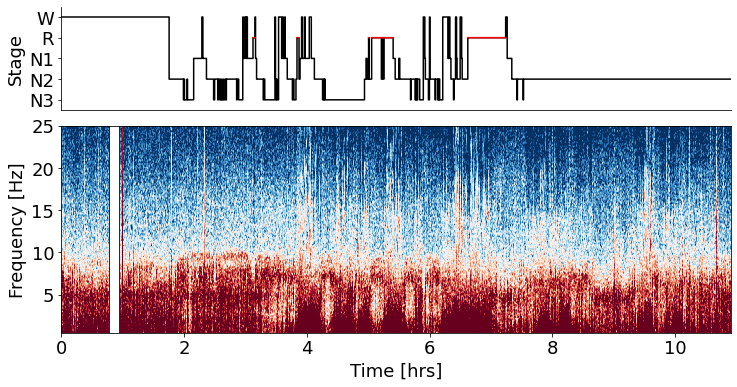

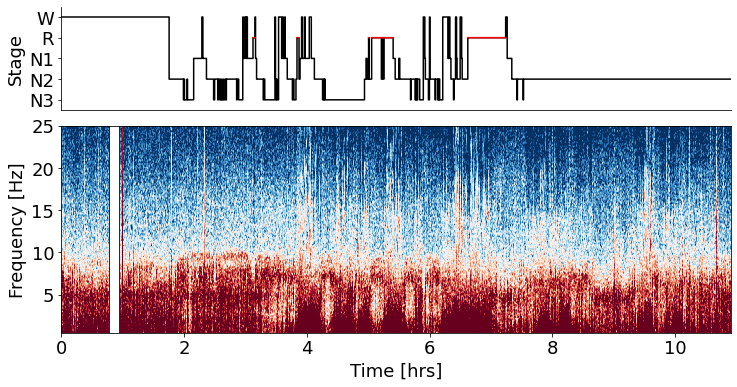

In [13]:
import yasa
subj = '404'
hypno_file = 'D:\\UCLA_NREM\\P%s_hypno.txt' % subj
raw = mne.io.read_raw_edf('C:\\UCLA\\P%s_full_filtered.edf' % subj)
png_file_name = subj + '_C3.png'
raw = raw.pick_channels(['C3'])
data_out = raw.get_data()[0]
hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)
hypno_up = yasa.hypno_upsample_to_data(hypno, sf_hypno=(1/30), data=data_out, sf_data=raw.info['sfreq'])
# spectrogram_fig, gs, ax0, ax1 = plot_spectrogram(
yasa.plot_spectrogram(data_out, raw.info['sfreq'], hypno_up, trimperc=10)

In [20]:
subj = '423'
hypno_file = 'D:\\UCLA_NREM\\P%s_hypno.txt' % subj
raw = mne.io.read_raw_edf('C:\\UCLA\\P%s_full_filtered.edf' % subj)
png_file_name = subj + '_C3.png'
raw = raw.pick_channels(['C3'])
data_out = raw.get_data()[0]
hypno, sf_hypno = read_hypno(hypno_file)
hypno_up = yasa.hypno_upsample_to_data(hypno, sf_hypno=(1/30), data=data_out, sf_data=raw.info['sfreq'])
# spectrogram_fig, gs, ax0, ax1 = plot_spectrogram(
yasa.plot_spectrogram(data_out, raw.info['sfreq'], hypno_up, trimperc=10)

Extracting EDF parameters from C:\UCLA\P423_full_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


TypeError: object of type 'NoneType' has no len()

In [11]:
subj = '013'
depth = ['RAH1', 'LAH1', 'RA1', 'LA1', 'LEC1', 'REC1', 'RPHG1', 'LPHG1', 'RMH1', 'LMH1', 'RAH2', 'LAH2', 'RA2', 'LA2', 'LEC2', 'REC2', 'RPHG2', 'LPHG2', 'RMH2', 'LMH2']
raw = mne.io.read_raw_edf(f'C:\\UCLA\\P{subj}_full_filtered_mtl.edf')
raw.set_channel_types({x: 'eog' for x in ['EOG1', 'EOG2']})
raw.set_channel_types({x: 'seeg' for x in depth if x in raw.ch_names})
raw.plot(duration=30)

Extracting EDF parameters from C:\UCLA\P013_full_filtered_mtl.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [48]:
raw.plot()

In [16]:
raw.annotations.rename({'n': 'BAD_N'})

<Annotations | 74 segments: BAD_N (74)>

In [36]:
output_filename = 'clean_mtl'
nan_raw = new_raw.get_data(reject_by_annotation='NaN')
clean_raw = mne.io.RawArray(nan_raw, raw.info)
write_edf_nan(f'C:\\UCLA\\{subj}_{output_filename}.edf', clean_raw)

Creating RawArray with float64 data, n_channels=11, n_times=30162000
    Range : 0 ... 30161999 =      0.000 ... 30161.999 secs
Ready.


In [44]:
clean_raw.plot()

In [49]:
raw.save(f'C:\\UCLA\\{subj}_clean_mtl_annot.fif', overwrite=True)

Writing C:\UCLA\013_clean_mtl_annot.fif


C:\Users\user\AppData\Local\Temp/ipykernel_4692/2800921666.py:1: RuntimeWarning: This filename (C:\UCLA\013_clean_mtl_annot.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(f'C:\\UCLA\\{subj}_clean_mtl_annot.fif', overwrite=True)


Closing C:\UCLA\013_clean_mtl_annot.fif
[done]


In [47]:
# new_raw = mne.io.read_raw(f'C:\\UCLA\\{subj}_{output_filename}.fif')
new_raw.plot()

ValueError: Row reading not implemented for matrices yet

ValueError: Row reading not implemented for matrices yet

Setting 11874125 of 30162000 (39.37%) samples to NaN, retaining 18287875 (60.63%) samples.


In [30]:
np.nanmean(nan_raw[0])

8.74078149504885e-08

In [31]:
clean[0].mean()

8.740040238460213e-08

In [35]:
from pathlib import Path

def write_edf_nan(fname, raw):
    """Export raw to EDF/BDF file (requires pyEDFlib)."""
    import pyedflib

    suffixes = Path(fname).suffixes
    ext = "".join(suffixes[-1:])
    if ext == ".edf":
        filetype = pyedflib.FILETYPE_EDFPLUS
        dmin, dmax = -32768, 32767
    elif ext == ".bdf":
        filetype = pyedflib.FILETYPE_BDFPLUS
        dmin, dmax = -8388608, 8388607
    data = raw.get_data() * 1e6  # convert to microvolts
    fs = raw.info["sfreq"]
    nchan = raw.info["nchan"]
    ch_names = raw.info["ch_names"]
    if raw.info["meas_date"] is not None:
        meas_date = raw.info["meas_date"]
    else:
        meas_date = None
    prefilter = (f"{raw.info['highpass']}Hz - "
                 f"{raw.info['lowpass']}")
    pmin, pmax = data.min(axis=1), data.max(axis=1)
    f = pyedflib.EdfWriter(fname, nchan, filetype)
    channel_info = []
    data_list = []
    for i in range(nchan):
        channel_info.append(dict(label=ch_names[i],
                                 dimension="uV",
                                 sample_rate=fs,
                                 physical_min=-5000,
                                 physical_max=5000,
                                 digital_min=dmin,
                                 digital_max=dmax,
                                 transducer="",
                                 prefilter=prefilter))
        data_list.append(data[i])
    f.setTechnician("Exported by MNELAB")
    f.setSignalHeaders(channel_info)
    if raw.info["meas_date"] is not None:
        f.setStartdatetime(meas_date)
    # note that currently, only blocks of whole seconds can be written
    f.writeSamples(data_list)
    for annot in raw.annotations:
        f.writeAnnotation(annot["onset"], annot["duration"], annot["description"])

In [39]:
np.nan in nan_raw[0]

False

array([ 9.94045948e-08, -9.10069744e-08, -8.52653216e-07, ...,
                   nan,  9.94045948e-08,  9.94045948e-08])

In [40]:
np.isnan(nan_raw[0]).any()

True

In [41]:
clean[0]

array([ 9.94045930e-08, -9.10069734e-08, -8.52653239e-07, ...,
       -4.71830106e-07,  8.61050858e-07,  9.94045930e-08])

In [ ]:
and not np.isnan(curr_block).any()

In [1]:
import joblib
model = joblib.load('validation_models/lgbm_full_balanced_symmetric_19.pkl')

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
plt.rcParams.update({'font.size': 14, 'font.weight': 'medium'})
plt.figure(figsize=(8,5))
model_lgbm = cls["LGBM"]
model_rf = cls['Random Forest']
testX, testy = X_test_data, y_test
lr_probs = model_lgbm.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, label='LGBM (AUC = 0.993)', color='tab:blue')
lr_probs = model_rf.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
plt.plot(lr_recall, lr_precision, label='RF (AUC = 0.999)', color='tab:orange')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.gca().set_ylim([0.5, 1.05])
plt.gca().set_xlim([0, 1.05])
# show the legend
plt.legend(loc=3, prop={'size': 14})
# show the plot
plt.show()

In [1]:
import h5py
f = h5py.File("D:\Hanna\D017\Micro\denoised_13.mat", 'r')
data = f.get('denoised_data')
data

<HDF5 dataset "denoised_data": shape (38765813, 1), type "<f8">

In [9]:
import numpy as np
import mne
detections = np.load(r"C:\repos\NirsLabProject\NirsLabProject\data\products\p017_MTL\bipolar_model\spikes\p017_MTL_spikes.npz", allow_pickle=True)
peaks = np.load(r"C:\repos\NirsLabProject\NirsLabProject\data\products\p017_MTL\bipolar_model\spikes\peaks-RA1.npz.npy")


depth_onsets = dict(detections)['RA1']
# raw = mne.io.read_raw(r"C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P017_MTL.fif")

# micro file
raw = mne.io.read_raw(r"D:\Hanna\D017\P017_overnightData_LFP_fixed.edf").pick_channels(['RA1', 'RA2', 'RA3', 'RA4', 'RA5', 'RA6', 'RA7', 'RA8'])
# all annot
annot = mne.Annotations(depth_onsets, [0.25] * len(depth_onsets), ['dpeth'] * len(depth_onsets))
raw.set_annotations(annot)
events_mne = np.vstack((peaks.flatten(), np.zeros(len(peaks)), np.full(len(peaks), 1)))
raw.crop(tmin=0, tmax=60*60*3).plot(duration=30, scalings='auto', events=events_mne.T, event_color={1: "r"})


Extracting EDF parameters from D:\Hanna\D017\P017_overnightData_LFP_fixed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [1]:
import numpy as np
import mne
detections = np.load(r"C:\repos\NirsLabProject\NirsLabProject\data\products\p018_MTL\bipolar_model\spikes\p018_MTL_spikes.npz", allow_pickle=True)
peaks = np.load(r"C:\repos\NirsLabProject\NirsLabProject\data\products\p018_MTL\bipolar_model\spikes\peaks-RA2.npz.npy")

depth_onsets = dict(detections)['RA2']

# micro file
raw = mne.io.read_raw(r"D:\Hanna\D018\P018_overnightData_LFP_fixed.edf")
# raw.pick_channels(['RMH1', 'RMH2', 'RMH3', 'RMH4', 'RMH5', 'RMH6', 'RMH7', 'RMH8'])
raw.pick_channels(['RA1', 'RA2', 'RA3', 'RA4', 'RA5', 'RA6', 'RA7', 'RA8'])
# all annot
annot = mne.Annotations(depth_onsets, [0.25] * len(depth_onsets), ['dpeth'] * len(depth_onsets))
raw.set_annotations(annot)
events_mne = np.vstack((peaks.flatten(), np.zeros(len(peaks)), np.full(len(peaks), 1)))
raw.plot(duration=30, scalings='auto', events=events_mne.T, event_color={1: "r"})

Extracting EDF parameters from D:\Hanna\D018\P018_overnightData_LFP_fixed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using qt as 2D backend.


In [2]:
import numpy as np
import mne
detections = np.load(r"C:\repos\NirsLabProject\NirsLabProject\data\products\p025_MTL\bipolar_model\spikes\p025_MTL_spikes.npz", allow_pickle=True)
peaks = np.load(r"C:\repos\NirsLabProject\NirsLabProject\data\products\p025_MTL\bipolar_model\spikes\peaks-LA1.npz.npy")

depth_onsets = dict(detections)['LA1']

# micro file
raw = mne.io.read_raw(r"D:\Hanna\D025\P025_overnightData_LFP_fixed.edf").pick_channels(['LA1', 'LA2', 'LA3', 'LA4', 'LA5', 'LA6', 'LA7', 'LA8'])
# all annot
annot = mne.Annotations(depth_onsets, [0.25] * len(depth_onsets), ['dpeth'] * len(depth_onsets))
raw.set_annotations(annot)
events_mne = np.vstack((peaks.flatten(), np.zeros(len(peaks)), np.full(len(peaks), 1)))
raw.crop(tmin=0, tmax=60*60*3).plot(duration=30, scalings='auto', events=events_mne.T, event_color={1: "r"})

Extracting EDF parameters from D:\Hanna\D025\P025_overnightData_LFP_fixed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
# peaks = np.load(r"C:\repos\NirsLabProject\NirsLabProject\data\products\p017_MTL\bipolar_model\spikes\peaks-RA1.npz.npy")

peaks

array([[ 1933948],
       [ 3710870],
       [ 4253374],
       [ 7057369],
       [ 7256755],
       [ 7623549],
       [ 7734493],
       [ 7943285],
       [ 8596732],
       [ 8798630],
       [ 8800792],
       [ 9465034],
       [ 9607159],
       [ 9633841],
       [ 9672115],
       [ 9734112],
       [ 9797997],
       [ 9962696],
       [ 9976871],
       [10230595],
       [10257590],
       [10528470],
       [10566169],
       [10623371],
       [10970819],
       [11627927],
       [12669741],
       [12793323],
       [13874626],
       [14530415],
       [14544756],
       [14564674],
       [14619603],
       [14722438],
       [14724553],
       [14727210],
       [14748594],
       [14748848],
       [14748976],
       [14759181],
       [14760137],
       [14964357],
       [14989462],
       [14996905],
       [15893574],
       [16212166],
       [16399168],
       [16411415],
       [16412677],
       [16413273],
       [16413477],
       [16416973],
       [1642

In [3]:
import mne
# subj 18 has no RA1-2 so change to 3!!
channels = ['RAH1', 'LAH1', 'RA3', 'LA1', 'LEC1', 'REC1', 'RPHG1', 'LPHG1', 'RMH1', 'LMH1', 'RAH2', 'LAH2', 'RA4', 'LA2', 'LEC2', 'REC2', 'RPHG2', 'LPHG2', 'RMH2', 'LMH2']
# channels = ['RAH1', 'LAH1', 'RA1', 'LA1', 'LEC1', 'REC1', 'RPHG1', 'LPHG1', 'RMH1', 'LMH1', 'RAH2', 'LAH2', 'RA2', 'LA2', 'LEC2', 'REC2', 'RPHG2', 'LPHG2', 'RMH2', 'LMH2']
subj = '018'
raw = mne.io.read_raw(rf"D:\Hanna\D{subj}\P{subj}_overnightData_fixed.edf").pick_channels(channels)
raw.reorder_channels(sorted([x for x in raw.ch_names]))

raw.save(rf"C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P{subj}_MTL.fif")

Extracting EDF parameters from D:\Hanna\D018\P018_overnightData_fixed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Writing C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P018_MTL.fif


C:\Users\user\AppData\Local\Temp/ipykernel_25212/1502360105.py:9: RuntimeWarning: This filename (C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P018_MTL.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(rf"C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P{subj}_MTL.fif")


Closing C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P018_MTL.fif
[done]


In [3]:
import mne
channels = ['LPHG1', 'LPHG8', 'RA3', 'RA4', 'RA8']
subj = '017'
raw = mne.io.read_raw(rf"D:\Hanna\D{subj}\P{subj}_overnightData_LFP_fixed.edf").pick_channels(channels)
raw.reorder_channels(sorted([x for x in raw.ch_names]))

raw.save(rf"C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P{subj}_MTL_LFP.fif")

Extracting EDF parameters from D:\Hanna\D017\P017_overnightData_LFP_fixed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Writing C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P017_MTL_LFP.fif


C:\Users\user\AppData\Local\Temp/ipykernel_7540/2802313450.py:7: RuntimeWarning: This filename (C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P017_MTL_LFP.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(rf"C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P{subj}_MTL_LFP.fif")


Closing C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P017_MTL_LFP.fif
[done]


In [1]:
import mne
channels = ['RA5', 'RA8', 'RMH2', 'RMH4', 'RMH6', 'RMH7']
subj = '018'
raw = mne.io.read_raw(rf"D:\Hanna\D{subj}\P{subj}_overnightData_LFP_fixed.edf").pick_channels(channels)
raw.reorder_channels(sorted([x for x in raw.ch_names]))

raw.save(rf"C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P{subj}_MTL_LFP.fif")

Extracting EDF parameters from D:\Hanna\D018\P018_overnightData_LFP_fixed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Writing C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P018_MTL_LFP.fif


C:\Users\user\AppData\Local\Temp/ipykernel_23640/2009239738.py:7: RuntimeWarning: This filename (C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P018_MTL_LFP.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(rf"C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P{subj}_MTL_LFP.fif")


Closing C:\repos\NirsLabProject\NirsLabProject\data\raw_data\P018_MTL_LFP.fif
[done]


In [5]:
import joblib
y_AH_dict = joblib.load('y_dict_multi_mtl_28.pkl')
rates = {}
for subj in y_AH_dict.keys():
    spikes = y_AH_dict[subj]
    duration_min = len(spikes)/4/60
    print(f'{subj}: n={spikes.sum()}, duration={duration_min/60}h, rate_min={spikes.sum()/duration_min}')
    rates[subj] = spikes.sum()/duration_min

394: n=30051.0, duration=7.972569444444445h, rate_min=62.82165410914158
396: n=8555.0, duration=6.919930555555555h, rate_min=20.604734713538793
398: n=4895.0, duration=4.779722222222222h, rate_min=17.068634857906666
400: n=9231.0, duration=5.011319444444444h, rate_min=30.700497484860662
402: n=3237.0, duration=6.494861111111111h, rate_min=8.306567157795694
404: n=2215.0, duration=8.629305555555556h, rate_min=4.278057652379649
405: n=1938.0, duration=6.498194444444445h, rate_min=4.970611494645949
406: n=10775.0, duration=6.531041666666667h, rate_min=27.496889852945866
414: n=20669.0, duration=7.230833333333334h, rate_min=47.64088970842457
415: n=1130.0, duration=7.610277777777778h, rate_min=2.4747235098733436
416: n=3546.0, duration=7.574513888888889h, rate_min=7.802480907282279
417: n=8127.0, duration=8.585694444444444h, rate_min=15.776242781111993
422: n=8231.0, duration=6.8116666666666665h, rate_min=20.139466601419134
423: n=6296.0, duration=8.06375h, rate_min=13.01296956544205
426: 

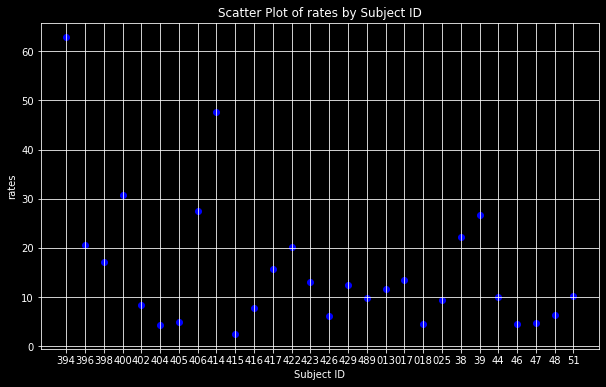

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
tlv = {'44': 'AO0', '46': 'MM1', '47':'SS1', '48':'TA1'}
subject_ids = rates.keys()
scores = rates.values()

plt.figure(figsize=(10, 6))
plt.scatter(subject_ids, scores, color='blue', marker='o')
plt.xlabel('Subject ID')
plt.ylabel('rates')
plt.title('Scatter Plot of rates by Subject ID')
plt.grid(True)
plt.show()

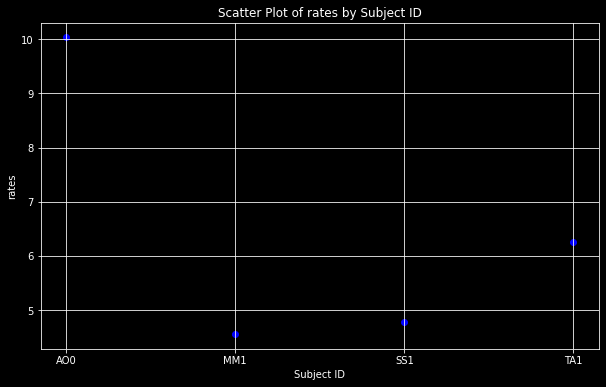

In [10]:
tlv_rates ={tlv[key]:value for key,value in rates.items() if key in tlv.keys()}
subject_ids = tlv_rates.keys()
scores = tlv_rates.values()

plt.figure(figsize=(10, 6))
plt.scatter(subject_ids, scores, color='blue', marker='o')
plt.xlabel('Subject ID')
plt.ylabel('rates')
plt.title('Scatter Plot of rates by Subject ID')
plt.grid(True)
plt.show()

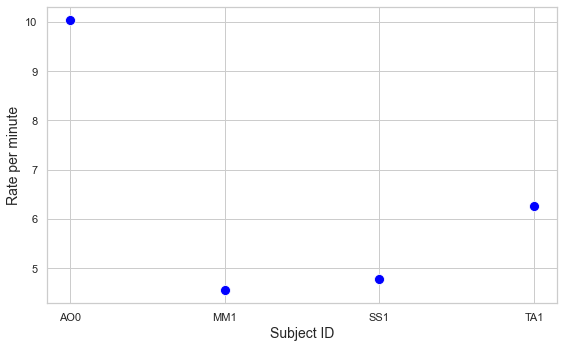

In [13]:
import seaborn as sns

sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=subject_ids, y=scores, color='blue', s=100, marker='o')

# Adding titles and labels
plt.xlabel('Subject ID', fontsize=14)
plt.ylabel('Rate per minute', fontsize=14)

# Display plot
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
df = pd.DataFrame([['Python', 122, 100], ['Calculus', 33, 40]], columns=['Course', 'Oct', 'Nov'])

In [5]:
df

Course  Oct  Nov
0    Python  122  100
1  Calculus   33   40

In [10]:
df.mean(axis=1)

0    111.0
1     36.5
dtype: float64

In [33]:
import mne
subj = '025'
raw = mne.io.read_raw(fr"C:\UCLA\{subj}_clean_mtl_annot.fif")
raw.plot(duration=60 * 5, scalings=dict(eeg=5e-4, eog=4e-4, seeg=5e-4))

Opening raw data file C:\UCLA\025_clean_mtl_annot.fif...


C:\Users\user\AppData\Local\Temp/ipykernel_10548/2663495941.py:3: RuntimeWarning: This filename (C:\UCLA\025_clean_mtl_annot.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(fr"C:\UCLA\{subj}_clean_mtl_annot.fif")


    Range : 0 ... 32258999 =      0.000 ... 32258.999 secs
Ready.


In [30]:
raw.drop_channels(raw.info['bads'], on_missing='ignore')
# raw.plot(duration=60 * 5, scalings=dict(eeg=5e-4, eog=4e-4, seeg=5e-4))

<Raw | 025_clean_mtl_annot.fif, 5 x 32259000 (32259.0 s), ~12 kB, data not loaded>

In [32]:
raw.save(f'C:\\UCLA\\{subj}_clean_mtl_annot1.fif', overwrite=True)

Writing C:\UCLA\025_clean_mtl_annot1.fif


C:\Users\user\AppData\Local\Temp/ipykernel_10548/3589007336.py:1: RuntimeWarning: This filename (C:\UCLA\025_clean_mtl_annot1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(f'C:\\UCLA\\{subj}_clean_mtl_annot1.fif', overwrite=True)


Closing C:\UCLA\025_clean_mtl_annot1.fif
[done]


In [28]:
raw.copy().pick_channels(['EOG1']).get_data()

array([[-1.71697877e-07, -1.03811253e-05, -2.01264884e-05, ...,
        -1.71697877e-07, -1.71697877e-07, -1.71697877e-07]])

In [9]:
groups = np.load(r'C:\repos\NirsLabProject\NirsLabProject\data\products\p487\bipolar_model\features\groups.npy', allow_pickle=True)
groups

array([{'_group': [array([ 2.10000000e+01,  4.87700000e+03,  1.16815998e+00,  2.30000000e+01,
              -3.05750000e+01, -3.32500000e+00, -2.50250000e+01])], 'index': 4870, 'size': 1, 'fist_event_timestamp': 21.0, 'last_event_timestamp': 21.0, 'group_event_duration': 0.0, 'index_to_channel': {4870.0: 'LA1', 4871.0: 'LA2', 4872.0: 'LA3', 4873.0: 'LA4', 4874.0: 'LA5', 4875.0: 'LA6', 4876.0: 'LAH1', 4877.0: 'LAH2', 4878.0: 'LAH3', 4879.0: 'LAH4', 48710.0: 'LAH5', 48711.0: 'LAH6', 48712.0: 'LEC1', 48713.0: 'LEC2', 48714.0: 'LEC3', 48715.0: 'LEC4', 48716.0: 'LEC5', 48717.0: 'LEC6', 48718.0: 'LOF1', 48719.0: 'LOF2', 48720.0: 'LOF3', 48721.0: 'LOF4', 48722.0: 'LOF5', 48723.0: 'LOF6', 48724.0: 'LOF7', 48725.0: 'LPHG1', 48726.0: 'LPHG2', 48727.0: 'LPHG3', 48728.0: 'LPHG4', 48729.0: 'LPHG5', 48730.0: 'LPHG6', 48731.0: 'LSTG1', 48732.0: 'LSTG2', 48733.0: 'LSTG3', 48734.0: 'LSTG4', 48735.0: 'LSTG5', 48736.0: 'LSTG6', 48737.0: 'RA1', 48738.0: 'RA2', 48739.0: 'RA3', 48740.0: 'RA4', 48741.0: 'RA5

In [6]:
flat = np.load(r'C:\repos\NirsLabProject\NirsLabProject\data\products\p487\bipolar_model\features\flat_features.npy', allow_pickle=True)

In [7]:

flat

array([[2.10000000e+01, 4.87700000e+03, 1.16815998e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.87000000e+02],
       [1.45000000e+02, 4.87400000e+03, 2.60443082e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.87000000e+02],
       [2.41000000e+02, 4.87800000e+03, 2.13023798e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.87000000e+02],
       ...,
       [2.95825620e+07, 4.87210000e+04, 1.13049153e+00, ...,
        3.00000000e+00, 0.00000000e+00, 4.87000000e+02],
       [2.95825790e+07, 4.87400000e+03, 1.30671711e+00, ...,
        3.00000000e+00, 0.00000000e+00, 4.87000000e+02],
       [2.95826550e+07, 4.87140000e+04, 1.33491538e+00, ...,
        3.00000000e+00, 0.00000000e+00, 4.87000000e+02]])

In [8]:
pd.DataFrame(flat, columns=['timestamp', 'channel', 'amplitude', 'duration', 'x', 'y', 'z', 'group', 'group_focal', 'group_duration', 'group_size', 'group_depth', 'group_shallow', 'group_spread', 'is_scalp', 'stimuli', 'hypnogram', 'subject'])

timestamp  channel  amplitude  duration         x         y        z  \
0            21.0   4877.0   1.168160      23.0 -30.57500  -3.32500 -25.0250   
1           145.0   4874.0   2.604431      45.0 -44.79175  11.66675 -27.9585   
2           241.0   4878.0   2.130238      29.0 -36.16650  -3.16650 -25.1670   
3           256.0  48721.0   1.285140      24.0 -25.31250  48.06250  -7.9375   
4           299.0  48716.0   3.955079      23.0 -43.50000 -11.29150 -26.2915   
...           ...      ...        ...       ...       ...       ...      ...   
90820  29582316.0   4874.0   1.515738      23.0 -44.79175  11.66675 -27.9585   
90821  29582353.0  48721.0   1.401778      33.0 -25.31250  48.06250  -7.9375   
90822  29582562.0  48721.0   1.130492      25.0 -25.31250  48.06250  -7.9375   
90823  29582579.0   4874.0   1.306717      25.0 -44.79175  11.66675 -27.9585   
90824  29582655.0  48714.0   1.334915      39.0 -32.50000 -11.62500 -26.4165   

            group  group_focal  group_duration  group_size  group_depth  \
0          4870.0       4877.0             0.0         1.0          2.0   
1          4871.0       4874.0            96.0         2.0          3.0   
2          4871.0       4874.0            96.0         2.0          3.0   
3          4872.0      48721.0            43.0         2.0          4.0   
4          4872.0      48721.0            43.0         2.0          4.0   
...           ...          ...             ...         ...          ...   
90820  48749763.0       4874.0            37.0         2.0          4.0   
90821  48749763.0       4874.0            37.0         2.0          4.0   
90822  48749764.0      48721.0            93.0         3.0          3.0   
90823  48749764.0      48721.0            93.0         3.0          3.0   
90824  48749764.0      48721.0            93.0         3.0          3.0   

       group_shallow  group_spread  is_scalp  stimuli  hypnogram  subject  
0                2.0           0.0       0.0      0.0        0.0    487.0  
1                5.0          17.0       0.0      0.0        0.0    487.0  
2                5.0          17.0       0.0      0.0        0.0    487.0  
3                5.0          64.0       0.0      0.0        0.0    487.0  
4                5.0          64.0       0.0      0.0        0.0    487.0  
...              ...           ...       ...      ...        ...      ...  
90820            5.0          45.0       0.0      3.0        0.0    487.0  
90821            5.0          45.0       0.0      3.0        0.0    487.0  
90822            5.0         531.0       0.0      3.0        0.0    487.0  
90823            5.0         531.0       0.0      3.0        0.0    487.0  
90824            5.0         531.0       0.0      3.0        0.0    487.0  

[90825 rows x 18 columns]

In [2]:
import numpy as np

f = open(r"D:\Lior Inna\tg1_HB.bin.lfp", "rb")
a = np.fromfile(f, dtype=np.int16)

In [3]:
plt.plot(a[1e6:1e6 + 1250*10])

TypeError: slice indices must be integers or None or have an __index__ method

In [4]:

a

array([  0,   0,   0, ..., -12, -10,  -8], dtype=int16)

In [5]:
import mne
info = mne.create_info(ch_names=['LFP'], sfreq=1250)
mne_raw = mne.io.RawArray(a.reshape((1, len(a))), info)

Creating RawArray with float64 data, n_channels=1, n_times=107609850
    Range : 0 ... 107609849 =      0.000 ... 86087.879 secs
Ready.


In [6]:
mne_raw.plot(duration=10)

Using qt as 2D backend.


Channels marked as bad:
none


In [6]:
model = joblib.load(r'C:\repos\spikes_notebooks\results\lgbm_AH_only_7.pkl')

In [7]:
a

array([  0,   0,   0, ..., -12, -10,  -8], dtype=int16)

In [28]:
sr = 1000
def bandpower_from_psd_ndarray(psd, freqs, bands, relative=True):
    # Type checks
    assert isinstance(bands, list), 'bands must be a list of tuple(s)'
    assert isinstance(relative, bool), 'relative must be a boolean'

    # Safety checks
    freqs = np.asarray(freqs)
    psd = np.asarray(psd)
    assert freqs.ndim == 1, 'freqs must be a 1-D array of shape (n_freqs,)'
    assert psd.shape[-1] == freqs.shape[-1], 'n_freqs must be last axis of psd'

    # Extract frequencies of interest
    all_freqs = np.hstack([[b[0], b[1]] for b in bands])
    fmin, fmax = min(all_freqs), max(all_freqs)
    idx_good_freq = np.logical_and(freqs >= fmin, freqs <= fmax)
    freqs = freqs[idx_good_freq]
    res = freqs[1] - freqs[0]

    # Trim PSD to frequencies of interest
    psd = psd[..., idx_good_freq]

    # Check if there are negative values in PSD
    if (psd < 0).any():
        msg = (
            "There are negative values in PSD. This will result in incorrect "
            "bandpower values. We highly recommend working with an "
            "all-positive PSD. For more details, please refer to: "
            "https://github.com/raphaelvallat/yasa/issues/29")
        print(msg)

    # Calculate total power
    total_power = simps(psd, dx=res, axis=-1)
    total_power = total_power[np.newaxis, ...]

    # Initialize empty array
    bp = np.zeros((len(bands), *psd.shape[:-1]), dtype=np.float)

    # Enumerate over the frequency bands
    labels = []
    for i, band in enumerate(bands):
        b0, b1, la = band
        labels.append(la)
        idx_band = np.logical_and(freqs >= b0, freqs <= b1)
        bp[i] = simps(psd[..., idx_band], dx=res, axis=-1)

    if relative:
        bp /= total_power
    return bp

def format_raw_night(raw_data):
    epochs = []
    window_size = int(sr / 4)
    # raw_data = mne.io.read_raw(edf).pick_channels([channel])
    if raw_data.info['sfreq'] != sr:
        raw_data.resample(sr)
    raw_data = raw_data.get_data(reject_by_annotation='NaN')[0]

    # normalization
    raw_data = (raw_data - np.nanmean(raw_data)) / np.nanstd(raw_data)
    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i + window_size]
        if i + window_size < len(raw_data) and not np.isnan(curr_block).any():
            epochs.append(curr_block)

    epochs = np.array(epochs)
    return epochs

def calc_features_before_split(epochs, subj):
    # Bandpass filter
    freq_broad = (0.1, 500)
    # FFT & bandpower parameters
    bands = [
        (0.1, 4, 'delta'), (4, 8, 'theta'),
        (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
        (30, 100, 'gamma'), (100, 300, 'fast')
    ]

    # Calculate standard descriptive statistics
    hmob, hcomp = ant.hjorth_params(epochs, axis=1)

    feat = {
        'subj': np.full(len(epochs), subj),
        'epoch_id': np.arange(len(epochs)),
        'std': np.std(epochs, ddof=1, axis=1),
        'iqr': sp_stats.iqr(epochs, axis=1),
        'skew': sp_stats.skew(epochs, axis=1),
        'kurt': sp_stats.kurtosis(epochs, axis=1),
        'nzc': ant.num_zerocross(epochs, axis=1),
        'hmob': hmob,
        'hcomp': hcomp
    }

    # Calculate spectral power features (for EEG + EOG)
    freqs, psd = sp_sig.welch(epochs, sr)
    bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
    for j, (_, _, b) in enumerate(bands):
        feat[b] = bp[j]

    # Add power ratios for EEG
    feat['at'] = feat['alpha'] / feat['theta']
    feat['ag'] = feat['gamma'] / feat['alpha']
    feat['sf'] = feat['sigma'] / feat['fast']
    feat['bf'] = feat['beta'] / feat['fast']
    feat['gf'] = feat['gamma'] / feat['fast']
    # need those?
    feat['gt'] = feat['gamma'] / feat['theta']
    feat['ft'] = feat['fast'] / feat['theta']
    feat['af'] = feat['fast'] / feat['alpha']

    # Add total power
    idx_broad = np.logical_and(
        freqs >= freq_broad[0], freqs <= freq_broad[1])
    dx = freqs[1] - freqs[0]
    feat['abspow'] = np.trapz(psd[:, idx_broad], dx=dx)

    # Calculate entropy and fractal dimension features
    feat['perm'] = np.apply_along_axis(
        ant.perm_entropy, axis=1, arr=epochs, normalize=True)
    feat['higuchi'] = np.apply_along_axis(
        ant.higuchi_fd, axis=1, arr=epochs)
    feat['petrosian'] = ant.petrosian_fd(epochs, axis=1)

    # Convert to dataframe
    feat = pd.DataFrame(feat)

    return feat

def calc_features_after_split(feat):
    # SMOOTHING & NORMALIZATION
    roll1 = feat.rolling(window=1, center=True, min_periods=1, win_type='triang').mean()
    roll1[roll1.columns] = robust_scale(roll1, quantile_range=(5, 95))
    roll1 = roll1.iloc[:, 1:].add_suffix('_cmin_norm')

    roll3 = feat.rolling(window=3, center=True, min_periods=1, win_type='triang').mean()
    roll3[roll3.columns] = robust_scale(roll3, quantile_range=(5, 95))
    roll3 = roll3.iloc[:, 1:].add_suffix('_pmin_norm')

    # Add to current set of features
    feat = feat.join(roll1).join(roll3)
    return feat

In [9]:
mne_raw.resample(1000)

<RawArray | 1 x 86087880 (86087.9 s), ~656.8 MB, data loaded>

In [13]:
epochs = format_raw_night(mne_raw)
epochs

array([[ 1.08538380e-04,  1.08585479e-04,  1.08538396e-04, ...,
         1.08583507e-04,  1.08540368e-04,  1.08583491e-04],
       [ 1.08540384e-04,  1.08583475e-04,  1.08540400e-04, ...,
         1.08581508e-04,  1.08542366e-04,  1.08581492e-04],
       [ 1.08542382e-04,  1.08581476e-04,  1.08542398e-04, ...,
         1.08579515e-04,  1.08544359e-04,  1.08579499e-04],
       ...,
       [ 1.74160252e+00,  1.97952314e+00,  2.17918663e+00, ...,
         6.29168796e-01,  7.11806665e-01,  8.19334188e-01],
       [ 9.09650714e-01,  9.49976412e-01,  9.09899965e-01, ...,
        -7.61232642e-02, -7.74088023e-02, -8.35993407e-02],
       [-1.52982958e-01, -1.82575256e-01, -2.92904981e-01, ...,
         1.32143490e+00,  1.24327281e+00,  1.09677402e+00]])

In [29]:
features = calc_features_after_split(calc_features_before_split(epochs, 'tg1'))
features_names = model.feature_name_
spikes = model.predict(features[features_names])

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [30]:
features.columns

Index(['subj', 'epoch_id', 'std', 'iqr', 'skew', 'kurt', 'nzc', 'hmob',
       'hcomp', 'delta', 'theta', 'alpha', 'sigma', 'beta', 'gamma', 'fast',
       'at', 'ag', 'sf', 'bf', 'gf', 'gt', 'ft', 'af', 'abspow', 'perm',
       'higuchi', 'petrosian', 'std_cmin_norm', 'iqr_cmin_norm',
       'skew_cmin_norm', 'kurt_cmin_norm', 'nzc_cmin_norm', 'hmob_cmin_norm',
       'hcomp_cmin_norm', 'delta_cmin_norm', 'theta_cmin_norm',
       'alpha_cmin_norm', 'sigma_cmin_norm', 'beta_cmin_norm',
       'gamma_cmin_norm', 'fast_cmin_norm', 'at_cmin_norm', 'ag_cmin_norm',
       'sf_cmin_norm', 'bf_cmin_norm', 'gf_cmin_norm', 'gt_cmin_norm',
       'ft_cmin_norm', 'af_cmin_norm', 'abspow_cmin_norm', 'perm_cmin_norm',
       'higuchi_cmin_norm', 'petrosian_cmin_norm', 'std_pmin_norm',
       'iqr_pmin_norm', 'skew_pmin_norm', 'kurt_pmin_norm', 'nzc_pmin_norm',
       'hmob_pmin_norm', 'hcomp_pmin_norm', 'delta_pmin_norm',
       'theta_pmin_norm', 'alpha_pmin_norm', 'sigma_pmin_norm',
       'beta

In [32]:
spikes.sum()

9448.0

In [52]:
prob_spikes = model.predict_proba(features[features_names]).T

In [53]:
prob_spikes

array([[9.99631129e-01, 9.99631129e-01, 9.99631129e-01, ...,
        9.52504064e-01, 9.99985469e-01, 9.99986947e-01],
       [3.68870720e-04, 3.68870720e-04, 3.68870720e-04, ...,
        4.74959362e-02, 1.45311780e-05, 1.30530581e-05]])

In [67]:
y_prob = np.array([p > 0.95 for p in prob_spikes[1]])

In [68]:
sum(y_prob)

2968

In [69]:
onsets = np.where(y_prob == True)[0]
onsets

array([   897,   1391,   1401, ..., 343960, 344029, 344068], dtype=int64)

In [70]:
depth_onsets = [int(x) / 4 for x in onsets]
depth_onsets

[224.25,
 347.75,
 350.25,
 360.5,
 431.25,
 432.0,
 432.5,
 551.75,
 680.25,
 904.0,
 1095.25,
 1444.25,
 1573.75,
 1672.0,
 1748.75,
 1763.5,
 1839.0,
 1917.25,
 2189.5,
 2198.5,
 2201.25,
 2204.5,
 2210.25,
 2484.75,
 2551.0,
 2558.25,
 2593.5,
 2593.75,
 2594.0,
 2594.5,
 2638.5,
 2646.25,
 2664.75,
 2674.25,
 2703.5,
 2709.25,
 2729.5,
 2763.0,
 2776.25,
 2780.75,
 2781.0,
 2781.25,
 2787.25,
 2787.5,
 2791.0,
 2791.75,
 2792.0,
 2792.25,
 2795.25,
 2801.0,
 2805.25,
 2805.75,
 2852.0,
 2855.0,
 2858.25,
 2859.5,
 2861.5,
 2887.0,
 2887.5,
 2898.25,
 2901.75,
 2902.25,
 2903.0,
 2905.25,
 2924.75,
 2944.5,
 2945.25,
 3005.75,
 3042.75,
 3046.75,
 3089.75,
 3096.5,
 3104.75,
 3158.5,
 3194.0,
 3231.0,
 3231.5,
 3240.75,
 3244.0,
 3250.75,
 3352.0,
 3367.5,
 3391.5,
 3392.75,
 3443.0,
 3443.5,
 3446.75,
 3477.25,
 3486.75,
 3528.75,
 3635.25,
 3649.5,
 3673.25,
 3682.25,
 3699.5,
 3749.25,
 3769.0,
 3815.5,
 3838.75,
 3900.0,
 3929.5,
 3966.5,
 3990.5,
 3991.0,
 4003.75,
 4011.0,
 4

In [71]:
annot = mne.Annotations(depth_onsets, [0.25] * len(depth_onsets), ['spike'] * len(depth_onsets))
mne_raw.set_annotations(annot)

<RawArray | 1 x 86087880 (86087.9 s), ~656.8 MB, data loaded>

In [72]:
mne_raw.plot(duration=30, scalings='auto')

In [65]:
annot

<Annotations | 5050 segments: spike (5050)>

In [2]:
f = sio.loadmat(r"D:\Lior Inna\tg1_HB.IIS.mat")
data = np.array(f['iis_manual_pos']).T[0]
data.shape

(172,)

In [3]:
data

array([  3506715,   5075201,   5164873,   5307131,   5379938,   5379938,
         5573751,   5611780,   5865936,   6031948,   6570607,   6570607,
         6652135,   6765433,   6932192,   6988285,   6988285,   7861862,
         7861862,   8268857,   8268857,   8287281,   8916272,   9172928,
         9413420,   9413420,   9427739,   9427739,  10937212,  11651811,
        12135270,  12540742,  15622322,  15832674,  16452262,  16452262,
        16622015,  16703442,  17806182,  17815709,  18314732,  19242526,
        22661965,  23778441,  23778441,  23783643,  23783643,  23789262,
        23789262,  23926501,  24194175,  24573108,  24573108,  24792702,
        27104085,  27572463,  27572463,  28159297,  28975249,  29006582,
        29075851,  29199983,  29204200,  29213490,  31684184,  32553772,
        33936398,  34095349,  34744372,  35025304,  35027309,  35089673,
        35355790,  35431129,  35457758,  35463764,  35463764,  35482492,
        35482492,  36321268,  36622415,  36622415, 

In [92]:
raw = mne.io.read_raw("D:\SleepEEGpy\sleepEEGpy example dataset\EL3001_SLEEP_20220208_112553.mff")

Reading EGI MFF Header from D:\SleepEEGpy\sleepEEGpy example dataset\EL3001_SLEEP_20220208_112553.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...


In [93]:
raw

<RawMff | signal1.bin, 269 x 23942430 (23942.4 s), ~363 kB, data not loaded>

In [94]:
raw.plot()

Channels marked as bad:
none


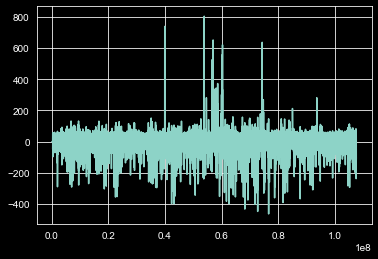

In [5]:
f = open(r"D:\Lior Inna\tg1_HB.bin.lfp", "rb")
a = np.fromfile(f, dtype=np.int16)
plt.plot(a)

In [56]:
import mne
subj = '417'
path = rf"D:\UCLA\P{subj}_overnightData.edf"
# path = rf"D:\Maya\p{subj}\P{subj}_fixed.edf"
raw = mne.io.read_raw_edf(path)
raw.plot(duration=20, scalings=dict(eeg=5e-4, eog=4e-4, seeg=5e-4))

Extracting EDF parameters from D:\UCLA\P417_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [57]:
# save info.bads to txt file
import numpy as np
np.savetxt(rf'D:\Ofer_backup\bad_channels\p{subj}_bad_channels.txt', raw.info['bads'], fmt='%s')


In [2]:
import mne
raw = mne.io.read_raw(r"D:\P485_for_tag_lilach_A.e")

ValueError: Unsupported file type (.e). Consider using a dedicated reader function for more options.

Hypnogram successfully loaded (D:\TLV\P013.txt)


ValueError: 'steps' is not a valid value for ls; supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

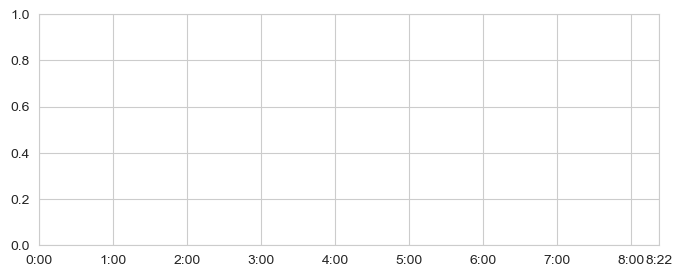

In [1]:
from visbrain.io.rw_hypno import (read_hypno, oversample_hypno)
from visbrain.io import write_fig_hyp
subj = '013'
hypno_file = 'D:\\TLV\\P%s.txt' % subj
# read hypnogram old format (1sec)
hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)

# plot the hypnogram nicely optional to save a file:
write_fig_hyp(hypno, sf_hypno, grid=True, ascolor=True, file=None)

In [28]:
import mne_features
from mne_features.feature_extraction import extract_features
import antropy as ant
import scipy.stats as sp_stats
import time
import mne
import joblib
import numpy as np
import pandas as pd

mtl_path = 'C:\\clean_zeeg\\P%s_mtl_clean.fif'
depth_channels = ['RAH1', 'LAH1', 'RA1', 'LA1', 'LEC1', 'REC1', 'RPHG1', 'LPHG1', 'RMH1', 'LMH1', 'LH1', 'RH1', 'RA3'
                  'RAH2', 'LAH2', 'RA2', 'LA2', 'LEC2', 'REC2', 'RPHG2', 'LPHG2', 'RMH2', 'LMH2', 'LH2', 'RH2']
model = joblib.load(r'C:\repos\depth_ieds\paper\model_V6_90_10.pkl')
depth_model, feature_names = model['model'], model['features']

def extract_epochs_top_features(epochs, subj, sr):
    # Record the start time
    start_time = time.time()

    mobility, complexity = ant.hjorth_params(epochs, axis=1)
    feat = {
        'subj': np.full(len(epochs), subj),
        'epoch_id': np.arange(len(epochs)),
        'kurtosis': sp_stats.kurtosis(epochs, axis=1),
        'hjorth_mobility': mobility,
        'hjorth_complexity': complexity,
        'ptp_amp': np.ptp(epochs, axis=1),
        'samp_entropy': np.apply_along_axis(ant.sample_entropy, axis=1, arr=epochs)
    }

    # selected_funcs = ['teager_kaiser_energy']
    # X_new = extract_features(np.array(epochs)[:, np.newaxis, :], sr, selected_funcs, return_as_df=True)
    kaiser = mne_features.univariate.compute_teager_kaiser_energy(np.array(epochs))

    # Reshape the list into a 2D array with 12 columns (each row will have 12 values)
    reshaped_list = np.array(kaiser).reshape(-1, 12)

    # Create the DataFrame
    X_new = pd.DataFrame(reshaped_list)
    # rename columns
    X_new.columns = [
        f'teager_kaiser_energy_{i}_mean' if j % 2 == 0 else f'teager_kaiser_energy_{i}_std'
        for i in range(6) for j in range(2)
    ]

    # Convert to dataframe
    feat = pd.DataFrame(feat)
    feat = pd.concat([feat, X_new], axis=1)

    # Record the end time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Feature extraction took {:.2f} seconds".format(elapsed_time))
    return feat

def raw_chan_to_feat(raw, chan, subj):
    epochs = []
    window_size = 250
    if chan not in raw.ch_names:
        return pd.DataFrame()
    chan_raw = raw.copy().pick([chan]).get_data(reject_by_annotation='NaN').flatten()
    # normalize chan
    chan_norm = (chan_raw - np.nanmean(chan_raw)) / np.nanstd(chan_raw)
    # run on all 250ms epochs (exclude last second)
    for i in range(0, len(chan_norm) - 4 * window_size, window_size):
        if not np.isnan(chan_norm[i: i + window_size]).any():
            epochs.append(chan_norm[i: i + window_size])

    curr_feat = extract_epochs_top_features(epochs, subj, raw.info['sfreq'])
    chan_feat = {
        'chan_name': chan,
        'chan_ptp': np.ptp(chan_norm),
        'chan_skew': sp_stats.skew(chan_norm),
        'chan_kurt': sp_stats.kurtosis(chan_norm),
    }

    for feat in chan_feat.keys():
        curr_feat[feat] = chan_feat[feat]

    return curr_feat


def get_depth_pred_unbalanced(subjects):
    y_all = np.empty(0)
    for subj in subjects:
        raw = mne.io.read_raw(mtl_path % subj)
        curr_chans = [chan for chan in raw.ch_names if chan in depth_channels]
        y_curr = None
        for chan in curr_chans:
            curr_feat = raw_chan_to_feat(raw, chan, subj)
            predictions = depth_model.predict_proba(curr_feat[feature_names])
            print(sum((predictions[:, 1] >= 0.8).astype(int)), chan)
            if y_curr is None:
                y_curr = (predictions[:, 1] >= 0.8).astype(int)
            else:
                y_curr += (predictions[:, 1] >= 0.8).astype(int)

        # at least 2 channels should be above threshold
        # y_curr[y_curr == 1] = 0
        y_curr[y_curr > 1] = 1
        y_all = np.concatenate((y_all, y_curr))
        print('all', sum(y_all))

    return y_all

In [29]:
subj_name = {'44': 'AO0', '46': 'MM1', '47': 'SS1', '48': 'TA1', '49': 'MF7'}
ratios = {}
# calc ratio per subject
for subj in subj_name:
    y_subj = get_depth_pred_unbalanced([subj])
    ratios[subj_name[subj]] = sum(y_subj) / len(y_subj)

sorted(ratios.items(), key=lambda x: x[1])

Opening raw data file C:\clean_zeeg\P44_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\1571591394.py:87: RuntimeWarning: This filename (C:\clean_zeeg\P44_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(mtl_path % subj)


Isotrak not found
    Range : 0 ... 31556999 =      0.000 ... 31556.999 secs
Ready.
Opening raw data file C:\clean_zeeg\P44_mtl_clean-1.fif...
Isotrak not found
    Range : 31557000 ... 40141999 =  31557.000 ... 40141.999 secs
Ready.
Setting 6065761 of 40142000 (15.11%) samples to NaN, retaining 34076239 (84.89%) samples.
Feature extraction took 21.80 seconds
906 LA1
Setting 6065761 of 40142000 (15.11%) samples to NaN, retaining 34076239 (84.89%) samples.
Feature extraction took 20.48 seconds
824 LA2
Setting 6065761 of 40142000 (15.11%) samples to NaN, retaining 34076239 (84.89%) samples.
Feature extraction took 20.96 seconds
504 LEC1
Setting 6065761 of 40142000 (15.11%) samples to NaN, retaining 34076239 (84.89%) samples.
Feature extraction took 20.55 seconds
252 LEC2
Setting 6065761 of 40142000 (15.11%) samples to NaN, retaining 34076239 (84.89%) samples.
Feature extraction took 20.68 seconds
2903 LAH1
Setting 6065761 of 40142000 (15.11%) samples to NaN, retaining 34076239 (84.89%) s

C:\Users\user\AppData\Local\Temp\ipykernel_19528\1571591394.py:87: RuntimeWarning: This filename (C:\clean_zeeg\P46_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(mtl_path % subj)


Isotrak not found
    Range : 0 ... 36135999 =      0.000 ... 36135.999 secs
Ready.
Setting 5851349 of 36136000 (16.19%) samples to NaN, retaining 30284651 (83.81%) samples.
Feature extraction took 17.98 seconds
217 LAH1
Setting 5851349 of 36136000 (16.19%) samples to NaN, retaining 30284651 (83.81%) samples.
Feature extraction took 18.03 seconds
411 LAH2
all 469.0
Opening raw data file C:\clean_zeeg\P47_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\1571591394.py:87: RuntimeWarning: This filename (C:\clean_zeeg\P47_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(mtl_path % subj)


Isotrak not found
    Range : 0 ... 24385999 =      0.000 ... 24385.999 secs
Ready.
Opening raw data file C:\clean_zeeg\P47_mtl_clean-1.fif...
Isotrak not found
    Range : 24386000 ... 35360999 =  24386.000 ... 35360.999 secs
Ready.
Setting 3267661 of 35361000 (9.24%) samples to NaN, retaining 32093339 (90.76%) samples.
Feature extraction took 19.05 seconds
100 LA1
Setting 3267661 of 35361000 (9.24%) samples to NaN, retaining 32093339 (90.76%) samples.
Feature extraction took 19.76 seconds
10 LA2
Setting 3267661 of 35361000 (9.24%) samples to NaN, retaining 32093339 (90.76%) samples.
Feature extraction took 19.34 seconds
10 LEC1
Setting 3267661 of 35361000 (9.24%) samples to NaN, retaining 32093339 (90.76%) samples.
Feature extraction took 19.49 seconds
8 LEC2
Setting 3267661 of 35361000 (9.24%) samples to NaN, retaining 32093339 (90.76%) samples.
Feature extraction took 22.16 seconds
10 LPHG1
Setting 3267661 of 35361000 (9.24%) samples to NaN, retaining 32093339 (90.76%) samples.
Fea

KeyboardInterrupt: 

In [13]:
sorted_ratios = sorted(ratios.items(), key=lambda x: x[1])
sorted_ratios

[('SS1', 0.002166340676552869),
 ('MM1', 0.0038760650914470367),
 ('MF7', 0.004179296408560669),
 ('TA1', 0.012784639700286834),
 ('AO0', 0.031878072618513976)]

In [23]:
# Rename fifs
import os
import mne

# Define the folder containing the FIF files
folder_path = 'C:\\clean_tlv'
# List of relevant IDs to rename
relevant_ids = ['013', '017', '018', '025', '38', '39', '44', '46', '47', '48', '49', '51', '53']


# Loop over each file in the folder
for filename in os.listdir(folder_path):
    # Check if the file matches any of the IDs and ends with '_clean_mtl_annot.fif'
    for id_ in relevant_ids:
        if filename.startswith(f"{id_}_") and filename.endswith('_mtl_clean.fif'):
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            
            # Load the FIF file
            raw = mne.io.read_raw_fif(file_path, preload=True)
            
            # Define the new filename and save path
            new_filename = filename.replace('_clean_mtl_annot.fif', '_mtl_clean.fif')
            new_file_path = os.path.join(folder_path, 'P' + new_filename)
            
            # Save the file with the new name
            raw.save(new_file_path, overwrite=True)
            
            print(f"Saved: {new_file_path}")

Opening raw data file C:\clean_tlv\013_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\013_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 30161999 =      0.000 ... 30161.999 secs
Ready.
Reading 0 ... 30161999  =      0.000 ... 30161.999 secs...
Writing C:\clean_tlv\P013_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P013_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P013_mtl_clean.fif
[done]
Saved: C:\clean_tlv\P013_mtl_clean.fif
Opening raw data file C:\clean_tlv\017_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\017_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 38765999 =      0.000 ... 38765.999 secs
Ready.
Reading 0 ... 38765999  =      0.000 ... 38765.999 secs...
Writing C:\clean_tlv\P017_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P017_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P017_mtl_clean.fif
[done]
Saved: C:\clean_tlv\P017_mtl_clean.fif
Opening raw data file C:\clean_tlv\018_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\018_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 5344999 =      0.000 ...  5344.999 secs
Ready.
Reading 0 ... 5344999  =      0.000 ...  5344.999 secs...
Writing C:\clean_tlv\P018_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P018_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P018_mtl_clean.fif
[done]
Saved: C:\clean_tlv\P018_mtl_clean.fif
Opening raw data file C:\clean_tlv\025_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\025_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 32258999 =      0.000 ... 32258.999 secs
Ready.
Reading 0 ... 32258999  =      0.000 ... 32258.999 secs...
Writing C:\clean_tlv\P025_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P025_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P025_mtl_clean.fif
[done]
Saved: C:\clean_tlv\P025_mtl_clean.fif
Opening raw data file C:\clean_tlv\38_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\38_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 19870999 =      0.000 ... 19870.999 secs
Ready.
Opening raw data file C:\clean_tlv\38_mtl_clean-1.fif...
Isotrak not found
    Range : 19871000 ... 37044999 =  19871.000 ... 37044.999 secs
Ready.
Reading 0 ... 37044999  =      0.000 ... 37044.999 secs...
Writing C:\clean_tlv\P38_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P38_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P38_mtl_clean.fif
Writing C:\clean_tlv\P38_mtl_clean-1.fif
Closing C:\clean_tlv\P38_mtl_clean-1.fif
[done]
Saved: C:\clean_tlv\P38_mtl_clean.fif
Opening raw data file C:\clean_tlv\39_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\39_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 18547999 =      0.000 ... 18547.999 secs
Ready.
Reading 0 ... 18547999  =      0.000 ... 18547.999 secs...
Writing C:\clean_tlv\P39_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P39_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P39_mtl_clean.fif
[done]
Saved: C:\clean_tlv\P39_mtl_clean.fif
Opening raw data file C:\clean_tlv\44_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\44_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 31556999 =      0.000 ... 31556.999 secs
Ready.
Opening raw data file C:\clean_tlv\44_mtl_clean-1.fif...
Isotrak not found
    Range : 31557000 ... 40141999 =  31557.000 ... 40141.999 secs
Ready.
Reading 0 ... 40141999  =      0.000 ... 40141.999 secs...
Writing C:\clean_tlv\P44_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P44_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P44_mtl_clean.fif
Writing C:\clean_tlv\P44_mtl_clean-1.fif
Closing C:\clean_tlv\P44_mtl_clean-1.fif
[done]
Saved: C:\clean_tlv\P44_mtl_clean.fif
Opening raw data file C:\clean_tlv\46_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\46_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 36135999 =      0.000 ... 36135.999 secs
Ready.
Reading 0 ... 36135999  =      0.000 ... 36135.999 secs...
Writing C:\clean_tlv\P46_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P46_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P46_mtl_clean.fif
[done]
Saved: C:\clean_tlv\P46_mtl_clean.fif
Opening raw data file C:\clean_tlv\47_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\47_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 24385999 =      0.000 ... 24385.999 secs
Ready.
Opening raw data file C:\clean_tlv\47_mtl_clean-1.fif...
Isotrak not found
    Range : 24386000 ... 35360999 =  24386.000 ... 35360.999 secs
Ready.
Reading 0 ... 35360999  =      0.000 ... 35360.999 secs...
Writing C:\clean_tlv\P47_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P47_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P47_mtl_clean.fif
Writing C:\clean_tlv\P47_mtl_clean-1.fif
Closing C:\clean_tlv\P47_mtl_clean-1.fif
[done]
Saved: C:\clean_tlv\P47_mtl_clean.fif
Opening raw data file C:\clean_tlv\48_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\48_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 23520000 =      0.000 ... 23520.000 secs
Ready.
Reading 0 ... 23520000  =      0.000 ... 23520.000 secs...
Writing C:\clean_tlv\P48_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P48_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P48_mtl_clean.fif
[done]
Saved: C:\clean_tlv\P48_mtl_clean.fif
Opening raw data file C:\clean_tlv\49_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\49_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 5699999 =      0.000 ...  5699.999 secs
Ready.
Reading 0 ... 5699999  =      0.000 ...  5699.999 secs...
Writing C:\clean_tlv\P49_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P49_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P49_mtl_clean.fif
[done]
Saved: C:\clean_tlv\P49_mtl_clean.fif
Opening raw data file C:\clean_tlv\51_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\51_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 31800000 =      0.000 ... 31800.000 secs
Ready.
Reading 0 ... 31800000  =      0.000 ... 31800.000 secs...
Writing C:\clean_tlv\P51_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P51_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P51_mtl_clean.fif
[done]
Saved: C:\clean_tlv\P51_mtl_clean.fif
Opening raw data file C:\clean_tlv\53_mtl_clean.fif...


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:19: RuntimeWarning: This filename (C:\clean_tlv\53_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Isotrak not found
    Range : 0 ... 26126999 =      0.000 ... 26126.999 secs
Ready.
Reading 0 ... 26126999  =      0.000 ... 26126.999 secs...
Writing C:\clean_tlv\P53_mtl_clean.fif


C:\Users\user\AppData\Local\Temp\ipykernel_19528\134707088.py:26: RuntimeWarning: This filename (C:\clean_tlv\P53_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing C:\clean_tlv\P53_mtl_clean.fif
[done]
Saved: C:\clean_tlv\P53_mtl_clean.fif


In [31]:
eog1 = joblib.load(r'paper\EOG1_mne_temp.pkl')
eog1['018']

subj  epoch_id  app_entropy  decorr_time  energy_freq_bands_theta  \
0      018         0     0.072214       -1.000                 0.061714   
1      018         1     0.096260       -1.000                 0.874775   
2      018         2     0.021738        0.046                 0.493762   
3      018         3     0.105305       -1.000                 0.085211   
4      018         4     0.351781        0.022                 0.152354   
...    ...       ...          ...          ...                      ...   
15390  018     15390     0.236091        0.030                 0.404934   
15391  018     15391     0.212538        0.035                 0.124595   
15392  018     15392     0.264538        0.032                 0.190581   
15393  018     15393     0.396138        0.016                 0.079848   
15394  018     15394     0.201274        0.034                 1.191311   

       energy_freq_bands_alpha  energy_freq_bands_sigma  \
0                     0.535419                 0.230020   
1                     1.194609                 1.065662   
2                     0.574349                 0.255969   
3                     0.057725                 0.025311   
4                     0.253258                 0.221283   
...                        ...                      ...   
15390                 0.191004                 0.081504   
15391                 0.201766                 0.246167   
15392                 0.275197                 0.089053   
15393                 0.288531                 0.242839   
15394                 1.015632                 0.369432   

       energy_freq_bands_beta  energy_freq_bands_gamma  \
0                    0.413983                 0.528939   
1                    0.668590                 0.571675   
2                    0.499175                 0.060488   
3                    0.189051                 0.144257   
4                    0.333782                 0.106111   
...                       ...                      ...   
15390                0.550725                 0.143315   
15391                0.330241                 0.165613   
15392                0.339399                 0.212378   
15393                0.769578                 0.130249   
15394                0.521969                 0.208907   

       energy_freq_bands_fast  ...  energy_freq_bands_st  \
0                    0.043961  ...              3.727213   
1                    0.021720  ...              1.218213   
2                    0.009151  ...              0.518405   
3                    0.011129  ...              0.297041   
4                    0.009948  ...              1.452428   
...                       ...  ...                   ...   
15390                0.011687  ...              0.201277   
15391                0.010510  ...              1.975740   
15392                0.014618  ...              0.467275   
15393                0.011444  ...              3.041286   
15394                0.013715  ...              0.310106   

       energy_freq_bands_sg  energy_freq_bands_sf  energy_freq_bands_gt  \
0                  0.434870              5.232401              8.570870   
1                  1.864104             49.064088              0.653511   
2                  4.231727             27.971243              0.122504   
3                  0.175459              2.274406              1.692934   
4                  2.085398             22.243212              0.696475   
...                     ...                   ...                   ...   
15390              0.568704              6.973670              0.353922   
15391              1.486401             23.422769              1.329210   
15392              0.419316              6.092097              1.114375   
15393              1.864417             21.220268              1.631226   
15394              1.768406             26.936021              0.175359   

       energy_freq_bands_gf  energy_freq_bands_ft  chan_name  chan_ptp  \
0  

In [32]:
eog1['44']

subj  epoch_id  app_entropy  decorr_time  energy_freq_bands_theta  \
0        44         0     0.251946        0.039                 0.504539   
1        44         1     0.254638        0.034                 0.160405   
2        44         2     0.296880       -1.000                 0.233197   
3        44         3     0.117529       -1.000                 0.970576   
4        44         4     0.285685        0.046                 0.093261   
...     ...       ...          ...          ...                      ...   
136076   44    136076     0.327083        0.025                 0.051679   
136077   44    136077     0.329160        0.024                 0.012967   
136078   44    136078     0.291285        0.039                 0.278001   
136079   44    136079     0.196127       -1.000                 0.167379   
136080   44    136080     0.125787        0.043                 1.320914   

        energy_freq_bands_alpha  energy_freq_bands_sigma  \
0                      0.800655                 0.201403   
1                      0.041436                 0.054722   
2                      0.250414                 0.876102   
3                      1.732254                 0.269745   
4                      0.620220                 0.269698   
...                         ...                      ...   
136076                 0.164749                 0.181051   
136077                 0.051162                 0.196443   
136078                 0.277915                 0.152518   
136079                 0.037885                 0.064639   
136080                 0.532279                 0.141330   

        energy_freq_bands_beta  energy_freq_bands_gamma  \
0                     1.328255                 1.126308   
1                     0.733880                 0.711520   
2                     1.360849                 1.244873   
3                     1.520082                 0.562793   
4                     2.474651                 0.744127   
...                        ...                      ...   
136076                0.329228                 0.322983   
136077                0.596647                 0.257638   
136078                1.126438                 0.992207   
136079                0.178850                 0.278538   
136080                0.308140                 0.312493   

        energy_freq_bands_fast  ...  energy_freq_bands_st  \
0                     0.003731  ...              0.399182   
1                     0.002973  ...              0.341147   
2                     0.005640  ...              3.756914   
3                     0.004352  ...              0.277923   
4                     0.001654  ...              2.891852   
...                        ...  ...                   ...   
136076                0.001422  ...              3.503368   
136077                0.000855  ...             15.149640   
136078                0.001136  ...              0.548623   
136079                0.000768  ...              0.386184   
136080                0.000326  ...              0.106994   

        energy_freq_bands_sg  energy_freq_bands_sf  energy_freq_bands_gt  \
0                   0.178817             53.975025              2.232352   
1                   0.076908             18.405972              4.435762   
2                   0.703768            155.347078              5.338284   
3                   0.479298             61.985923              0.579854   
4                   0.362436            163.025525              7.978939   
...                      ...                   ...                   ...   
136076              0.560561            127.315131              6.249758   
136077              0.762475            229.763207             19.869035   
136078              0.153716            134.273887              3.569069   
136079              0.232066             84.143680              1.664116   
136080              0.452267            433.059893              0.236573   

        energy_fre

In [33]:
eog1_all = joblib.load(r'paper\EOG1_mne_51.pkl')
len(eog1_all)

51

In [34]:
eog2_all = joblib.load(r'paper\EOG2_mne_51.pkl')
len(eog2_all)

6

In [35]:
eog2_all['013']

subj  epoch_id  app_entropy  decorr_time  energy_freq_bands_theta  \
0       013         0     0.413957       -1.000                 0.303748   
1       013         1     0.441429        0.014                 0.031164   
2       013         2     0.407251        0.047                 0.021742   
3       013         3     0.488826        0.010                 0.125735   
4       013         4     0.329566        0.026                 0.261160   
...     ...       ...          ...          ...                      ...   
108847  013    108847     0.262719        0.049                 0.146189   
108848  013    108848     0.441397        0.015                 0.032829   
108849  013    108849     0.449082        0.018                 0.043103   
108850  013    108850     0.379626        0.018                 0.010862   
108851  013    108851     0.398501        0.017                 0.005005   

        energy_freq_bands_alpha  energy_freq_bands_sigma  \
0                      0.142853                 0.155581   
1                      0.002529                 0.073684   
2                      0.048248                 0.056619   
3                      0.033291                 0.146351   
4                      0.079622                 0.540126   
...                         ...                      ...   
108847                 0.140150                 0.050510   
108848                 0.008777                 0.178552   
108849                 0.027564                 0.084877   
108850                 0.012004                 0.322053   
108851                 0.029904                 0.043167   

        energy_freq_bands_beta  energy_freq_bands_gamma  \
0                     0.183706                 0.961701   
1                     0.404968                 0.679734   
2                     0.256879                 0.215044   
3                     0.520566                 1.207607   
4                     0.931325                 0.615164   
...                        ...                      ...   
108847                0.575319                 0.081815   
108848                0.617133                 0.285273   
108849                0.586703                 0.220858   
108850                0.841882                 0.201992   
108851                0.650572                 0.302216   

        energy_freq_bands_fast  ...  energy_freq_bands_st  \
0                     0.006434  ...              0.512202   
1                     0.002675  ...              2.364375   
2                     0.003114  ...              2.604156   
3                     0.008760  ...              1.163957   
4                     0.007298  ...              2.068180   
...                        ...  ...                   ...   
108847                0.003785  ...              0.345513   
108848                0.002903  ...              5.438831   
108849                0.003570  ...              1.969192   
108850                0.002591  ...             29.648553   
108851                0.002195  ...              8.624864   

        energy_freq_bands_sg  energy_freq_bands_sf  energy_freq_bands_gt  \
0                   0.161776             24.180623              3.166110   
1                   0.108401             27.547238             21.811282   
2                   0.263289             18.179989              9.890854   
3                   0.121190             16.706384              9.604358   
4                   0.878019             74.008799              2.355506   
...                      ...                   ...                   ...   
108847              0.617370             13.343241              0.559653   
108848              0.625900             61.515270              8.689613   
108849              0.384307             23.772971              5.124007   
108850              1.594388            124.319647             18.595575   
108851              0.142833             19.661808             60.384104   

        energy_fre

In [11]:
import joblib
y1 = joblib.load(r'paper\y_51_atleast2.pkl')
y2 = joblib.load(r'paper\y_51_atleast2_fix.pkl')

In [7]:
print(sum(y1['013']))
print(sum(y2['013']))

2713
860


In [8]:
print(sum(y1['017']))
print(sum(y2['017']))

1694
1064


In [9]:
print(sum(y1['018']))
print(sum(y2['018']))

90
62


In [10]:
print(sum(y1['025']))
print(sum(y2['025']))

6
2


In [12]:
print(sum(y1['44']))
print(sum(y2['44']))

2765
1131


In [13]:
y2.keys()

dict_keys(['013', '017', '018', '025', '38', '39', '44', '46', '47', '48', '49', '51', '53', '54', '55', '56', '57', '707', '708', '709', '710', '711', '712'])

In [14]:
subj_name = {'44': 'AO0', '46': 'MM1', '47': 'SS1', '48': 'TA1', '49': 'MF7'}
ratios = {}
# calc ratio per subject
for subj in subj_name:
    y_subj = y2[subj]
    ratios[subj_name[subj]] = sum(y_subj) / len(y_subj)

sorted(ratios.items(), key=lambda x: x[1])

[('MF7', 4.592633416000735e-05),
 ('MM1', 5.785171778279159e-05),
 ('SS1', 0.0007558814590849938),
 ('TA1', 0.003980565474448282),
 ('AO0', 0.008311226401922384)]

In [7]:
import joblib
eog1 = joblib.load(r'paper\EOG1_mne_51.pkl')

In [2]:
eog1['013']

subj  epoch_id  app_entropy  decorr_time  energy_freq_bands_theta  \
0       013         0     0.483123        0.032                 0.191482   
1       013         1     0.518092        0.012                 0.029219   
2       013         2     0.450071        0.039                 0.020581   
3       013         3     0.511213        0.012                 0.284929   
4       013         4     0.373678        0.018                 0.520219   
...     ...       ...          ...          ...                      ...   
108847  013    108847     0.228177        0.024                 0.212436   
108848  013    108848     0.410091        0.015                 0.104892   
108849  013    108849     0.321990       -1.000                 0.131483   
108850  013    108850     0.343629        0.020                 0.026435   
108851  013    108851     0.415787        0.014                 0.027003   

        energy_freq_bands_alpha  energy_freq_bands_sigma  \
0                      0.240245                 0.381197   
1                      0.029907                 0.086805   
2                      0.056850                 0.109082   
3                      0.131574                 0.300420   
4                      0.214608                 0.924267   
...                         ...                      ...   
108847                 0.307532                 0.245993   
108848                 0.060647                 0.197774   
108849                 0.054364                 0.057083   
108850                 0.018519                 0.566621   
108851                 0.141270                 0.303719   

        energy_freq_bands_beta  energy_freq_bands_gamma  \
0                     0.380029                 2.594090   
1                     0.560554                 1.537697   
2                     0.529079                 0.809787   
3                     1.139814                 2.420887   
4                     2.203103                 1.530812   
...                        ...                      ...   
108847                1.692664                 0.167261   
108848                0.680004                 0.139716   
108849                1.280044                 0.224862   
108850                1.690199                 0.186856   
108851                1.823118                 0.388195   

        energy_freq_bands_fast  ...  energy_freq_bands_st  \
0                     0.007207  ...              1.990771   
1                     0.004026  ...              2.970827   
2                     0.001581  ...              5.300223   
3                     0.015537  ...              1.054370   
4                     0.014109  ...              1.776687   
...                        ...  ...                   ...   
108847                0.002642  ...              1.157962   
108848                0.002317  ...              1.885508   
108849                0.002282  ...              0.434146   
108850                0.001613  ...             21.434381   
108851                0.001570  ...             11.247400   

        energy_freq_bands_sg  energy_freq_bands_sf  energy_freq_bands_gt  \
0                   0.146948             52.890213             13.547419   
1                   0.056451             21.559249             52.626636   
2                   0.134705             68.990601             39.346979   
3                   0.124095             19.336000              8.496466   
4                   0.603776             65.507296              2.942629   
...                      ...                   ...                   ...   
108847              1.470714             93.095477              0.787347   
108848              1.415545             85.370346              1.332002   
108849              0.253857             25.012497              1.710196   
108850              3.032387            351.370549              7.068484   
108851              0.782388            193.408880             14.375730   

        energy_fre

In [18]:
eog1_fix = joblib.load(r'paper\eog_chan_fix.pkl')
eog1_fix

{'013': {},
 '017': {},
 '018': {},
 '025': {},
 '38': {},
 '39': {},
 '44': {},
 '46': {},
 '47': {},
 '48': {},
 '49': {},
 '51': {},
 '53': {},
 '54': {},
 '55': {},
 '56': {},
 '57': {},
 '707': {},
 '708': {},
 '709': {},
 '710': {},
 '711': {},
 '712': {},
 '713': {},
 '714': {},
 '715': {},
 '723': {},
 '724': {},
 '728': {},
 '731': {},
 '733': {},
 '734': {},
 '735': {},
 '737': {},
 '744': {},
 '746': {},
 '752': {},
 '801': {'chan_name': 'EOG',
  'chan_ptp': 61.861076943866344,
  'chan_skew': -0.3460273354672775,
  'chan_kurt': 47.07525926753841},
 '802': {'chan_name': 'EOG',
  'chan_ptp': 77.92073799891511,
  'chan_skew': -1.1946809959337732,
  'chan_kurt': 143.21836593329868},
 '804': {'chan_name': 'EOG',
  'chan_ptp': 108.64479990743612,
  'chan_skew': 1.5967340459648995,
  'chan_kurt': 306.6593760715093},
 '805': {'chan_name': 'EOG',
  'chan_ptp': 84.14102540714998,
  'chan_skew': 0.3469376851603743,
  'chan_kurt': 188.97510793733963},
 '807': {'chan_name': 'EOG',
  'cha

dict_keys(['013', '017', '018', '025', '38', '39', '44'])
dict_keys(['46', '47', '48', '49', '51', '53', '54', '55', '56', '57', '707', '708', '709', '710', '711', '712', '713', '714', '715', '723', '724', '728', '731', '733', '734', '735', '737', '744', '746', '752', '801', '802', '804', '805', '807', '809', '810', '812', '813', '814', '815', '816', '817', '818'])


In [10]:
eog2_all = {**eog2_1, **eog2_2}
joblib.dump(eog2_all, r'paper\EOG2_mne_51.pkl')

['paper\\EOG2_mne_51.pkl']

In [11]:
eog2_check = joblib.load(r'paper\EOG2_mne_51.pkl')
print(eog2_check.keys())

dict_keys(['013', '017', '018', '025', '38', '39', '44', '46', '47', '48', '49', '51', '53', '54', '55', '56', '57', '707', '708', '709', '710', '711', '712', '713', '714', '715', '723', '724', '728', '731', '733', '734', '735', '737', '744', '746', '752', '801', '802', '804', '805', '807', '809', '810', '812', '813', '814', '815', '816', '817', '818'])


In [12]:
eog2_check['013']

subj  epoch_id  app_entropy  decorr_time  energy_freq_bands_theta  \
0       013         0     0.413957       -1.000                 0.303748   
1       013         1     0.441429        0.014                 0.031164   
2       013         2     0.407251        0.047                 0.021742   
3       013         3     0.488826        0.010                 0.125735   
4       013         4     0.329566        0.026                 0.261160   
...     ...       ...          ...          ...                      ...   
108847  013    108847     0.262719        0.049                 0.146189   
108848  013    108848     0.441397        0.015                 0.032829   
108849  013    108849     0.449082        0.018                 0.043103   
108850  013    108850     0.379626        0.018                 0.010862   
108851  013    108851     0.398501        0.017                 0.005005   

        energy_freq_bands_alpha  energy_freq_bands_sigma  \
0                      0.142853                 0.155581   
1                      0.002529                 0.073684   
2                      0.048248                 0.056619   
3                      0.033291                 0.146351   
4                      0.079622                 0.540126   
...                         ...                      ...   
108847                 0.140150                 0.050510   
108848                 0.008777                 0.178552   
108849                 0.027564                 0.084877   
108850                 0.012004                 0.322053   
108851                 0.029904                 0.043167   

        energy_freq_bands_beta  energy_freq_bands_gamma  \
0                     0.183706                 0.961701   
1                     0.404968                 0.679734   
2                     0.256879                 0.215044   
3                     0.520566                 1.207607   
4                     0.931325                 0.615164   
...                        ...                      ...   
108847                0.575319                 0.081815   
108848                0.617133                 0.285273   
108849                0.586703                 0.220858   
108850                0.841882                 0.201992   
108851                0.650572                 0.302216   

        energy_freq_bands_fast  ...  energy_freq_bands_st  \
0                     0.006434  ...              0.512202   
1                     0.002675  ...              2.364375   
2                     0.003114  ...              2.604156   
3                     0.008760  ...              1.163957   
4                     0.007298  ...              2.068180   
...                        ...  ...                   ...   
108847                0.003785  ...              0.345513   
108848                0.002903  ...              5.438831   
108849                0.003570  ...              1.969192   
108850                0.002591  ...             29.648553   
108851                0.002195  ...              8.624864   

        energy_freq_bands_sg  energy_freq_bands_sf  energy_freq_bands_gt  \
0                   0.161776             24.180623              3.166110   
1                   0.108401             27.547238             21.811282   
2                   0.263289             18.179989              9.890854   
3                   0.121190             16.706384              9.604358   
4                   0.878019             74.008799              2.355506   
...                      ...                   ...                   ...   
108847              0.617370             13.343241              0.559653   
108848              0.625900             61.515270              8.689613   
108849              0.384307             23.772971              5.124007   
108850              1.594388            124.319647             18.595575   
108851              0.142833             19.661808             60.384104   

        energy_fre

In [14]:
eog1 = joblib.load(r'paper\EOG1_mne_51.pkl')
eog2 = joblib.load(r'paper\EOG2_mne_51.pkl')
eog0 = joblib.load(r'paper\EOG_mne_51.pkl')
fix_1 = joblib.load(r'paper\eog1_chan_fix.pkl')
fix_2 = joblib.load(r'paper\eog2_chan_fix.pkl')
fix_0 = joblib.load(r'paper\eog_chan_fix.pkl')
for subj in :
    if fix_0[subj] != {}:
        
    eog1[subj]['chan_ptp'] = fix_1[subj]['chan_ptp']
    eog1[subj]['chan_skew'] = fix_1[subj]['chan_skew']
    eog1[subj]['chan_kurt'] = fix_1[subj]['chan_kurt']

eog1['013']

subj  epoch_id  app_entropy  decorr_time  energy_freq_bands_theta  \
0       013         0     0.483123        0.032                 0.191482   
1       013         1     0.518092        0.012                 0.029219   
2       013         2     0.450071        0.039                 0.020581   
3       013         3     0.511213        0.012                 0.284929   
4       013         4     0.373678        0.018                 0.520219   
...     ...       ...          ...          ...                      ...   
108847  013    108847     0.228177        0.024                 0.212436   
108848  013    108848     0.410091        0.015                 0.104892   
108849  013    108849     0.321990       -1.000                 0.131483   
108850  013    108850     0.343629        0.020                 0.026435   
108851  013    108851     0.415787        0.014                 0.027003   

        energy_freq_bands_alpha  energy_freq_bands_sigma  \
0                      0.240245                 0.381197   
1                      0.029907                 0.086805   
2                      0.056850                 0.109082   
3                      0.131574                 0.300420   
4                      0.214608                 0.924267   
...                         ...                      ...   
108847                 0.307532                 0.245993   
108848                 0.060647                 0.197774   
108849                 0.054364                 0.057083   
108850                 0.018519                 0.566621   
108851                 0.141270                 0.303719   

        energy_freq_bands_beta  energy_freq_bands_gamma  \
0                     0.380029                 2.594090   
1                     0.560554                 1.537697   
2                     0.529079                 0.809787   
3                     1.139814                 2.420887   
4                     2.203103                 1.530812   
...                        ...                      ...   
108847                1.692664                 0.167261   
108848                0.680004                 0.139716   
108849                1.280044                 0.224862   
108850                1.690199                 0.186856   
108851                1.823118                 0.388195   

        energy_freq_bands_fast  ...  energy_freq_bands_st  \
0                     0.007207  ...              1.990771   
1                     0.004026  ...              2.970827   
2                     0.001581  ...              5.300223   
3                     0.015537  ...              1.054370   
4                     0.014109  ...              1.776687   
...                        ...  ...                   ...   
108847                0.002642  ...              1.157962   
108848                0.002317  ...              1.885508   
108849                0.002282  ...              0.434146   
108850                0.001613  ...             21.434381   
108851                0.001570  ...             11.247400   

        energy_freq_bands_sg  energy_freq_bands_sf  energy_freq_bands_gt  \
0                   0.146948             52.890213             13.547419   
1                   0.056451             21.559249             52.626636   
2                   0.134705             68.990601             39.346979   
3                   0.124095             19.336000              8.496466   
4                   0.603776             65.507296              2.942629   
...                      ...                   ...                   ...   
108847              1.470714             93.095477              0.787347   
108848              1.415545             85.370346              1.332002   
108849              0.253857             25.012497              1.710196   
108850              3.032387            351.370549              7.068484   
108851              0.782388            193.408880             14.375730   

        energy_fre

In [20]:
y_ = joblib.load(r'paper\y_51_atleast2_fix.pkl')
y_.keys()

dict_keys(['013', '017', '018', '025', '38', '39', '44', '46', '47', '48', '49', '51', '53', '54', '55', '56', '57', '707', '708', '709', '710', '711', '712', '713', '714', '715', '723', '724', '728', '731', '733', '734', '735', '737', '744', '746', '752', '801', '802', '804', '805', '807', '809', '810', '812', '813', '814', '815', '816', '817', '818'])

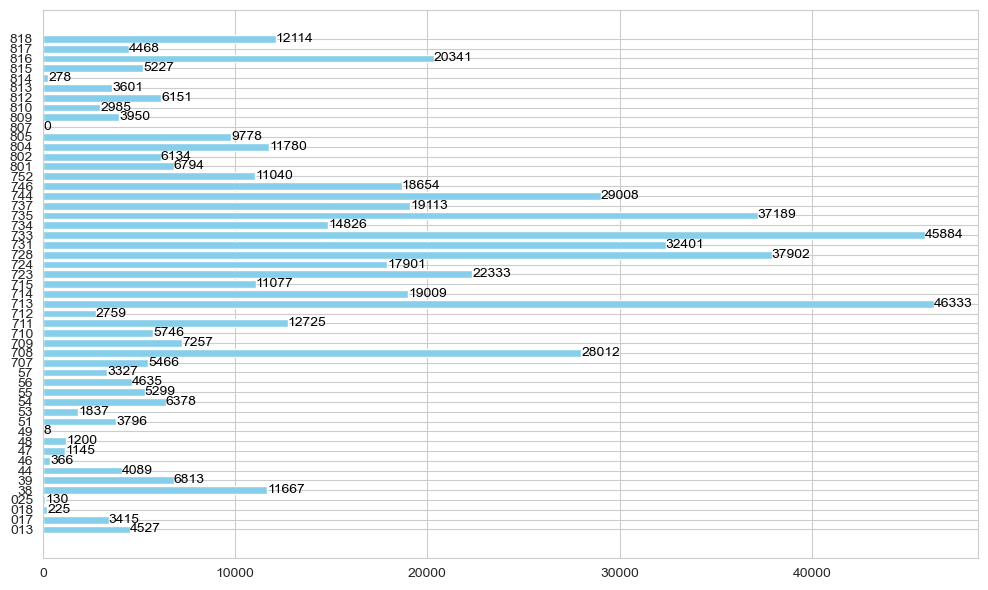

In [38]:
from matplotlib import pyplot as plt
y_all = joblib.load(r'paper\y_balanced_51_atleast2.pkl')

# Calculate sums
sums = [sum(arr) for arr in y_all.values()]
labels = list(y_all.keys())

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, sums, color='skyblue')
# Add labels (sum values) to each bar
for bar, value in zip(bars, sums):
    plt.text(value, bar.get_y() + bar.get_height() / 2, f'{value}', 
             va='center', ha='left', color='black')
plt.tight_layout()


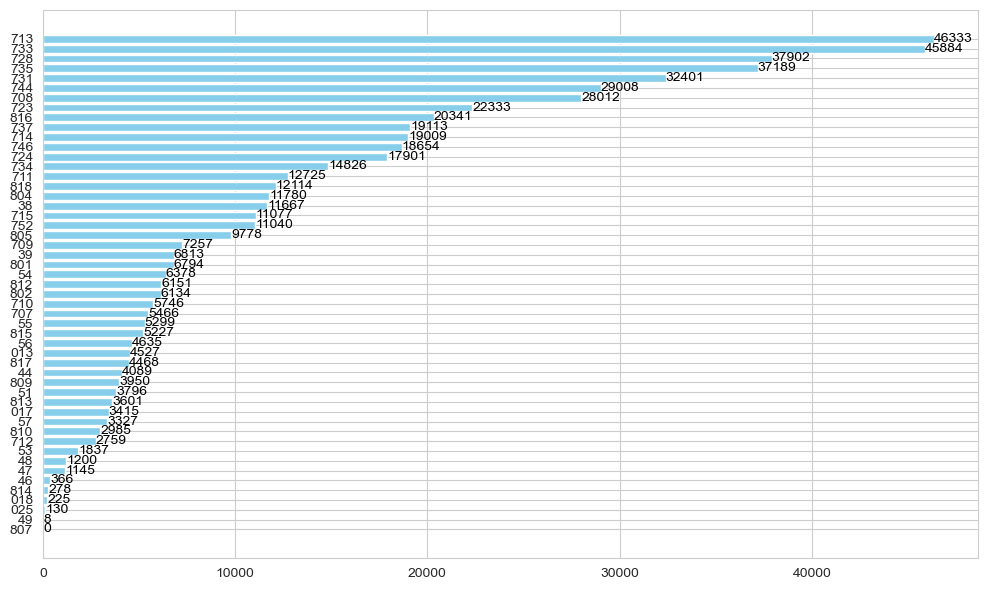

In [39]:
# Calculate sums
sorted_items = sorted(y_all.items(), key=lambda item: sum(item[1]))
labels = [item[0] for item in sorted_items]
sums = [sum(item[1]) for item in sorted_items]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, sums, color='skyblue')
# Add labels (sum values) to each bar
for bar, value in zip(bars, sums):
    plt.text(value, bar.get_y() + bar.get_height() / 2, f'{value}', 
             va='center', ha='left', color='black')
plt.tight_layout()

In [40]:
sum(sums)

577093

Text(0.5, 1.0, 'Proportion of Sums of Arrays in Dictionary')

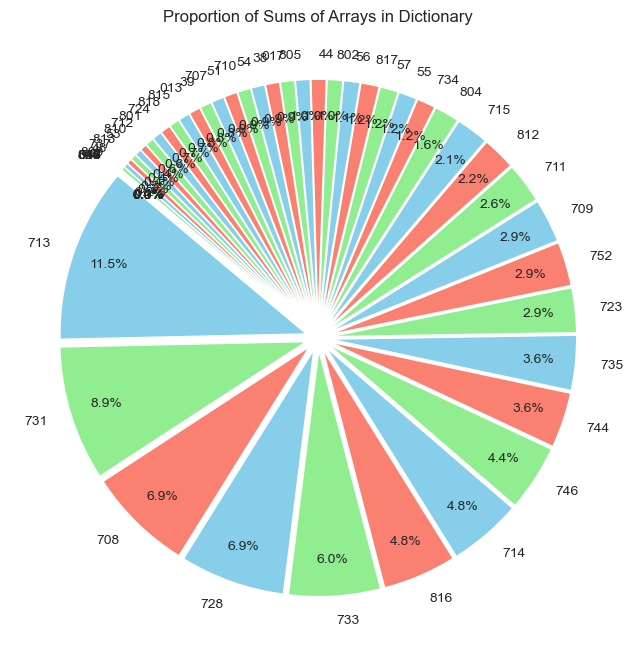

In [34]:
# Calculate sums and sort by sum values
sorted_items = sorted(y_all.items(), key=lambda item: sum(item[1]), reverse=True)
labels = [item[0] for item in sorted_items]
sums = [sum(item[1]) for item in sorted_items]

# Set up the explode effect for each slice to pull them slightly apart
explode = [0.05] * len(sums)  # Adjust the value as needed

# Create the pie chart
plt.figure(figsize=(10, 8))  # Increase figure size for clarity
plt.pie(sums, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'salmon'],
        explode=explode, pctdistance=0.85, labeldistance=1.1)


# Add title
plt.title('Proportion of Sums of Arrays in Dictionary')

In [6]:
from scipy.stats import binom_test

# Example values
N = 100  # Total number of samples
accuracy = 0.59  # Observed accuracy
k = int(accuracy * N)  # Correct predictions
chance_level = 0.50  # Expected chance level

# Perform binomial test
p_value = binom_test(k, N, chance_level, alternative='greater')
print(f"Accuracy: {accuracy * 100}%")
print(f"P-value: {p_value}")

Accuracy: 59.0%
P-value: 0.044313040057033834


C:\Users\user\AppData\Local\Temp\ipykernel_4252\4205523550.py:10: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = binom_test(k, N, chance_level, alternative='greater')


In [ ]:
import mne
mtl_path = 'C:\\clean_zeeg\\P%s_mtl_clean.fif'
tlv_subjects = ['013', '017', '018', '025', '38', '39', '44', '46', '47', '48', '49', '51', '53', '54', '55', '56', '57']
bonn_subjects = ['707', '708', '709', '710', '711', '712', '713', '714', '715', '723', '724', '728', '731', '733', '734', '735', '737', '744', '746', '752']
milan_subjects = ['801', '802', '804', '805', '807', '809', '810', '812', '813', '814', '815', '816', '817', '818']
depth_channels = ['RAH1', 'LAH1', 'RA1', 'LA1', 'LEC1', 'REC1', 'RPHG1', 'LPHG1', 'RMH1', 'LMH1', 'LH1', 'RH1', 'RA3'
                  'RAH2', 'LAH2', 'RA2', 'LA2', 'LEC2', 'REC2', 'RPHG2', 'LPHG2', 'RMH2', 'LMH2', 'LH2', 'RH2']
all_subjects = tlv_subjects + bonn_subjects + milan_subjects
result = {}
for subj in all_subjects:
    raw = mne.io.read_raw(mtl_path % subj)
    curr_chans = [chan for chan in raw.ch_names if chan in depth_channels]
    result[subj] = curr_chans

print({subj:len(x) for subj,x in result.items()})

In [11]:
sum_results = {subj:len(x) for subj,x in result.items()}
{subj:sum_results[subj] for subj in all_subjects if sum_results[subj] < 4}

{'018': 2,
 '025': 2,
 '46': 2,
 '49': 3,
 '53': 3,
 '801': 3,
 '807': 1,
 '809': 3,
 '814': 2,
 '818': 3}

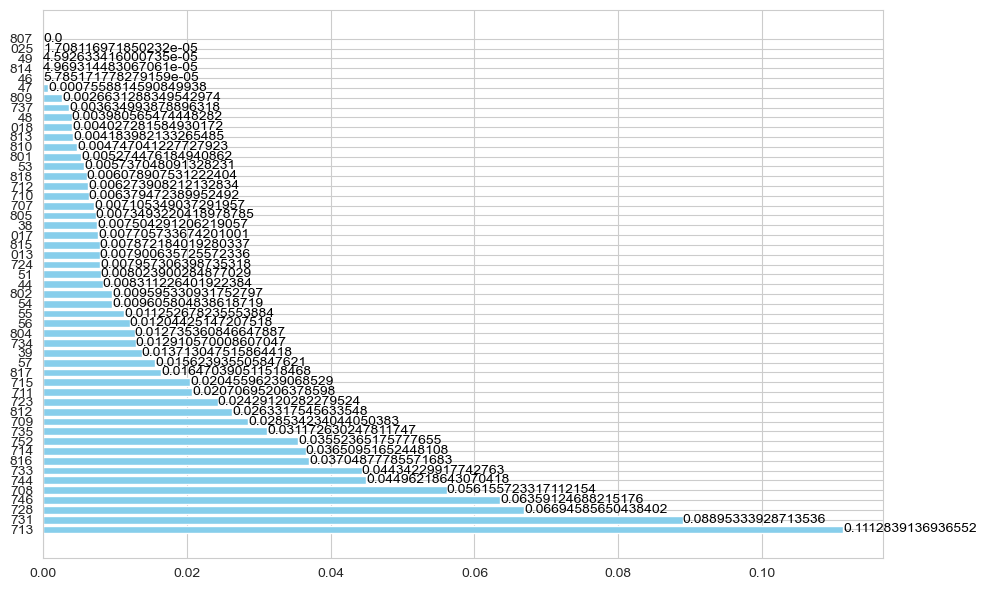

In [75]:
from matplotlib import pyplot as plt

y_all = joblib.load(r'paper\y_51_atleast2_fix.pkl')

# Calculate sums
sorted_items = sorted(y_all.items(), key=lambda item: sum(item[1])/ len(item[1]), reverse=True)
labels = [item[0] for item in sorted_items]
ratios = [sum(item[1])/len(item[1]) for item in sorted_items]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, ratios, color='skyblue')
# Add labels (sum values) to each bar
for bar, value in zip(bars, ratios):
    plt.text(value, bar.get_y() + bar.get_height() / 2, f'{value}',
             va='center', ha='left', color='black')
plt.tight_layout()

In [76]:
# get the avg of ratios list
sum(ratios) / len(ratios)

0.019105839325272312

In [13]:
import joblib
a = joblib.load(r'paper\y_under10_prob50.pkl')
print({subj:sum(x) for subj,x in a.items()})

{'018': 122, '025': 8, '46': 67, '49': 2, '53': 1074, '801': 2871, '807': 0, '809': 1489, '814': 48, '818': 4080}


In [15]:
subj_name = {'44': 'AO0', '46': 'MM1', '47': 'SS1', '48': 'TA1', '49': 'MF7'}
subj_ratio = {'44': 0.006009, '46': 5.7079e-5, '47': 0.0001559, '48': 0.0072547, '49': 0.0072547}
ratios = {}
for subj in subj_name:
    ratios[subj_name[subj]] = subj_ratio[subj] 

# Sort the ratios by their values
sorted_ratios = sorted(ratios.items(), key=lambda x: x[1], reverse=True)

# Print the results with 5 decimal places
for subj, ratio in sorted_ratios:
    print(f"{subj}: {ratio:.6f}")

TA1: 0.007255
MF7: 0.007255
AO0: 0.006009
SS1: 0.000156
MM1: 0.000057


In [17]:
import pandas as pd

# Load the CSV file into a DataFrame
df1 = pd.read_csv(r'paper\feature_importance.csv')

# Sort the DataFrame by the second column in descending order
sorted_df1 = df1.sort_values(by=df1.columns[1], ascending=False)

# Get the values of the first column as a sorted list
sorted_list1 = sorted_df1[df1.columns[0]].tolist()[:75]
cleaned_list1 = list(dict.fromkeys([item.replace('eog1_', '').replace('eog2_', '') for item in sorted_list1]))

print(cleaned_list1)

['chan_kurt', 'chan_ptp', 'chan_skew', 'energy_freq_bands_gamma', 'energy_freq_bands_beta', 'energy_freq_bands_bg', 'samp_entropy', 'teager_kaiser_energy_1_std', 'line_length', 'skewness', 'mean', 'teager_kaiser_energy_0_mean', 'energy_freq_bands_sigma', 'spect_slope_slope', 'teager_kaiser_energy_2_std', 'ptp_amp', 'quantile', 'teager_kaiser_energy_0_std', 'energy_freq_bands_gf', 'std', 'higuchi_fd', 'pow_freq_bands_gamma/beta', 'rms', 'teager_kaiser_energy_2_mean', 'hjorth_mobility', 'energy_freq_bands_alpha', 'energy_freq_bands_ag', 'wavelet_coef_energy_0', 'teager_kaiser_energy_3_std', 'wavelet_coef_energy_4', 'energy_freq_bands_theta', 'energy_freq_bands_bt', 'energy_freq_bands_fast', 'energy_freq_bands_bf', 'energy_freq_bands_gt', 'kurtosis', 'pow_freq_bands_beta/gamma', 'energy_freq_bands_sg', 'spect_slope_intercept', 'svd_entropy', 'teager_kaiser_energy_5_mean', 'hjorth_complexity_spect', 'svd_fisher_info', 'hurst_exp', 'katz_fd', 'energy_freq_bands_ab', 'teager_kaiser_energy_5_

In [18]:
# Load the CSV file into a DataFrame
df = pd.read_csv(r'paper\permutation_importance_results.csv')

# Sort the DataFrame by the second column in descending order
sorted_df = df.sort_values(by=df.columns[1], ascending=False)

# Get the values of the first column as a sorted list
sorted_list = sorted_df[df.columns[0]].tolist()[:75]
cleaned_list = list(dict.fromkeys([item.replace('eog1_', '').replace('eog2_', '') for item in sorted_list]))

print(cleaned_list)

['chan_kurt', 'chan_ptp', 'chan_skew', 'energy_freq_bands_gamma', 'teager_kaiser_energy_1_std', 'energy_freq_bands_beta', 'samp_entropy', 'ptp_amp', 'energy_freq_bands_bg', 'mean', 'energy_freq_bands_alpha', 'pow_freq_bands_fast/alpha', 'energy_freq_bands_sigma', 'energy_freq_bands_gf', 'quantile', 'teager_kaiser_energy_0_mean', 'line_length', 'teager_kaiser_energy_0_std', 'teager_kaiser_energy_5_std', 'teager_kaiser_energy_2_std', 'spect_slope_intercept', 'higuchi_fd', 'skewness', 'energy_freq_bands_sg', 'hurst_exp', 'teager_kaiser_energy_2_mean', 'teager_kaiser_energy_3_std', 'energy_freq_bands_fast', 'energy_freq_bands_af', 'hjorth_mobility', 'pow_freq_bands_sigma/beta', 'energy_freq_bands_ab', 'pow_freq_bands_gamma/beta', 'svd_entropy', 'energy_freq_bands_theta', 'pow_freq_bands_fast/theta', 'pow_freq_bands_fast/beta', 'spect_entropy', 'pow_freq_bands_alpha/theta', 'energy_freq_bands_bf', 'energy_freq_bands_gt', 'pow_freq_bands_gamma/alpha', 'rms', 'pow_freq_bands_gamma/fast', 'wav

In [19]:
common_elements = [item for item in cleaned_list if item in cleaned_list1]
len(common_elements)

36

In [20]:
common_elements

['chan_kurt',
 'chan_ptp',
 'chan_skew',
 'energy_freq_bands_gamma',
 'teager_kaiser_energy_1_std',
 'energy_freq_bands_beta',
 'samp_entropy',
 'ptp_amp',
 'energy_freq_bands_bg',
 'mean',
 'energy_freq_bands_alpha',
 'energy_freq_bands_sigma',
 'energy_freq_bands_gf',
 'quantile',
 'teager_kaiser_energy_0_mean',
 'line_length',
 'teager_kaiser_energy_0_std',
 'teager_kaiser_energy_5_std',
 'teager_kaiser_energy_2_std',
 'spect_slope_intercept',
 'higuchi_fd',
 'skewness',
 'energy_freq_bands_sg',
 'hurst_exp',
 'teager_kaiser_energy_2_mean',
 'teager_kaiser_energy_3_std',
 'energy_freq_bands_fast',
 'hjorth_mobility',
 'energy_freq_bands_ab',
 'pow_freq_bands_gamma/beta',
 'svd_entropy',
 'energy_freq_bands_theta',
 'energy_freq_bands_bf',
 'energy_freq_bands_gt',
 'rms',
 'energy_freq_bands_ag']

In [ ]:
subj_name = {'44': 'AO0', '46': 'MM1', '47': 'SS1', '48': 'TA1', '49': 'MF7'}
ratios = {}
# calc ratio per subject
for subj in subj_name:
    y_subj = subj_data[subj]['y']
    ratios[subj_name[subj]] = sum(y_subj) / len(y_subj)

# Sort the ratios by their values
sorted_ratios = sorted(ratios.items(), key=lambda x: x[1], reverse=True)

# Print the results with 5 decimal places
for subj, ratio in sorted_ratios:
    print(f"{subj}: {ratio:.6f}")

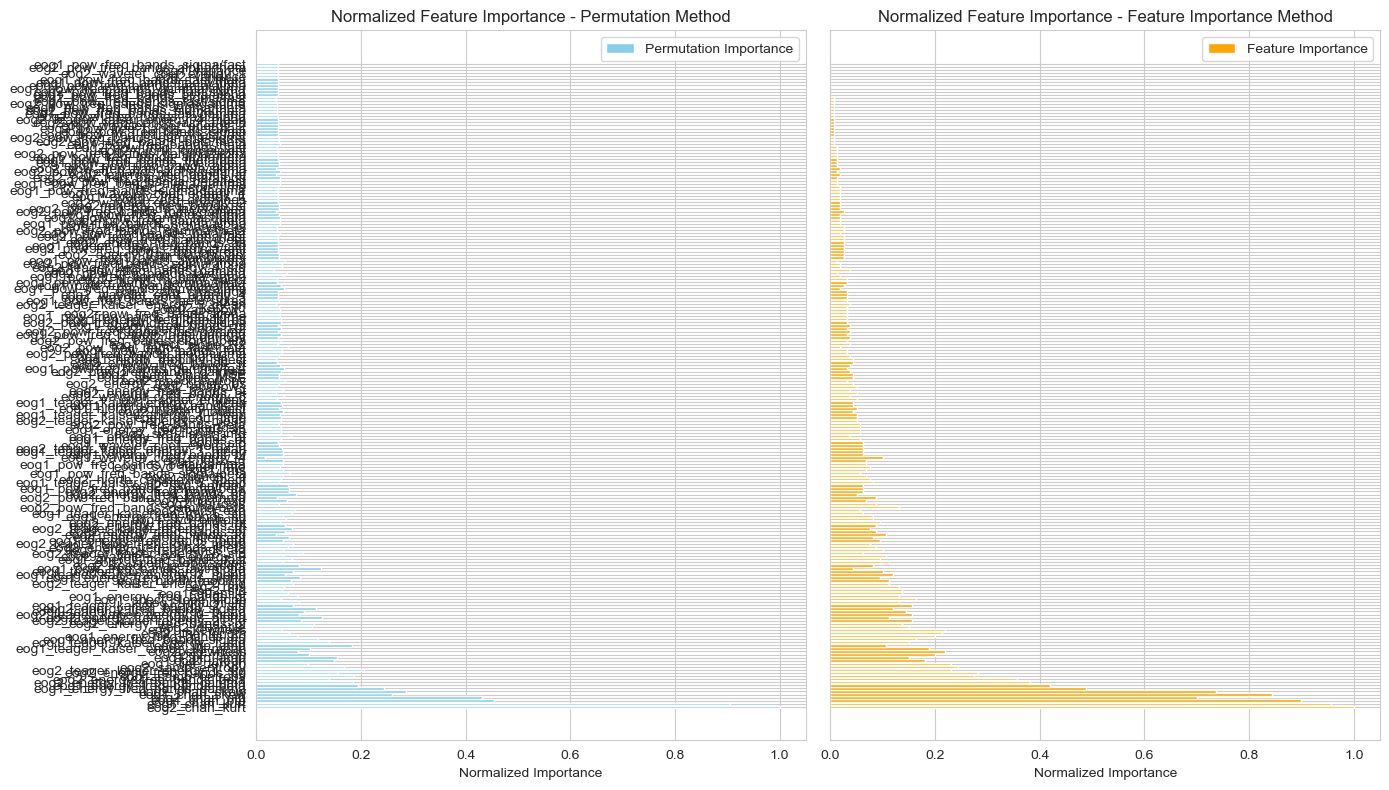

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# File paths
csv1 = r"paper\permutation_importance_results.csv"
csv2 = r"paper\feature_importance.csv"

# Load the data
data1 = pd.read_csv(csv1)
data2 = pd.read_csv(csv2)

# Ensure consistent feature naming
data1.columns = ['Feature', 'Importance1', 'std']
data2.columns = ['Feature', 'Importance2']

# Merge the data on features
merged_data = pd.merge(data1[['Feature', 'Importance1']], data2, on='Feature', how='inner')

# Normalize importance values for both methods
scaler = MinMaxScaler()
merged_data['NormalizedImportance1'] = scaler.fit_transform(merged_data[['Importance1']])
merged_data['NormalizedImportance2'] = scaler.fit_transform(merged_data[['Importance2']])

# Sort by the average normalized importance for consistent feature ordering
merged_data['AverageNormalizedImportance'] = (merged_data['NormalizedImportance1'] + merged_data['NormalizedImportance2']) / 2
merged_data.sort_values(by='AverageNormalizedImportance', ascending=False, inplace=True)

# Set up the plot
fig, axs = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

# Define feature names and reverse them for descending order
features = merged_data['Feature']
y_pos = range(len(features))  # Create a consistent y-axis range

# Plot for Method 1
axs[0].barh(y_pos, merged_data['NormalizedImportance1'], color='skyblue', label="Permutation Importance")
axs[0].set_title('Normalized Feature Importance - Permutation Method')
axs[0].set_xlabel('Normalized Importance')
axs[0].set_yticks(y_pos)
axs[0].set_yticklabels(features)
axs[0].invert_yaxis()  # Highest importance at the top
axs[0].legend()

# Plot for Method 2
axs[1].barh(y_pos, merged_data['NormalizedImportance2'], color='orange', label="Feature Importance")
axs[1].set_title('Normalized Feature Importance - Feature Importance Method')
axs[1].set_xlabel('Normalized Importance')
axs[1].set_yticks(y_pos)
axs[1].set_yticklabels(features)
axs[1].invert_yaxis()  # Keep the same order as the first plot
axs[1].legend()

plt.tight_layout()
plt.show()
